# Importing Packages

In [2]:
from backtesting import Backtest, Strategy
from backtesting.backtesting import Order, Position, Trade, _Broker
from backtesting.test import GOOG
from backtesting.lib import crossover

import tulipy as ti

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import dask
import dask.dataframe as dd
from dask import delayed

In [3]:
# Getting the non-preinstalled packages into a requirements.txt format (for Google Colab):

# !pip freeze > requirements.txt
# # Backtesting==0.3.3
# # tulipy==0.4.0
# # pandas==2.1.4
# # numpy==1.26.4
# # matplotlib==3.8.0
# # dask==2023.11.0

# Btw, pandas, numpy, and matplotlib are already installed in Colab, so those are not technically required here

In [4]:
# Just showing/getting the version number
# pip show dask

# Importing from Previous Notebook to Get Chart for Visualization

            timestamp    open    high     low   close   volume
0 2024-07-15 04:00:00  232.22  233.26  232.22  233.26  17697.0
1 2024-07-15 04:01:00  233.25  233.75  233.25  233.55   7151.0
2 2024-07-15 04:02:00  233.50  234.00  233.50  233.81   6579.0
3 2024-07-15 04:03:00  233.71  233.89  233.61  233.70   6007.0
4 2024-07-15 04:04:00  233.69  233.70  232.00  233.44   6335.0


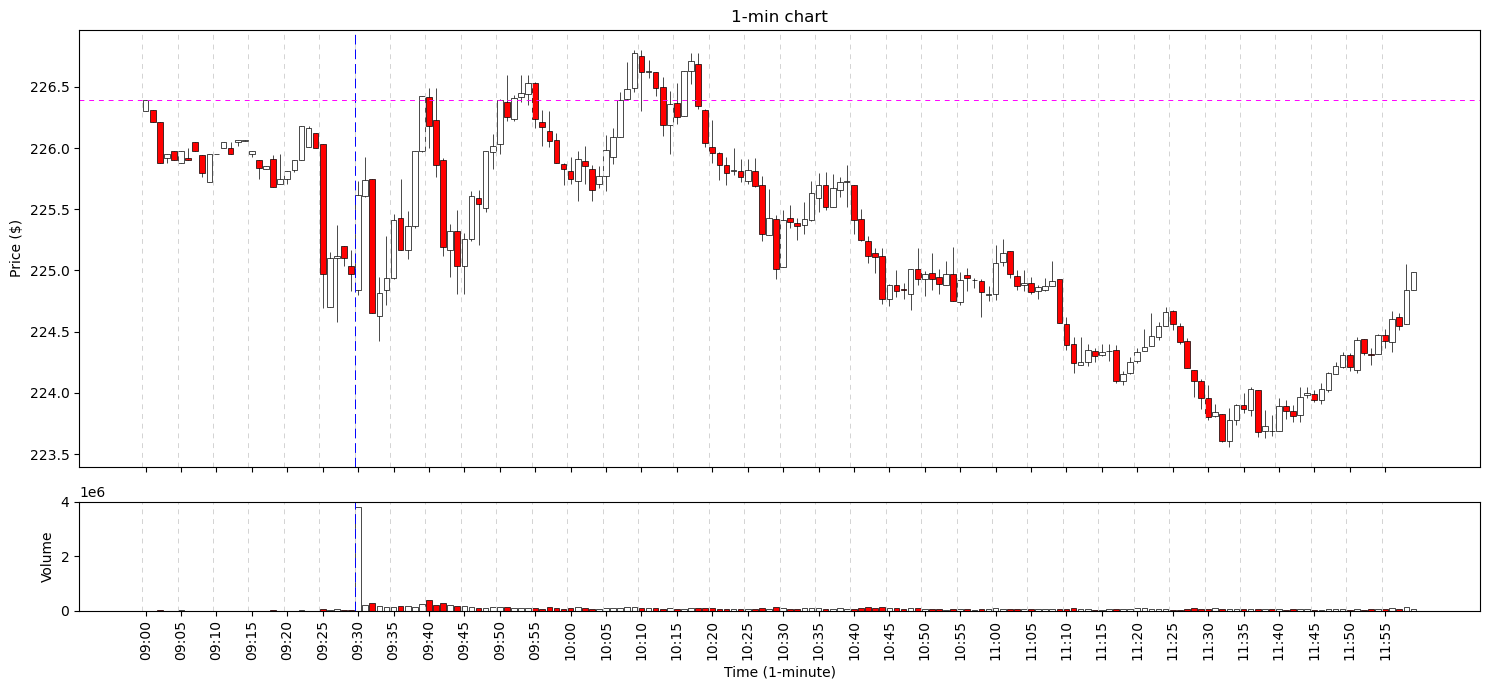

In [5]:
import import_ipynb
import importlib
import DS_Trading_Practice_v2_functions_Copy1 as Chart_Func;

# Do the below if you need to reload your function (might not have loaded correctly yet)
# importlib.reload(Chart_Func);

In [6]:
def get_chart_visual(STOCK_1min, keep_only_PM_to_TD, Chosen_date, first_min_bar, last_min_bar):
    STOCK_1min_for_chart = Chart_Func.fill_missing_minutes(STOCK_1min, keep_only_PM_to_TD)
    STOCK_1min_for_chart = Chart_Func.separate_dt(STOCK_1min_for_chart)
    STOCK_1min_for_chart = Chart_Func.cutoff_irrelevant_hours(STOCK_1min_for_chart)

    STOCK_Daily_PM_HL = Chart_Func.get_daily_PM_HL(STOCK_1min_for_chart)

    STOCK_1min_1_date = Chart_Func.full_1min_one_date(STOCK_1min_for_chart, Chosen_date)
    STOCK_S = Chart_Func.limit_times(STOCK_1min_1_date, first_min_bar, last_min_bar)

    STOCK_green_CS = Chart_Func.get_green_CS(STOCK_S)
    STOCK_red_CS = Chart_Func.get_red_CS(STOCK_S)

    Chart_Func.get_CS_and_volume_graphs(STOCK_S, STOCK_green_CS, STOCK_red_CS, STOCK_Daily_PM_HL, Chosen_date)

# Data Transformation / Cleaning Steps (Should Only be Necessary with New Datasets)

In [7]:
# Function for converting timestamp and setting it as index
def get_true_timestamp_and_set_as_index(pd_csv_ticker_1min):
    # Converting timestamp to actual timestamp
    pd_csv_ticker_1min['timestamp'] = pd.to_datetime(pd_csv_ticker_1min['timestamp'])
    
    # Setting the index to the timestamp
    pd_csv_ticker_1min.set_index('timestamp', inplace=True)

    return pd_csv_ticker_1min

In [8]:
# Function for filling in missing minutes
def fill_missing_minutes(index_timestamp_1_min, keep_only_PM_to_TD = False, PM_cutoff_time ='04:00'):
    index_timestamp_1_min = index_timestamp_1_min.resample('min').asfreq()

    # Filling in NaN values (volume with 0 and close to the last known close)
    index_timestamp_1_min['volume'] = index_timestamp_1_min['volume'].fillna(0);
    index_timestamp_1_min['close'] = index_timestamp_1_min['close'].ffill();
    
    # Filling in the rest, with the NaN being equal to the previous close
    index_timestamp_1_min['open'] = index_timestamp_1_min['open'].fillna(index_timestamp_1_min['close']);
    index_timestamp_1_min['high'] = index_timestamp_1_min['high'].fillna(index_timestamp_1_min['close']);
    index_timestamp_1_min['low'] = index_timestamp_1_min['low'].fillna(index_timestamp_1_min['close']);
    
    # Making sure there are only weekdays
    index_timestamp_1_min = index_timestamp_1_min[index_timestamp_1_min.index.weekday < 5]

    # Keeping only data from PM_cutoff_time to 3:59pm (if keep_only_PM_to_TD is True)
    if keep_only_PM_to_TD:
        index_timestamp_1_min = index_timestamp_1_min.between_time(PM_cutoff_time, '15:59')

    return index_timestamp_1_min

In [9]:
# Renaming columns with uppercase
def upper_case_OHLCV(no_missing_1_min):
    no_missing_1_min.rename(columns = {'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace = True)

    return no_missing_1_min

# Getting in Initial Data for MSFT

In [10]:
# Loading in csv file data
MSFT_1min_sample_path = '../frd_stock_sample/MSFT_1min_sample.csv'
MSFT_1min = pd.read_csv(MSFT_1min_sample_path)

MSFT_1min = get_true_timestamp_and_set_as_index(MSFT_1min)
MSFT_1min_for_chart = MSFT_1min.copy() # Necessary for chart later on
MSFT_1min = fill_missing_minutes(MSFT_1min, True)
MSFT_1min = upper_case_OHLCV(MSFT_1min)

# BHOD_Full_v1 Strategy

In [11]:
# With optimistic strategy (if sl hits with 1st tp, still get out, but assume that tp hits before be, so you still get profit)
class BHOD_Full_v1(Strategy):
    
    # Defining user inputs for volume, skipping opening range, bid-ask spread, and R
    use_volume_condition = True 
    set_volume_percent = 10  # Reset it back to 30% for default
    set_volume_avg_period = 14
    skip_opening_range = True
    minutes_skipped = 5
    BA_spread = 0.06  # Bid-ask spread manual input (default is 6 cents)
    risk_per_trade_R = 20  # Amount of money to risk per trade (default is $20)
    max_trade_amount = 50_000  # Maximum amount of money to use on a trade

    # R:R-based TP
    use_1st_RR_tp = True
    set_1st_R_partial = 1
    set_1st_R_percent = 25
    use_2nd_RR_tp = True
    set_2nd_R_partial = 2
    set_2nd_R_percent = 25
    use_3rd_RR_tp = True
    set_3rd_R_partial = 3
    set_3rd_R_percent = 50
    use_4th_RR_tp = False
    set_4th_R_partial = 4
    set_4th_R_percent = 0

    # Defining when to move SL
    move_SL_after_1st_tp = True
    move_SL_after_2nd_tp = False
    move_SL_after_3rd_tp = False

    
    def init(self):
        
        # Calculate average volume over last XX candlesticks
        # self.avg_volume = self.I(talib.SMA, self.data.Volume, self.set_volume_avg_period)  # This makes self.avg_volume and indicator that will
        # dynamically update in the next method (Do not delete even if using tulipy, will be useful for later)

        # If using tulipy for SMA instead:
        def tulipy_sma(data, period):

            # Calculate the SMA using tulipy
            sma_result = ti.sma(np.asarray(data), period)
            
            # Pad the result with NaNs to align with the input length
            nan_padding = np.full(period - 1, np.nan)
            
            return np.concatenate((nan_padding, sma_result))

        self.avg_volume = self.I(tulipy_sma, self.data.Volume, self.set_volume_avg_period)

        
        # Adding in volume condition (if applied)
        if self.use_volume_condition: # This adds the multiplier to self.avg_volume
            self.avg_volume = np.round(self.avg_volume * (1 + (self.set_volume_percent / 100)), decimals = 0)
        else: # Rounding to nearest whole number
            self.avg_volume = np.round(self.avg_volume, decimals = 0)

        # Getting timestamps as a series to manage day resets
        times = self.data.index

        # Calculate numpy array to store whether the high of each CS broke the HOD for each day
        len_data = len(self.data)  # Getting length of data
        self.HOD_array = np.zeros(len_data)  # Array for storing HOD
        self.prev_HOD_array = np.zeros(len_data + 1)  # Array for storing previous HOD
        self.prev_HOD_array[0] = 0  # Initializing first element of prev_HOD_array with 0

        # Initializing HOD_price and prev_HOD_price
        HOD_price = 0  # Current HOD including this CS
        prev_HOD_price = 0  # HOD excluding the current CS

        for i in range(len_data):
            # Reset the HOD at 9:30am each day
            if times[i].time() == pd.to_datetime('09:30').time():
                HOD_price = self.data.High[i]  # Reset the HOD to the open high of 9:30am candle

            # Update the HOD for the current day
            if self.data.High[i] > HOD_price:
                HOD_price = self.data.High[i]  # Update the high of the day

            # Store the HOD value for each point in the array
            self.HOD_array[i] = HOD_price

            # Store the HOD value for the next minute in the prev_HOD_array array
            self.prev_HOD_array[i + 1] = HOD_price

        # Removing the last element in prev_HOD_array to get the same length array as HOD_array 
        self.prev_HOD_array_view = self.prev_HOD_array[:-1]

        # Making both HOD_array and prev_HOD_array_view indicators (this part is EXTREMELY NECESSARY: the next method will only run an array dynamically
        # when it's either 1) an OHLCV field or 2) an indicator. By wrapping our pre-conceived np arrays in self.I(), we will create these indicators).
        self.HOD_indicator = self.I(lambda: self.HOD_array)
        self.prev_HOD_I = self.I(lambda: self.prev_HOD_array_view)
        
        # Create arrays for time conditions (true for times within __:__ to 15:55)
        self.start_time = pd.to_datetime('09:30').time()
        if self.skip_opening_range:
            self.start_time = (pd.to_datetime('09:30') + pd.Timedelta(minutes = self.minutes_skipped)).time()
        
        self.valid_trading_times = (self.start_time <= times.time) & (times.time <= pd.to_datetime('15:55').time())
        self.valid_trading_times_I = self.I(lambda: self.valid_trading_times)  # Turning valid_trading_times into indicator for next(self) method
    
        # Initializing (pre-sets) variables to only be changed in next(self) method when certain conditions are met.
        # Generally, this means that the variables will stay the same and not be in use until the position is opened, whereby it changes (and stays) at that new number:
        
        # Initializing previous midpoint, SL (stop loss), BE (breakeven), and entry with BA-spread
        self.previous_midpoint = None
        self.BHOD_SL = None
        self.BHOD_BE = None
        self.entry_w_slippage = None

        # Initializing dynamic shares calculation:
        self.dynamic_shares_total = None
        self.dynamic_1st_R_shares = None
        self.dynamic_2nd_R_shares = None
        self.dynamic_3rd_R_shares = None
        self.dynamic_4th_R_shares = None
        
        # Setting the TP_Long_XXX_R_price to None (to be changed when XXX take profit R-level is met)
        self.TP_Long_1st_R_price = None
        self.TP_Long_2nd_R_price = None
        self.TP_Long_3rd_R_price = None
        self.TP_Long_4th_R_price = None

        # Setting condition for 1st entry candle
        self.entry_CS = False
        
        # Setting checks for when positions are fulfilled so it doesn't repeat:
        self.check_SL = False
        self.check_BE = False
        self.check_1st_TP = False
        self.check_2nd_TP = False
        self.check_3rd_TP = False
        self.check_4th_TP = False

        # Defining entry price (necessary for backtesting purposes (see below in next(self) method)
        self.entry_price_stored = None

        # Defining BHOD_entry_correction (necessary for backtesting purposes (see below in next(self) method)
        self.BHOD_entry_correction = False

        # For testing purposes:
        self.start_time = None
        self.end_time = None


    
    def next(self):

        # if self.data.index[-1] == pd.to_datetime('2024-07-22 04:00:00'):
        #     print(self.data.index[-1])
        #     self.start_time = time.time()

        # If there are no positions open, then reset all the checks to False (more important below when doing SL, BE, and TP):
        if not self.position:
            self.check_SL = False
            self.check_BE = False
            self.check_1st_TP = False
            self.check_2nd_TP = False
            self.check_3rd_TP = False
            self.check_4th_TP = False

        # Resetting entry CS to False (will be turned on later)
        self.entry_CS = False
    

        # Valid trading time condition (if not valid, then skip this CS)
        if not self.valid_trading_times_I[-1]:
            return

        # Updated volume condition (so BHOD buy method can trigger when met):
        final_volume_condition = not self.use_volume_condition or self.data.Volume[-1] >= self.avg_volume[-1]

        # Creating condition for breaking previous HOD and condition for non-continuous HOD break
        broke_prev_HOD_cond = self.data.High[-1] > self.prev_HOD_I[-1]
        non_continuous_BHOD = self.data.High[-2] <= self.prev_HOD_I[-2] and self.data.High[-3] <= self.prev_HOD_I[-3]

        # Confirming conditions for long entry, and then entering long
        if broke_prev_HOD_cond and non_continuous_BHOD and final_volume_condition and not self.position:  # self.position checks if there's a position out there
            # Defining previous candlestick midpoint
            self.previous_midpoint = (self.data.Open[-2] + self.data.Close[-2]) / 2

            # For BHOD, set SL at the lower of the current CS low or halfway between open and close of previous CS
            self.BHOD_SL = min(self.previous_midpoint, self.data.Low[-1])

            # Including BA-spread slippage in price (min of (0.5 * BA_spread + prev HOD) and current CS high (to make sure we're still w/in the CS)):
            self.entry_w_slippage = min(self.prev_HOD_I[-1] + self.BA_spread / 2, self.data.High[-1]) 

            # Setting dynamic share size (need to wrap in int for self.position to work (because self.position.size needs to be int)):
            self.dynamic_shares_total = int(np.floor(self.risk_per_trade_R / (self.entry_w_slippage - self.BHOD_SL)))

            # If the total amount used (entry amount * share size) is larger than a set value, skip this CS
            if self.entry_w_slippage * self.dynamic_shares_total > self.max_trade_amount:
                return
            
            # Entry long (need to set sl and tp to None b/c they both trigger on next CS open price (i.e., they're not exact))
            self._broker._open_trade(price = self.entry_w_slippage,
                                     size = self.dynamic_shares_total, sl = None, tp = None, time_index = len(self.data)-1)

            # Setting condition for first entry candle to True:
            self.entry_CS = True
            
            # Setting self.check_SL and self.check_1st_TP to true so their conditions can be activated (down below):
            self.check_SL = True
            self.check_1st_TP = True

            # Store the entry price when position is opened
            self.entry_price_stored = self.trades[0].entry_price  # trades is a tuple, so need to access first element in tuple first to get entry_price

            # Setting take profit prices
            self.TP_Long_1st_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_1st_R_partial + self.entry_price_stored
            self.TP_Long_2nd_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_2nd_R_partial + self.entry_price_stored
            self.TP_Long_3rd_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_3rd_R_partial + self.entry_price_stored
            self.TP_Long_4th_R_price = (self.entry_price_stored - self.BHOD_SL) * self.set_4th_R_partial + self.entry_price_stored

            # Setting take profit share sizes
            if self.use_1st_RR_tp:
                self.dynamic_1st_R_shares = int(np.floor(self.dynamic_shares_total * self.set_1st_R_percent / 100))
            # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that (instead of doing it all at once in the beginning)
            if self.use_2nd_RR_tp:
                self.dynamic_2nd_R_shares = int(np.floor(
                    (self.dynamic_shares_total - self.dynamic_1st_R_shares) * self.set_2nd_R_percent / (100 - self.set_1st_R_percent)))
            # 3R follows suit
            if self.use_3rd_RR_tp:
                self.dynamic_3rd_R_shares = int(np.floor(
                    (self.dynamic_shares_total - self.dynamic_1st_R_shares - self.dynamic_2nd_R_shares) * 
                    self.set_3rd_R_percent / (100 - self.set_1st_R_percent - self.set_2nd_R_percent)))
            # 4R follows suit as well (if applied)
            if self.use_4th_RR_tp:
                self.dynamic_4th_R_shares = int(np.floor(
                    (self.dynamic_shares_total - self.dynamic_1st_R_shares - self.dynamic_2nd_R_shares - self.dynamic_3rd_R_shares) * 
                    self.set_4th_R_percent / (100 - self.set_1st_R_percent - self.set_2nd_R_percent - self.set_3rd_R_percent)))

        
        # If the position is open and the low of a CS falls below SL, close the position
        if self.position and self.check_SL and self.data.Low[-1] < self.BHOD_SL:
            self._broker._reduce_trade(self.trades[0], max(self.BHOD_SL - self.BA_spread / 2, self.data.Low[-1]),
                                       -1 * self.position.size, len(self.data)-1)  #  You'll always lose a little extra b/c of slippage
        
        # If SL is not hit and we're on the 1st R (self.check_1st_TP is True), check for tp; if the high hits tp level, partial a certain amount
        if self.position and self.use_1st_RR_tp and self.check_1st_TP and self.data.High[-1] >= self.TP_Long_1st_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_1st_R_price, -1 * self.dynamic_1st_R_shares, len(self.data)-1)
            self.check_1st_TP = False
            self.check_2nd_TP = True
            self.BHOD_BE = self.entry_price_stored  # Set the BE amount to the entry price

            # If SL should be moved after 1st tp (move_SL_after_1st_tp = True), move SL to breakeven; if not, maintain SL
            if self.move_SL_after_1st_tp:
                self.check_SL = False
                self.check_BE = True

        # Note: don't need to include bid-ask spread for take profit because you will ONLY sell at that tp price (or better)

        # If 1st tp is successful, set the check to be the 2nd tp, and partial that amount
        if self.position and self.use_2nd_RR_tp and self.check_2nd_TP and self.data.High[-1] >= self.TP_Long_2nd_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_2nd_R_price, -1 * self.dynamic_2nd_R_shares, len(self.data)-1)
            self.check_2nd_TP = False
            self.check_3rd_TP = True

            # If SL should be moved after 2nd tp (move_SL_after_2nd_tp = True), move SL to breakeven; if not, maintain SL
            if self.move_SL_after_2nd_tp:
                self.check_SL = False
                self.check_BE = True

        # If 2nd tp is successful, set the check to be the 3rd tp, and partial that amount
        if self.position and self.use_3rd_RR_tp and self.check_3rd_TP and self.data.High[-1] >= self.TP_Long_3rd_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_3rd_R_price, -1 * self.dynamic_3rd_R_shares, len(self.data)-1)
            self.check_3rd_TP = False
            self.check_4th_TP = True

            # If SL should be moved after 3rd tp (move_SL_after_3rd_tp = True), move SL to breakeven; if not, maintain SL
            if self.move_SL_after_3rd_tp:
                self.check_SL = False
                self.check_BE = True

        # If 3rd tp is successful, set the check to be the 4th tp, and partial that amount (if applied)
        if self.position and self.use_4th_RR_tp and self.check_4th_TP and self.data.High[-1] >= self.TP_Long_4th_R_price:
            self._broker._reduce_trade(self.trades[0], self.TP_Long_4th_R_price, -1 * self.dynamic_4th_R_shares, len(self.data)-1)
            self.check_4th_TP = False

        # If BE (breakeven) is hit (not on the 1st (entry) CS), close the position (optimistic because it goes last)
        if self.position and self.check_BE and not self.entry_CS and self.data.Low[-1] < self.BHOD_BE:
            self._broker._reduce_trade(self.trades[0], max(self.BHOD_BE - self.BA_spread / 2, self.data.Low[-1]),
                                       -1 * self.position.size, len(self.data)-1)  # Even at BE, slippage will cause you to lose a bit more

        # Closing all orders and positions at 3:55pm
        if self.data.index.time[-1] == pd.to_datetime('15:55').time():

            # Cancel all open orders
            for order in self.orders:
                order.cancel()

            # Close any open positions
            if self.position:
                self._broker._reduce_trade(self.trades[0], self.data.Close[-1], -1 * self.position.size, len(self.data)-1)
            
        # if self.data.index[-1] == pd.to_datetime('2024-07-22 15:54:00'):
        #     print(self.data.index[-1])
        #     self.end_time = time.time()
        #     print(self.end_time - self.start_time)

# Backtesting.py doc code
# https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py

# Still need to test slippage on paper trading account
# Need to consider broker fees, commissions, etc.

# MSFT_1min Testing

In [12]:
# Running some test trades
bt_test = Backtest(MSFT_1min, BHOD_Full_v1, cash = 100_000, commission = 0.002)

run_test = bt_test.run()
# run_test = bt_test.run(use_volume_condition = True, move_SL_after_1st_tp = False, move_SL_after_2nd_tp = True)
# run_test = bt_test.run(use_volume_condition = True, set_1st_R_percent = 100, use_2nd_RR_tp = False, use_3rd_RR_tp = False)
# run_test = bt_test.run(use_volume_condition = True, set_1st_R_percent = 50, set_2nd_R_percent = 50, use_3rd_RR_tp = False)
run_test._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,9,421,433,456.28,456.79335,4.62015,0.001125,2024-07-15 11:01:00,2024-07-15 11:13:00,0 days 00:12:00
1,29,421,446,456.28,456.25000,-0.87000,-0.000066,2024-07-15 11:01:00,2024-07-15 11:26:00,0 days 00:25:00
2,25,2060,2061,444.38,444.57600,4.90000,0.000441,2024-07-17 14:20:00,2024-07-17 14:21:00,0 days 00:01:00
3,77,2060,2062,444.38,444.35000,-2.31000,-0.000068,2024-07-17 14:20:00,2024-07-17 14:22:00,0 days 00:02:00
4,62,2123,2126,444.70,444.35250,-21.54500,-0.000781,2024-07-17 15:23:00,2024-07-17 15:26:00,0 days 00:03:00
5,7,3995,4000,443.93,444.59500,4.65500,0.001498,2024-07-22 10:35:00,2024-07-22 10:40:00,0 days 00:05:00
6,23,3995,4004,443.93,443.90000,-0.69000,-0.000068,2024-07-22 10:35:00,2024-07-22 10:44:00,0 days 00:09:00
7,8,4658,4660,444.47,445.07000,4.80000,0.001350,2024-07-23 09:38:00,2024-07-23 09:40:00,0 days 00:02:00
8,8,4658,4660,444.47,445.67000,9.60000,0.002700,2024-07-23 09:38:00,2024-07-23 09:40:00,0 days 00:02:00
9,17,4658,4662,444.47,446.27000,30.60000,0.004050,2024-07-23 09:38:00,2024-07-23 09:42:00,0 days 00:04:00


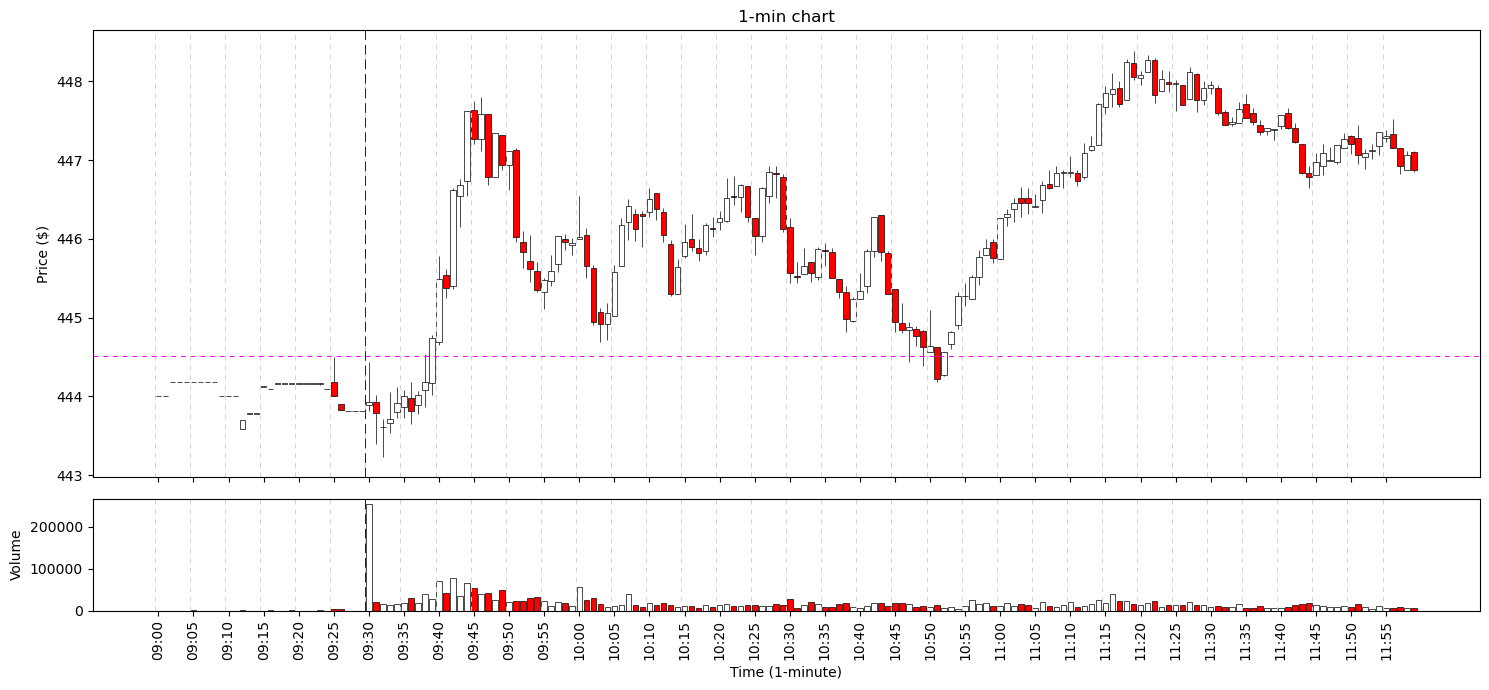

In [13]:
# Getting chart visualization for a particular date
date_in_str = '2024-07-23'
get_chart_visual(MSFT_1min_for_chart, True, date_in_str, 300, 480)

# Delayed Function for Partioning Purposes

In [14]:
# Defining a delayed function that basically doesn't compute until dask.compute() is run (which allows the parallel running to execute)
@delayed
def run_backtest_on_partition(data_partition, strategy_class, cash=100_000):
    
    if data_partition.empty:  # Skip if the partition is on the weekend or holiday (and thus will have empty data)
        return None
        
    bt_test = Backtest(data_partition, strategy_class, cash=cash)  # Defining backtest
    result = bt_test.run()._trades  # Running backtest (but not yet, and will only run when dask.compute() is called)
    # *Note, we're only taking the trades and calculating everything from that afterward

    return result

# Loading MSFT 3y, TSLA 3y, and TSLA 10y 9am-3:59pm poly data

In [231]:
# Loading in MSFT 3y data and parsing timestamp, and then setting timestamp as index
MSFT_1min_poly_3y_9am_4pm = dd.read_csv('../MSFT_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
MSFT_1min_poly_3y_9am_4pm = MSFT_1min_poly_3y_9am_4pm.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
MSFT_1min_poly_3y_9am_4pm = MSFT_1min_poly_3y_9am_4pm.repartition(freq='1D')

In [659]:
# Loading in TSLA 3y data and parsing timestamp, and then setting timestamp as index
TSLA_1min_poly_3y_9am_4pm = dd.read_csv('../TSLA_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
TSLA_1min_poly_3y_9am_4pm = TSLA_1min_poly_3y_9am_4pm.set_index('timestamp')

# Repartitioning into frequency of 1 day
TSLA_1min_poly_3y_9am_4pm = TSLA_1min_poly_3y_9am_4pm.repartition(freq='1D')

In [660]:
# Loading in TSLA 10y data and parsing timestamp, and then setting timestamp as index
TSLA_1min_poly_10y_9am_4pm = dd.read_csv('../TSLA_1min_poly_10y_9am_4pm.csv', parse_dates=['timestamp'])
TSLA_1min_poly_10y_9am_4pm = TSLA_1min_poly_10y_9am_4pm.set_index('timestamp')

# Repartitioning into frequency of 1 day
TSLA_1min_poly_10y_9am_4pm = TSLA_1min_poly_10y_9am_4pm.repartition(freq='1D')

# Running MSFT 3y, TSLA 3y, and TSLA 10y 9am-3:59pm poly data

In [1860]:
start_time = time.time()
# Testing with the MSFT_1min_poly_3y_9am_4pm (dask df) for full test

# Apply the function to each partition and get delayed objects for each backtest
partitions_MSFT_3y_9am_4pm = MSFT_1min_poly_3y_9am_4pm.to_delayed()
bt_results_MSFT_3y_9am_4pm = [run_backtest_on_partition(partition, BHOD_Full_v1) for partition in partitions_MSFT_3y_9am_4pm]

# Compute all results
all_results_MSFT_3y_9am_4pm = dask.compute(*bt_results_MSFT_3y_9am_4pm)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_MSFT_3y_9am_4pm = pd.concat(all_results_MSFT_3y_9am_4pm, axis=0).reset_index(drop = True)

print(time.time() - start_time)
# Final time was 1 minute 10 seconds (70 seconds)

68.94895100593567


In [1862]:
start_time = time.time()
# Testing with the TSLA_1min_poly_3y_9am_4pm (dask df) for full test

# Apply the function to each partition and get delayed objects for each backtest
partitions_TSLA_3y_9am_4pm = TSLA_1min_poly_3y_9am_4pm.to_delayed()
bt_results_TSLA_3y_9am_4pm = [run_backtest_on_partition(partition, BHOD_Full_v1) for partition in partitions_TSLA_3y_9am_4pm]

# Compute all results
all_results_TSLA_3y_9am_4pm = dask.compute(*bt_results_TSLA_3y_9am_4pm)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_TSLA_3y_9am_4pm = pd.concat(all_results_TSLA_3y_9am_4pm, axis=0).reset_index(drop = True)

print(time.time() - start_time)
# Final time was 1 minute 9 seconds (69 seconds)

70.19812679290771


In [1863]:
start_time = time.time()
# Testing with the TSLA_1min_poly_10y_9am_4pm (dask df) for full test

# Apply the function to each partition and get delayed objects for each backtest
partitions_TSLA_10y_9am_4pm = TSLA_1min_poly_10y_9am_4pm.to_delayed()
bt_results_TSLA_10y_9am_4pm = [run_backtest_on_partition(partition, BHOD_Full_v1) for partition in partitions_TSLA_10y_9am_4pm]

# Compute all results
all_results_TSLA_10y_9am_4pm = dask.compute(*bt_results_TSLA_10y_9am_4pm)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_TSLA_10y_9am_4pm = pd.concat(all_results_TSLA_10y_9am_4pm, axis=0).reset_index(drop = True)

print(time.time() - start_time)
# Final time was 3 minutes 50 seconds (230 seconds)

227.25005888938904


In [100]:
combined_results_TSLA_10y_9am_4pm

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,133.0,46.0,55.0,15.40,15.220,-23.940,-0.011688,2014-10-28 09:46:00,2014-10-28 09:55:00,0 days 00:09:00
1,90.0,67.0,70.0,15.43,15.485,4.950,0.003564,2014-10-28 10:07:00,2014-10-28 10:10:00,0 days 00:03:00
2,91.0,67.0,74.0,15.43,15.540,10.010,0.007129,2014-10-28 10:07:00,2014-10-28 10:14:00,0 days 00:07:00
3,182.0,67.0,82.0,15.43,15.595,30.030,0.010693,2014-10-28 10:07:00,2014-10-28 10:22:00,0 days 00:15:00
4,99.0,124.0,126.0,15.83,15.880,4.950,0.003159,2014-10-28 11:04:00,2014-10-28 11:06:00,0 days 00:02:00
...,...,...,...,...,...,...,...,...,...,...
9896,57.0,384.0,390.0,259.83,259.800,-1.710,-0.000115,2024-10-24 15:24:00,2024-10-24 15:30:00,0 days 00:06:00
9897,43.0,406.0,408.0,262.03,261.545,-20.855,-0.001851,2024-10-24 15:46:00,2024-10-24 15:48:00,0 days 00:02:00
9898,7.0,37.0,38.0,262.86,263.555,4.865,0.002644,2024-10-25 09:37:00,2024-10-25 09:38:00,0 days 00:01:00
9899,7.0,37.0,38.0,262.86,264.250,9.730,0.005288,2024-10-25 09:37:00,2024-10-25 09:38:00,0 days 00:01:00


# Data Analysis in Function Format

In [135]:
# Defining function to produce data analysis results (trade_results need to come in the correct format (index goes from 0 to n))
def metrics_table(trade_results, strategy_name, starting_cash = 100_000, show_drawdown_plot = False):  

    # Getting the trade PnL for each full trade (not just partials)
    trade_pnl = trade_results.groupby('EntryTime')['PnL'].sum()  # Group by EntryTime (our "Trade ID") and sum PnL for each trade
    
    # Net profit
    net_profit = trade_results['PnL'].sum()

    # Profit factor
    pos_trades_dollar_total = trade_pnl[trade_pnl > 0].sum()
    neg_trades_dollar_total = trade_pnl[trade_pnl <= 0].sum()
    profit_factor = pos_trades_dollar_total / neg_trades_dollar_total * -1

    # Win ratio
    num_pos_trades = (trade_pnl > 0).sum()  # Count of full trades (not just partials) with positive PnL
    num_neg_trades = (trade_pnl <= 0).sum()
    num_trades_total = len(trade_pnl)  # Total number of trades
    win_ratio = num_pos_trades / num_trades_total
    
    # Profit/loss per winning/losing trade
    avg_winner_amount = trade_pnl[trade_pnl > 0].mean()
    avg_loser_amount = trade_pnl[trade_pnl <= 0].mean()

    # Risk:reward ratio
    rr_ratio = avg_loser_amount / avg_winner_amount * -1

    # Expected profitability
    loss_ratio = 1 - win_ratio
    expected_profitability = (win_ratio * avg_winner_amount) + (loss_ratio * avg_loser_amount)
    
    # Expected value (same result as expected profitability, but calculated differently)
    expected_value = net_profit / num_trades_total

    # Biggest winner / loser
    biggest_winner = round(max(trade_pnl), 3)
    biggest_loser = round(min(trade_pnl), 3)

    # Equity peak and trough
    cum_equity = trade_results['PnL'].cumsum()
    equity_peak = max(cum_equity)
    equity_trough = min(cum_equity)

    # Maximum winning and losing streaks:
    signs = trade_pnl.apply(lambda x: 1 if x > 0 else -1)  # Converting to binary indicators (1 for (+), -1 for (-) or (0))
    streaks = signs.groupby((signs != signs.shift()).cumsum())  # Identifying consecutive streaks using groupby and cumsum
    # Breaking the above code down: signs != signs.shift() gives True when the sign shifts, and cumsum() takes the sum of the Trues (1) and
    # Falses (0), so when the sign shifts (i.e., another True (i.e., 1)), it gives a different number, and it groups by those same numbers
    max_winning_streak = streaks.apply(lambda x: (x == 1).sum()).max()  # Applying a sum to the 1's in each group (streaks)
    max_losing_streak = streaks.apply(lambda x: (x == -1).sum()).max()  # Applying a sum to the -1's in each group (streaks)

    # Max drawdown
    cum_pnl_series = trade_pnl.cumsum() + starting_cash  # Getting the cumulative pnl as a series
    grouped_pnl_df = cum_pnl_series.to_frame(name = 'cum_pnl')  # Converting the cum_pnl_series to a df
    grouped_pnl_df['running_max'] = grouped_pnl_df['cum_pnl'].cummax()  # Getting the running maximum (the running peak of equity)
    grouped_pnl_df['drawdown'] = grouped_pnl_df['cum_pnl'] - grouped_pnl_df['running_max']  # Getting drawdown for each trade
    max_drawdown = grouped_pnl_df['drawdown'].min()  # Getting the max drawdown (most negative amount)
    max_drawdown_perc = (grouped_pnl_df['drawdown'] / grouped_pnl_df['running_max']).min() * 100  # Getting max drawdown as a percent

    # Max drawdown plot (if show_drawdown_plot set to True) 
    if show_drawdown_plot:
        # Plot cumulative PnL and running maximum
        plt.figure(figsize=(12, 6))
        plt.plot(grouped_pnl_df.index, grouped_pnl_df['cum_pnl'], label = 'Cumulative PnL', color = 'blue')
        plt.plot(grouped_pnl_df.index, grouped_pnl_df['running_max'], label = 'Running Max', color = 'green')
        
        # Plot the drawdown as an area (below the cumulative PnL)
        plt.fill_between(grouped_pnl_df.index, grouped_pnl_df['cum_pnl'], grouped_pnl_df['running_max'], 
                         where = (grouped_pnl_df['cum_pnl'] < grouped_pnl_df['running_max']),
                         color = 'red', alpha = 0.3, label = 'Drawdown')
        
        # Add titles and labels
        plt.title('Maximum Drawdown Visualization')
        plt.xlabel('Date')
        plt.ylabel('PnL')
        
        # Show the legend
        plt.legend()
        
        # Display the plot
        plt.show()

    # Making trade_pnl into a dataframe for deeper analyses
    full_trade_df = trade_pnl.to_frame(name = 'trade_pnl')

    # Average $ used for trade
    full_trade_df['total_trade_size'] = trade_results.groupby('EntryTime')['Size'].sum()
    full_trade_df['entry_amount'] = trade_results.groupby('EntryTime')['EntryPrice'].mean()
    full_trade_df['amount_used_for_trade'] = full_trade_df['total_trade_size'] * full_trade_df['entry_amount']
    avg_amount_used_for_trade = full_trade_df['amount_used_for_trade'].mean()
    
    # Maximum $ used for a trade
    max_amount_used_for_trade = full_trade_df['amount_used_for_trade'].max()

    # Average holding time (from entry to last exit (partial))
    last_holding_times = trade_results.groupby('EntryTime')['Duration'].nth(-1)  # Get the last Duration for each EntryTime
    average_holding_time = last_holding_times.mean().total_seconds() / 60  # Average holding time in minutes

    
    # Average holding time for each partial

    # Creating dataframe for partials analysis
    partials_df = trade_results[['EntryTime', 'Duration', 'PnL']].copy()

    # Assign a position (partial) number within each EntryTime
    partials_df['Trade_Position'] = trade_results.groupby('EntryTime').cumcount() + 1

    # Calculate mean holding time for each position (partial)
    avg_hold_time_by_position = partials_df.groupby('Trade_Position')['Duration'].mean()

    # Convert mean holding times to minutes
    avg_hold_time_by_pos_min = avg_hold_time_by_position.apply(lambda x: x.total_seconds() / 60)
    # This metric is not very useful to us, since it just takes every partial at a particular time and average it out
    
    # Average holding time for each partial number (making it so that we get the avg holding time depending on how many partials it took)
    # Get the last Duration for each EntryBar along with its position number:
    last_holding_times_w_pos = partials_df.groupby('EntryTime').apply(lambda x: x.iloc[-1])[['Duration', 'Trade_Position']]
    avg_hold_time_by_trade_num = last_holding_times_w_pos.groupby('Trade_Position')['Duration'].mean()
    avg_hold_time_by_trade_num_min = avg_hold_time_by_trade_num.apply(lambda x: x.total_seconds() / 60)
    # This might be interesting; in this current test, the time it takes to get out after you do your first partial (2) is actually less
    # than the time it takes to get out after your second partial (3) (10.2 min vs 6.4 min). This could indicate that after the first
    # partial, if it takes too long, it could be could to just get out before the price drops to breakeven (could be worth doing more
    # analysis to see when drop happens).

    # Putting everything into a metrics table
    metrics = {
        'Strategy ID': 'BHOD Test Strategy',
        'Net Profit ($)': net_profit,
        'Pos Trades Total ($)': pos_trades_dollar_total,
        'Neg Trades Total ($)': neg_trades_dollar_total,
        'Profit Factor': profit_factor,
        '# Winning Trades': num_pos_trades,
        '# Total Trades': num_trades_total,
        'Win Ratio': win_ratio,
        'R:R Ratio': rr_ratio,
        'Expected Profitability (also EV) ($)': expected_profitability,
        'Avg Winning Trade ($)': avg_winner_amount,
        'Avg Losing Trade ($)': avg_loser_amount,
        'Biggest Winner ($)': biggest_winner,
        'Biggest Loser ($)': biggest_loser,
        'Peak Equity ($)': equity_peak,
        'Trough Equity ($)': equity_trough,
        'Max Win Streak': max_winning_streak,
        'Max Lose Streak': max_losing_streak,
        'Max Drawdown (%)': max_drawdown_perc,
        'Avg Amount Used for Trade ($)': avg_amount_used_for_trade,
        'Max Amount Used for Trade ($)': max_amount_used_for_trade,
        'Avg Holding Time (min)': average_holding_time
    }

    # Converting metrics to metrics_df to make things easier
    metrics_df = pd.DataFrame([metrics])
    metrics_df = metrics_df.round(3)  # Rounding the metrics table to 3 decimal places

    return metrics_df

    # The metrics below I've included for further analysis, but they're more difficult to implement and are not used right now
    
    # Sharpe ratio
    # Supposed to measure volatility of your position, but it's quite difficult to calculate as we don't have the risk-free return nor the
    # true return %s. We're just working with some arbitrarily large amount of cash, so it's hard to specify what our true return % is.


In [110]:
def partials_table_v2(trade_results):

    # Creating dataframe for partials analysis
    partials_df = trade_results[['EntryTime', 'PnL']].copy()

    # Assign a position (partial) number within each EntryTime
    partials_df['Trade_Position'] = trade_results.groupby('EntryTime').cumcount() + 1

    # Creating a column with the total count trades taken for each unique EntryTime (will be useful later)
    total_trades_taken = partials_df['EntryTime'].value_counts()  # Calculate the frequency of each EntryTime
    partials_df['Total_Trades_Taken'] = partials_df['EntryTime'].map(total_trades_taken)  # Map the frequency count to a new column in df
    
    
    # Table 1: Finding the additional amount gained by reaching each tp level

    # Adding a new column to the previous df to include what the TRUE trade position is (e.g., met tp lvl 1, did not meet tp lvl 1, etc.)
    partials_df['Trade_Position_True'] = None

    # Getting a list of the unique trades taken (so 1 to the [# of partials])
    types_of_partials = np.sort(total_trades_taken.unique())
    
    for i in types_of_partials:  # This condition just loops through each unique partial number (usually just [1, 2, 3])

        # Assigning a positive number to represent trades that reached a tp and took a partial profit at that level
        partials_df['Trade_Position_True'] = np.where(
            (partials_df['Trade_Position'] == int(i)) & (partials_df['PnL'] > 0), float(i), partials_df['Trade_Position_True'])
        
        # Assigning a negative number to represent trades that didn't reach that tp level (also includes trades that ended (-) @ EOD close)
        partials_df['Trade_Position_True'] = np.where(
            (partials_df['Trade_Position'] == int(i)) & (partials_df['PnL'] <= 0), -1.0 * float(i), partials_df['Trade_Position_True'])
    
    for i in types_of_partials[:-1]:  # This condition loops through all partials except the last partial

        # Assigning (i - 0.5) to represent the trades that were closed out because of EOD, but ended positive before [i] tp level
        partials_df['Trade_Position_True'] = np.where((partials_df['Trade_Position_True'] == i) & (
            partials_df['Total_Trades_Taken'] == i), float(i) - 0.5, partials_df['Trade_Position_True'])
        
        # For some clarity, this checks whether the trade was (-) or (+) from Trade_Position_True; if it were positive, and it only took
        # [i] number of trades, that means it MUST have gotten stopped out at the EOD, and it stopped positively (since normally a (+)
        # Trade_Position_True would indicate that the trade would move onto the next partial, but since there were only [i] number of
        # trades, that can't have happened)
        
    # Making sure the order of the dataframe is as it's supposed to be (this is the sole purpose of Trade_Position_Adjusted)
    partials_df['Trade_Position_Adjusted'] = partials_df['Trade_Position_True'].apply(  # First creating a column with correct ordering...
        lambda x: abs(x) - 0.9 if x < 0 else x)  # ...by making it so that negative numbers are turned into a value of (tp level - 0.9)
    partials_df = partials_df.sort_values('Trade_Position_Adjusted').reset_index()  # Sort by more appropriate order

    # Getting the frequency of each tp partial status (using Trade_Position_Adjusted)
    frequency_of_trade = partials_df['Trade_Position_Adjusted'].value_counts().sort_index()

    # Creating our final gain_across_tp_levels_df dataframe
    gain_across_tp_levels_df = frequency_of_trade.to_frame(name = 'Frequency').reset_index()

    # Defining a function to apply the conditions below and convert Trade_Position_Adjusted floats to more clear string values
    def convert_float_to_string(value):
        integer_part = int(value)  # Get the integer part
        decimal_part = round(value - integer_part, 1)  # Get the decimal part (rounded to avoid float precision issues)
        
        # Apply conditions
        if decimal_part == 0.1:
            return f"Didn't reach tp level {integer_part + 1}"
        elif decimal_part == 0.5:
            return f"EOD close before tp level {integer_part + 1}"
        elif decimal_part == 0.0:
            return f"Hit tp level {integer_part}"
        else:
            return value  # Leave as is if it doesn't match any conditions

    # Applying the function back to a new Trade Status column
    gain_across_tp_levels_df['Trade Status'] = gain_across_tp_levels_df['Trade_Position_Adjusted'].apply(convert_float_to_string)
    gain_across_tp_levels_df = gain_across_tp_levels_df[['Trade_Position_Adjusted', 'Trade Status', 'Frequency']]  # Reording columns
    gain_across_tp_levels_df = gain_across_tp_levels_df.set_index('Trade_Position_Adjusted')  # To make things easier in the next steps

    # Getting remaining metrics associated with each trade partial
    avg_gain_at_tp_level = partials_df.groupby(
        'Trade_Position_Adjusted', observed = True)['PnL'].mean().sort_index()  # Average gain at each tp level
    total_gain_at_tp_level = partials_df.groupby(
        'Trade_Position_Adjusted', observed = True)['PnL'].sum().sort_index()  # Total gain at tp level
    # Re-sorting partials_df for easier viewing (and potential analyses down the line)
    partials_df = partials_df.sort_values('EntryTime').reset_index(drop = True).drop(columns=['index'])

    # Combining both into the gain_across_tp_levels_df dataframe
    gain_across_tp_levels_df['Avg Gain at TP Level'] = avg_gain_at_tp_level
    gain_across_tp_levels_df['Total Gain at TP Level'] = total_gain_at_tp_level
    

    # Table 2: Number of trades reached (i.e., the number of trades that took place when the SL/BE was hit)

    # Getting the trade PnL for each full trade (not just partials)
    trade_pnl = trade_results.groupby('EntryTime')['PnL'].sum()  # Group by EntryTime (our "Trade ID") and sum PnL for each trade
    full_trade_df = trade_pnl.to_frame(name = 'trade_pnl')  # Making trade_pnl into a dataframe for deeper analyses

    # Count occurrences of each unique trade ID (EntryTime) and check if the last PnL is positive
    def label_occurrence(trade_group):
        last_partial_num = int(types_of_partials[-1])
        count = len(trade_group)  # Number of occurrences for the EntryTime
        last_pnl_positive = trade_group['PnL'].iloc[-1] > 0  # Check if last PnL is positive
        # Label as "[last_partial_num]tp" if last partial and the last PnL is (+) (so the last tp level reached); otherwise just the count
        return f"{count}tp" if count == last_partial_num and last_pnl_positive else str(count)
    
    # Apply the labeling function to each EntryTime group
    full_trade_df['num_trades_at_sl_be'] = trade_results.groupby('EntryTime').apply(label_occurrence)
    
    # Getting metrics associated with the pnl per trade
    frequency_of_counts = full_trade_df['num_trades_at_sl_be'].value_counts().sort_index()  # Count frequency of each labeled occurrence
    avg_pnl_per_trade = full_trade_df.groupby('num_trades_at_sl_be')['trade_pnl'].mean().sort_index()  # Find avg PnL at each partial
    total_pnl_at_stage = full_trade_df.groupby('num_trades_at_sl_be')['trade_pnl'].sum().sort_index()  # Find tot. PnL @ each partial stage

    # Combining the series into one dataframe for easier viewing
    num_trades_at_sl_be_df = pd.concat([frequency_of_counts, avg_pnl_per_trade, total_pnl_at_stage], axis = 1)
    num_trades_at_sl_be_df = num_trades_at_sl_be_df.reset_index()
    num_trades_at_sl_be_df.columns = ['# of Trades at SL/BE', 'Frequency', 'Avg PnL per Trade', 'Total PnL at Stage']

    # Returns a tuple of the two tables
    return gain_across_tp_levels_df, num_trades_at_sl_be_df


09:35:00     4.911970
09:36:00     9.281447
09:37:00     0.691184
09:38:00     3.117222
09:39:00     0.320313
              ...    
15:51:00    12.445000
15:52:00     0.719000
15:53:00    21.108571
15:54:00   -16.495000
15:55:00    -8.213333
Name: PnL, Length: 369, dtype: float64


TypeError: float() argument must be a string or a real number, not 'datetime.time'

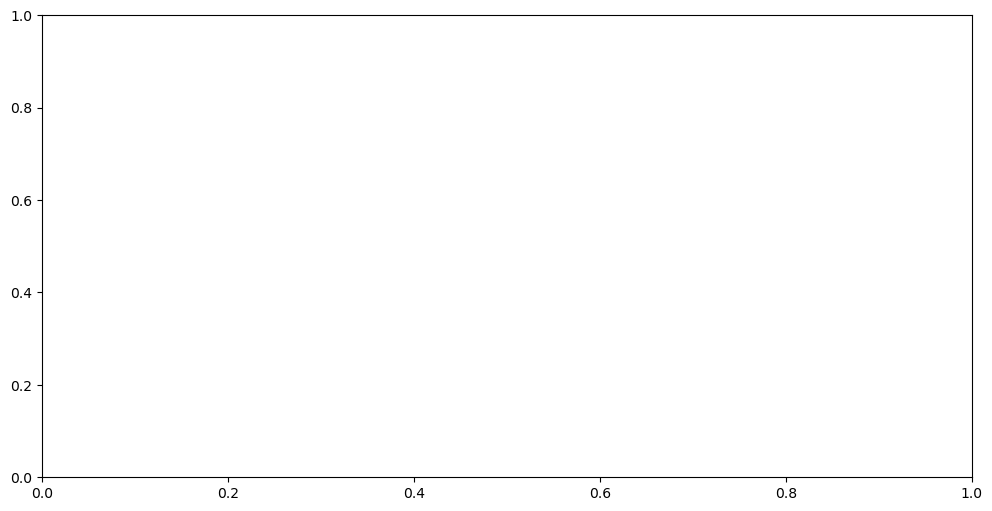

In [140]:
def trade_timing_PnL_graph(trade_results):
    
    # Getting the trade PnL for each full trade (not just partials)
    trade_pnl = trade_results.groupby('EntryTime')['PnL'].sum()  # Group by EntryTime (our "Trade ID") and sum PnL for each trade

    trade_pnl_hour = trade_pnl.groupby(trade_pnl.index.hour).mean()
    trade_pnl_minute = trade_pnl.groupby(trade_pnl.index.time).mean()
    print(trade_pnl_minute)
    # Next step: need to convert datetime.time into float for matplotlib to plot properly

    # Plot cumulative PnL at different times
    plt.figure(figsize=(12, 6))
    plt.plot(trade_pnl_minute.index, trade_pnl_minute, label = 'trade_pnl_minute', color = 'blue')
    
    # Add titles and labels
    plt.title('trade_pnl_minute')
    plt.xlabel('time')
    plt.ylabel('PnL')
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

    return trade_pnl_hour

trade_timing_PnL_graph(combined_results_TSLA_3y_9am_4pm)

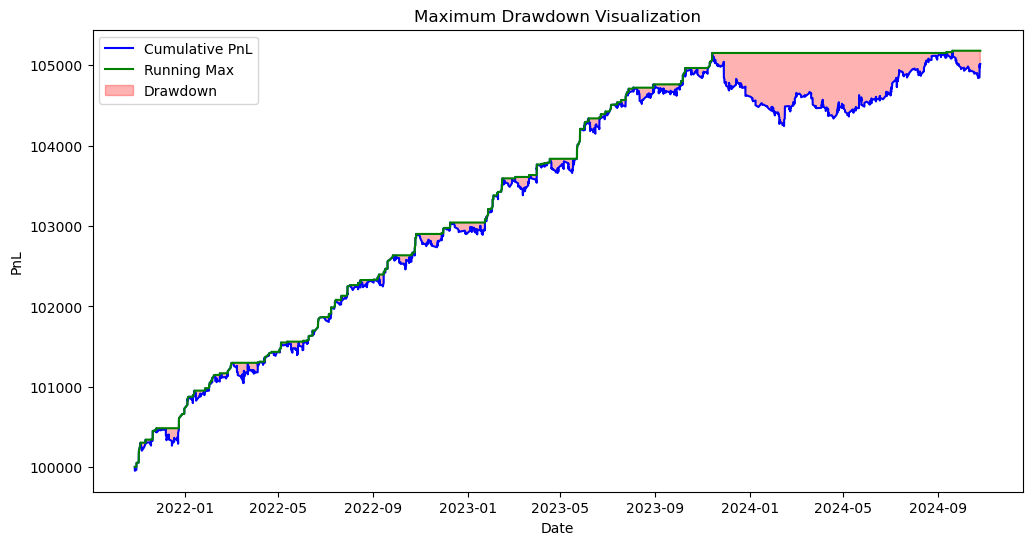

,Strategy ID,Net Profit ($),Pos Trades Total ($),Neg Trades Total ($),Profit Factor,# Winning Trades,# Total Trades,Win Ratio,R:R Ratio,Expected Profitability (also EV) ($),...,Biggest Winner ($),Biggest Loser ($),Peak Equity ($),Trough Equity ($),Max Win Streak,Max Lose Streak,Max Drawdown (%),Avg Amount Used for Trade ($),Max Amount Used for Trade ($),Avg Holding Time (min)
0,BHOD Test Strategy,5016.2,21787.49,-16771.29,1.299,1080,1896,0.57,1.019,2.646,...,48.9,-27.5,5181.385,-44.225,18,8,-0.865,9597.011,46670.85,9.066


In [138]:
metrics_table(combined_results_TSLA_3y_9am_4pm, 'BHOD Test Strategy', show_drawdown_plot = True)

In [139]:
partials_table_v2(combined_results_TSLA_3y_9am_4pm)

(                                        Trade Status  Frequency  \
 Trade_Position_Adjusted                                           
 0.1                          Didn't reach tp level 1        816   
 0.5                      EOD close before tp level 1          3   
 1.0                                   Hit tp level 1       1077   
 1.1                          Didn't reach tp level 2        513   
 1.5                      EOD close before tp level 2          7   
 2.0                                   Hit tp level 2        557   
 2.1                          Didn't reach tp level 3        163   
 3.0                                   Hit tp level 3        394   
 
                          Avg Gain at TP Level  Total Gain at TP Level  
 Trade_Position_Adjusted                                                
 0.1                                -20.553051              -16771.290  
 0.5                                  5.323333                  15.970  
 1.0                      

# Vectorized Backtesting in Function Format (with copied dfs and FULL timing analysis)

In [440]:
# BHOD Vectorized Strategy in function format with copied dfs for analysis (and FULL time analysis)

def BHOD_Vec_v1_w_copied_dfs_and_full_timing(partitioned_data, var_dict):

    # Making a copy of the partitioned data
    df_1min = partitioned_data.copy()

    # Part 1: Initializing variables and indicators to get the final BHOD condition:

    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (df_1min.time >= pd.to_datetime(start_time).time()) & (df_1min.time <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min.volume_MA * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min.Volume >= df_1min.w_volume_threshold)

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = df_1min.HOD.shift(1)  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min.High > df_1min.prev_HOD

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)


    # Part 2: Initializing entry and exit variables to ultimately perform a trade:

    # Setting risk per trade in dollars (R)
    risk_per_trade_R = var_dict['Risk per Trade R ($)']
    
    # Introducing slippage (from bid-ask spread) in
    BA_spread = var_dict['Bid-Ask Spread ($)']
    slippage = BA_spread / 2
    
    # Max trade amount:
    max_trade_amount = var_dict['Max Trade Amount ($)']
    
    # Some useful metrics that will be used to check whether trade is above max trade amount
    _sep_w_slippage = 0.0
    _BHOD_SL = 0.0
    _dynamic_shares_total = 0.0
    _total_entry_amt = 0.0

    # Setting partials and percent take profit (using R:R-based TP)
    use_1st_RR_tp = var_dict['Use 1st R tp']
    set_1st_R_partial = var_dict['Set 1st R partial (#)']
    set_1st_R_percent = var_dict['Set 1st R percent (%)']
    use_2nd_RR_tp = var_dict['Use 2nd R tp']
    set_2nd_R_partial = var_dict['Set 2nd R partial (#)']
    set_2nd_R_percent = var_dict['Set 2nd R percent (%)']
    use_3rd_RR_tp = var_dict['Use 3rd R tp']
    set_3rd_R_partial = var_dict['Set 3rd R partial (#)']
    set_3rd_R_percent = var_dict['Set 3rd R percent (%)']
    use_4th_RR_tp = var_dict['Use 4th R tp']
    set_4th_R_partial = var_dict['Set 4th R partial (#)']
    set_4th_R_percent = var_dict['Set 4th R percent (%)']
    
    # Initializing dynamic shares calculation
    dynamic_shares_total = 0
    dynamic_1st_R_shares = 0
    dynamic_2nd_R_shares = 0
    dynamic_3rd_R_shares = 0
    dynamic_4th_R_shares = 0

    # Initializing when to move stop loss
    move_SL_after_1st_tp = var_dict['Move SL After 1st tp']
    move_SL_after_2nd_tp = var_dict['Move SL After 2nd tp']
    move_SL_after_3rd_tp = var_dict['Move SL After 3rd tp']


    # Part 3: Initializing columns to run the backtest:

    # Setting full entry condition that includes test for max entry amount and entry bar for unique entry ID
    df_1min['full_entry_condition'] = False
    df_1min['entry_bar_ID'] = np.nan
    
    # Initializing stored entry price (sep) with slippage with NaN
    df_1min['sep_w_slippage'] = np.nan
    
    # Defining the previous midpoint and individual stop losses
    # (For BHOD, sl is at the lower of the current CS low or at the midpoint of the open and close of the previous CS)
    prev_midpoint_series = (df_1min.Open.shift(1) + df_1min.Close.shift(1)) / 2
    df_1min['indiv_sl'] = np.minimum(prev_midpoint_series, df_1min.Low)
    
    # Initializing true BHOD stop losses and breakeven price
    df_1min['BHOD_SL'] = np.nan
    df_1min['BHOD_BE'] = np.nan
    
    # Initializing the take profit prices
    df_1min['TP_Long_1st_R_price'] = np.nan
    df_1min['TP_Long_2nd_R_price'] = np.nan
    df_1min['TP_Long_3rd_R_price'] = np.nan
    df_1min['TP_Long_4th_R_price'] = np.nan
    
    # Setting selling conditions
    df_1min['hit_SL'] = False
    df_1min['hit_BE'] = False
    df_1min['hit_1st_TP'] = False
    df_1min['hit_2nd_TP'] = False
    df_1min['hit_3rd_TP'] = False
    df_1min['hit_4th_TP'] = False
    
    # Initializing take profit indicators  
    df_1min['hit_SL_cum'] = 0.0
    df_1min['hit_BE_cum'] = 0.0
    df_1min['hit_1st_TP_cum'] = 0.0
    df_1min['hit_2nd_TP_cum'] = 0.0
    df_1min['hit_3rd_TP_cum'] = 0.0
    df_1min['hit_4th_TP_cum'] = 0.0
    
    # Initializing the shares with NaN and entry/exit amounts with 0
    df_1min['shares_entry'] = np.nan
    df_1min['shares'] = np.nan
    df_1min['total_entry_amt'] = 0.0
    df_1min['exit_amt_sl'] = 0.0
    df_1min['exit_amt_be'] = 0.0
    df_1min['exit_amt_1st_tp'] = 0.0
    df_1min['exit_amt_2nd_tp'] = 0.0
    df_1min['exit_amt_3rd_tp'] = 0.0
    df_1min['exit_amt_4th_tp'] = 0.0
    df_1min['exit_amt_3_55_pm'] = 0.0
    df_1min['total_exit_amt'] = 0.0
    df_1min['total_txn_amt'] = 0.0
    df_1min['random'] = 0.0


    # Part 4: Getting potential entry points and executing the trades
    global total_s1_time
    global total_s2_time
    global total_s3_time
    global total_s4_time
    global total_s4_1_time
    global total_s4_2_time
    global total_s4_3_time
    global total_s4_4_time
    global total_s5_time
    global total_s6_time
    global total_s7_time

    l_total_s1_time = 0.0
    l_total_s2_time = 0.0
    l_total_s3_time = 0.0
    l_total_s3_1_time = 0.0
    l_total_s3_2_time = 0.0
    l_total_s3_3_time = 0.0
    l_total_s4_time = 0.0
    l_total_s4_1_time = 0.0
    l_total_s4_2_time = 0.0
    l_total_s4_3_time = 0.0
    l_total_s4_4_time = 0.0
    l_total_s5_time = 0.0
    l_total_s5_1_time = 0.0
    l_total_s5_2_time = 0.0
    l_total_s5_3_time = 0.0
    l_total_s5_4_time = 0.0
    l_total_s6_time = 0.0
    l_total_s6_1_time = 0.0
    l_total_s6_1_1_time = 0.0
    l_total_s6_1_1_1_time = 0.0
    l_total_s6_1_1_2_time = 0.0
    l_total_s6_1_1_3_time = 0.0
    l_total_s6_1_2_time = 0.0
    l_total_s6_1_3_time = 0.0
    l_total_s6_1_4_time = 0.0
    l_total_s6_1_4_1_time = 0.0
    l_total_s6_1_4_2_time = 0.0
    l_total_s6_1_4_3_time = 0.0
    l_total_s6_1_4_4_time = 0.0
    l_total_s6_1_5_time = 0.0
    l_total_s6_1_6_time = 0.0
    l_total_s6_2_time = 0.0
    l_total_s6_3_time = 0.0
    l_total_s6_4_time = 0.0
    l_total_s7_time = 0.0
    
    # Getting the list of all potential entry points:
    potential_entry_timestamps = df_1min[df_1min.combined_BHOD_condition].index.tolist()
    
    for timestamp in potential_entry_timestamps:
    
        # Step 0: Checking to see if shares is NaN (if it is, that means we're in a trade, so skip this candle)
        if pd.notna(df_1min.loc[timestamp, 'shares']):
            continue
        
        # Step 1: Initializing some variables to make things easier
        s1_start = time.time()
        
        # Getting a copy of just the timestamp row (observation) to make operations faster
        timestamp_row = df_1min.loc[timestamp].copy(deep = True)

        s1_time = time.time() - s1_start
        # Step 2: Setting the entry price, stop loss, and take profit prices for this entry row (Series)
        s2_start = time.time()
    
        # Setting variables for max entry amount condition (to be used later if this condition is met)
        _sep_w_slippage = np.minimum((timestamp_row.prev_HOD + slippage), timestamp_row.High)  # Setting stored entry price with slippage
        _BHOD_SL = timestamp_row.indiv_sl  # Setting the true BHOD sl for this timestamp
        _dynamic_shares_total = int(np.floor(risk_per_trade_R / (_sep_w_slippage - _BHOD_SL)))  # Setting the total dynamic shares
        _total_entry_amt = _dynamic_shares_total * _sep_w_slippage  # Setting total purchase amount
    
        # Before doing anything else, checking to see if entry will be larger than the specified max entry amount
        if _total_entry_amt > max_trade_amount:
            s2_time = time.time() - s2_start
            continue
        timestamp_row['full_entry_condition'] = True  # Setting full entry condition to True if max entry amount condition is met
    
        # Setting entry bar as the unique ID
        timestamp_row['entry_bar_ID'] = timestamp.timestamp()
        
        # Filling in the stored entry price with slippage, BHOD SL, and BHOD BE for this timestamp
        timestamp_row['sep_w_slippage'] = _sep_w_slippage
        timestamp_row['BHOD_SL'] = _BHOD_SL
        timestamp_row['BHOD_BE'] = _sep_w_slippage
    
        # Setting the take profit prices for this timestamp
        timestamp_row['TP_Long_1st_R_price'] = (
            (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_1st_R_partial + timestamp_row.sep_w_slippage)
        timestamp_row['TP_Long_2nd_R_price'] = (
            (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_2nd_R_partial + timestamp_row.sep_w_slippage)
        timestamp_row['TP_Long_3rd_R_price'] = (
            (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_3rd_R_partial + timestamp_row.sep_w_slippage)
        timestamp_row['TP_Long_4th_R_price'] = (
            (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_4th_R_partial + timestamp_row.sep_w_slippage)

        s2_time = time.time() - s2_start
        # Step 3: Setting share sizes for everything
        s3_start = time.time()

        s3_1_start = time.time()
        # Setting true dynamic shares total variable as the test variable for dynamic shares total
        dynamic_shares_total = _dynamic_shares_total
        
        # Setting take profit share sizes
        if use_1st_RR_tp:
            dynamic_1st_R_shares = int(np.floor(dynamic_shares_total * set_1st_R_percent / 100))
        # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that
        # (instead of doing it all at once in the beginning)
        if use_2nd_RR_tp:
            dynamic_2nd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares) * set_2nd_R_percent / (100 - set_1st_R_percent))  )
        # 3R follows suit
        if use_3rd_RR_tp:
            dynamic_3rd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares) * 
                set_3rd_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent)) )
        # 4R follows suit as well (if applied)
        if use_4th_RR_tp:
            dynamic_4th_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares) * 
                set_4th_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent - set_3rd_R_percent))  )
    
        s3_1_time = time.time() - s3_1_start
        # Setting entry and final shares to the default
        s3_2_start = time.time()
        timestamp_row['shares_entry'] = dynamic_shares_total
        timestamp_row['shares'] = dynamic_shares_total
    
        # Setting total purchase amount
        timestamp_row['total_entry_amt'] = _total_entry_amt * -1

        s3_2_time = time.time() - s3_2_start
        # Putting the timestamp_row back into the original dataframe
        s3_3_start = time.time()
        df_1min.loc[timestamp] = timestamp_row

        s3_3_time = time.time() - s3_3_start
        s3_time = time.time() - s3_start
        # Step 4: Forward filling the sl, be, and tp prices for the day (to save time and space)
        s4_start = time.time()
    
        # Creating (copied) slice of df from just the entry to EOD to save on time and space
        s4_1_start = time.time()
        entry_to_EOD = df_1min.loc[((df_1min.index >= timestamp) & (df_1min.date == timestamp.date()))].copy(deep = True)

        s4_1_time = time.time() - s4_1_start
        # Forward filling unique entry bar string (entry ID)
        s4_2_start = time.time()
        entry_to_EOD['entry_bar_ID'] = entry_to_EOD['entry_bar_ID'].ffill()

        s4_2_time = time.time() - s4_2_start
        # Forward filling prices
        s4_3_start = time.time()
        entry_to_EOD['sep_w_slippage'] = entry_to_EOD['sep_w_slippage'].ffill()
        entry_to_EOD['BHOD_SL'] = entry_to_EOD['BHOD_SL'].ffill()
        entry_to_EOD['BHOD_BE'] = entry_to_EOD['BHOD_BE'].ffill()
        entry_to_EOD['TP_Long_1st_R_price'] = entry_to_EOD['TP_Long_1st_R_price'].ffill()
        entry_to_EOD['TP_Long_2nd_R_price'] = entry_to_EOD['TP_Long_2nd_R_price'].ffill()
        entry_to_EOD['TP_Long_3rd_R_price'] = entry_to_EOD['TP_Long_3rd_R_price'].ffill()
        entry_to_EOD['TP_Long_4th_R_price'] = entry_to_EOD['TP_Long_4th_R_price'].ffill()

        s4_3_time = time.time() - s4_3_start
        # Forward filling the shares as well
        s4_4_start = time.time()
        entry_to_EOD['shares'] = entry_to_EOD['shares'].ffill()

        s4_4_time = time.time() - s4_4_start
        s4_time = time.time() - s4_start
        # Step 5: Checking selling conditions and setting indicators
        s5_start = time.time()
    
        # If price hits any of the tp conditions, set those to True
        s5_1_start = time.time()
        entry_to_EOD.loc[(entry_to_EOD.High >= entry_to_EOD.TP_Long_1st_R_price), 'hit_1st_TP'] = True
        entry_to_EOD.loc[(entry_to_EOD.High >= entry_to_EOD.TP_Long_2nd_R_price), 'hit_2nd_TP'] = True
        entry_to_EOD.loc[(entry_to_EOD.High >= entry_to_EOD.TP_Long_3rd_R_price), 'hit_3rd_TP'] = True
        entry_to_EOD.loc[(entry_to_EOD.High >= entry_to_EOD.TP_Long_4th_R_price), 'hit_4th_TP'] = True

        s5_1_time = time.time() - s5_1_start
        # Using the df.expanding() function to get expanding (window rolling) indicators
        s5_2_start = time.time()
        entry_to_EOD['hit_1st_TP_cum'] = entry_to_EOD.hit_1st_TP.expanding(1).sum()
        entry_to_EOD['hit_2nd_TP_cum'] = entry_to_EOD.hit_2nd_TP.expanding(1).sum()
        entry_to_EOD['hit_3rd_TP_cum'] = entry_to_EOD.hit_3rd_TP.expanding(1).sum()
        entry_to_EOD['hit_4th_TP_cum'] = entry_to_EOD.hit_4th_TP.expanding(1).sum()

        s5_2_time = time.time() - s5_2_start
        # If price falls below SL, set hit_SL to True
        s5_3_start = time.time()
        entry_to_EOD.loc[(entry_to_EOD.Low < entry_to_EOD.BHOD_SL), 'hit_SL'] = True
    
        # If price falls below BE and 1st tp has been hit (and it's not the same CS as the entry), set hit_BE to True
        entry_to_EOD.loc[((entry_to_EOD.Low < entry_to_EOD.BHOD_BE) & (entry_to_EOD.hit_1st_TP_cum > 0) &
            (entry_to_EOD.index != timestamp)), 'hit_BE'] = True

        s5_3_time = time.time() - s5_3_start
        # Getting expanding indicators for stop loss and breakeven
        s5_4_start = time.time()
        entry_to_EOD['hit_SL_cum'] = entry_to_EOD.hit_SL.expanding(1).sum()
        entry_to_EOD['hit_BE_cum'] = entry_to_EOD.hit_BE.expanding(1).sum()

        s5_4_time = time.time() - s5_4_start
        s5_time = time.time() - s5_start
        # Step 6: Removing the shares based on conditions and adding in total prices
        s6_start = time.time()
    
        # Getting exit amount type for each condition (checking current flag == 1, prior indicator == 0, & sl != 1)
        s6_1_start = time.time()
        try:
            cond_1st_tp_1 = ((entry_to_EOD.hit_1st_TP_cum == 1) & (entry_to_EOD.hit_1st_TP_cum.shift(1, fill_value = 0) == 0))
            cond_1st_tp_2 = ~(entry_to_EOD.hit_SL_cum == 1)
            cond_1st_tp_f = cond_1st_tp_1 & cond_1st_tp_2  # "Full" condition 1
            entry_to_EOD.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = entry_to_EOD.loc[timestamp, 'TP_Long_1st_R_price'] * dynamic_1st_R_shares
        except: pass
        try:
            cond_2nd_tp = ((entry_to_EOD.hit_2nd_TP_cum == 1) & (entry_to_EOD.hit_2nd_TP_cum.shift(1, fill_value = 0) == 0) &
                ~((entry_to_EOD.hit_SL_cum == 1) & cond_1st_tp_1) )
                # Last condition above (starting with ~ ) is basically saying, "Yes if NOT hitting sl and FIRST 1st tp on this CS as well"
                # Note to self to potentially change this to be any tp level later on; could add another condition specifying when to do it
            entry_to_EOD.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = entry_to_EOD.loc[timestamp, 'TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
        except: pass
        try:
            cond_3rd_tp = ((entry_to_EOD.hit_3rd_TP_cum == 1) & (entry_to_EOD.hit_3rd_TP_cum.shift(1, fill_value = 0) == 0) &
                ~((entry_to_EOD.hit_SL_cum == 1) & cond_1st_tp_1) )
            entry_to_EOD.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = entry_to_EOD.loc[timestamp, 'TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
        except: pass
        try:
            cond_4th_tp = ((entry_to_EOD.hit_4th_TP_cum == 1) & (entry_to_EOD.hit_4th_TP_cum.shift(1, fill_value = 0) == 0) &
                ~((entry_to_EOD.hit_SL_cum == 1) & cond_1st_tp_1) )
            entry_to_EOD.loc[cond_4th_tp, 'exit_amt_4th_tp'] = entry_to_EOD.loc[timestamp, 'TP_Long_4th_R_price'] * dynamic_4th_R_shares
        except: pass
        try:  # Putting SL condition here because shares MUST go to 0 first if the right conditions are triggered
            cond_sl = ((entry_to_EOD.hit_SL_cum == 1) & (entry_to_EOD.hit_SL_cum.shift(1, fill_value = 0) == 0) &
                (entry_to_EOD.hit_1st_TP_cum.shift(1, fill_value = 0) == 0))
                # Need last condition above b/c SL ONLY triggers before/when 1st tp condition is met
            entry_to_EOD.loc[cond_sl, 'exit_amt_sl'] = (np.maximum(entry_to_EOD.loc[timestamp, 'BHOD_SL'] - slippage,
                entry_to_EOD.loc[cond_sl, 'Low'].iloc[0]) * entry_to_EOD.loc[cond_sl, 'shares'].iloc[0])
        except: pass

        s6_1_time = time.time() - s6_1_start
        # Removing shares if ### tp is hit (rolling)
        s6_2_start = time.time()
        entry_to_EOD.loc[(entry_to_EOD.hit_1st_TP_cum > 0), 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares)
        entry_to_EOD.loc[(entry_to_EOD.hit_2nd_TP_cum > 0), 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        entry_to_EOD.loc[(entry_to_EOD.hit_3rd_TP_cum > 0), 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        entry_to_EOD.loc[(entry_to_EOD.hit_4th_TP_cum > 0), 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)
    
        # Breakeven condition check (since it relies on the shares already calculated)
        try:
            cond_be = ((entry_to_EOD.hit_BE_cum == 1) & (entry_to_EOD.hit_BE_cum.shift(1, fill_value = 0) == 0) &
                ~((entry_to_EOD.hit_SL_cum == 1) & cond_1st_tp_1) )
                # Again, adding the above condition b/c SL trumps BE ONLY when they happen at the same time ALONG with 1st tp
            entry_to_EOD.loc[cond_be, 'exit_amt_be'] = (np.maximum(entry_to_EOD.loc[timestamp, 'BHOD_BE'] - slippage,
                entry_to_EOD.loc[cond_be, 'Low'].iloc[0]) * entry_to_EOD.loc[cond_be, 'shares'].iloc[0])
        except: pass
    
        # Setting shares to 0 if either sl or be is hit (need to come after so we can do sl/be exit amount calculations first)
        entry_to_EOD.loc[((entry_to_EOD.hit_SL_cum > 0) | (entry_to_EOD.hit_BE_cum > 0)), 'shares'] = 0.0

        s6_2_time = time.time() - s6_2_start
        # Getting out completely at 3:55pm at the Close price
        s6_3_start = time.time()
        exit_cond_3_55_pm = (entry_to_EOD.time == pd.to_datetime('15:55:00').time())
        entry_to_EOD.loc[(exit_cond_3_55_pm & (entry_to_EOD.shares != 0)), 'exit_amt_3_55_pm'] = (  # Setting total exit amount at 3:55pm
            entry_to_EOD.loc[exit_cond_3_55_pm, 'Close'].iloc[0] * entry_to_EOD.loc[exit_cond_3_55_pm, 'shares'].iloc[0])
        entry_to_EOD.loc[exit_cond_3_55_pm, 'shares'] = 0.0  # Setting shares to 0 at 3:55pm

        s6_3_time = time.time() - s6_3_start
        # Adding in total exit amounts for selling (only when there's an exit that should be made)
        s6_4_start = time.time()
        cond_shares_change = (entry_to_EOD.shares != entry_to_EOD.shares.shift(1))
        # Btw, the condition above even works when full exiting on 1st CS b/c the shift(1) of the first row is NaN, and 0 != NaN
        entry_to_EOD.loc[cond_shares_change, 'total_exit_amt'] = (entry_to_EOD[['exit_amt_1st_tp', 'exit_amt_2nd_tp',
            'exit_amt_3rd_tp', 'exit_amt_4th_tp', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_3_55_pm']].sum(axis = 1))
        
        # Getting the total transaction amounts
        entry_to_EOD['total_txn_amt'] = entry_to_EOD.total_entry_amt + entry_to_EOD.total_exit_amt

        s6_4_time = time.time() - s6_4_start
        s6_time = time.time() - s6_start
        # Step 7: Resetting everything after the final exit to 0 and putting specific rows back
        s7_start = time.time()
    
        # Getting the first 0 shares index to reset
        first_zero_shares_index = (entry_to_EOD['shares'] == 0).idxmax() if (entry_to_EOD['shares'] == 0).any() else None

        # Re-inputting the entry_to_EOD df back into the main df_1min df
        df_1min.loc[timestamp:first_zero_shares_index] = entry_to_EOD
        s7_time = time.time() - s7_start

        total_s1_time += s1_time
        total_s2_time += s2_time
        total_s3_time += s3_time
        total_s4_time += s4_time
        total_s4_1_time += s4_1_time
        total_s4_2_time += s4_2_time
        total_s4_3_time += s4_3_time
        total_s4_4_time += s4_4_time
        total_s5_time += s5_time
        total_s6_time += s6_time
        total_s7_time += s7_time
        
        l_total_s1_time += s1_time
        l_total_s2_time += s2_time
        l_total_s3_time += s3_time
        l_total_s3_1_time += s3_1_time
        l_total_s3_2_time += s3_2_time
        l_total_s3_3_time += s3_3_time
        l_total_s4_time += s4_time
        l_total_s4_1_time += s4_1_time
        l_total_s4_2_time += s4_2_time
        l_total_s4_3_time += s4_3_time
        l_total_s4_4_time += s4_4_time
        l_total_s5_time += s5_time
        l_total_s5_1_time += s5_1_time
        l_total_s5_2_time += s5_2_time
        l_total_s5_3_time += s5_3_time
        l_total_s5_4_time += s5_4_time
        l_total_s6_time += s6_time
        l_total_s6_1_time += s6_1_time
        # l_total_s6_1_1_time += s6_1_1_time
        # l_total_s6_1_1_1_time += s6_1_1_1_time
        # l_total_s6_1_1_2_time += s6_1_1_2_time
        # l_total_s6_1_1_3_time += s6_1_1_3_time
        # l_total_s6_1_2_time += s6_1_2_time
        # l_total_s6_1_3_time += s6_1_3_time
        # l_total_s6_1_4_time += s6_1_4_time
        # l_total_s6_1_4_1_time += s6_1_4_1_time
        # l_total_s6_1_4_2_time += s6_1_4_2_time
        # l_total_s6_1_4_3_time += s6_1_4_3_time
        # l_total_s6_1_4_4_time += s6_1_4_4_time
        # l_total_s6_1_5_time += s6_1_5_time
        # l_total_s6_1_6_time += s6_1_6_time
        l_total_s6_2_time += s6_2_time
        l_total_s6_3_time += s6_3_time
        l_total_s6_4_time += s6_4_time
        l_total_s7_time += s7_time
    

    # Part 5: Returning the final dataframe:
    # return df_1min.groupby('date')['Volume'].sum()

    # Time testing    
    return (l_total_s1_time, l_total_s2_time, l_total_s3_time, l_total_s3_1_time, l_total_s3_2_time, l_total_s3_3_time, l_total_s4_time,
            l_total_s4_1_time, l_total_s4_2_time, l_total_s4_3_time, l_total_s4_4_time, l_total_s5_time, l_total_s5_1_time,
            l_total_s5_2_time, l_total_s5_3_time, l_total_s5_4_time, l_total_s6_time, l_total_s6_1_time, l_total_s6_2_time,
            l_total_s6_3_time, l_total_s6_4_time, l_total_s7_time)

# Total times
total_s1_time = 0
total_s2_time = 0
total_s3_time = 0
total_s4_time = 0
total_s4_1_time = 0
total_s4_2_time = 0
total_s4_3_time = 0
total_s4_4_time = 0
total_s5_time = 0
total_s6_time = 0
total_s7_time = 0

# Vectorized Backtesting in Function Format (WITHOUT copied dfs but a FULLER timing analysis)

In [1841]:
# BHOD Vectorized Strategy in function format with FULLER timing analysis

def BHOD_Vec_v1_fuller_timing(partitioned_data, var_dict):

    # Making a copy of the partitioned data
    df_1min = partitioned_data.copy()

    # Part 1: Initializing variables and indicators to get the final BHOD condition:

    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (df_1min.time >= pd.to_datetime(start_time).time()) & (df_1min.time <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min.volume_MA * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min.Volume >= df_1min.w_volume_threshold)

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = df_1min.HOD.shift(1)  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min.High > df_1min.prev_HOD

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)


    # Part 2: Initializing entry and exit variables to ultimately perform a trade:

    # Setting risk per trade in dollars (R)
    risk_per_trade_R = var_dict['Risk per Trade R ($)']
    
    # Introducing slippage (from bid-ask spread) in
    BA_spread = var_dict['Bid-Ask Spread ($)']
    slippage = BA_spread / 2
    
    # Max trade amount:
    max_trade_amount = var_dict['Max Trade Amount ($)']
    
    # Some useful metrics that will be used to check whether trade is above max trade amount
    _sep_w_slippage = 0.0
    _BHOD_SL = 0.0
    _dynamic_shares_total = 0.0
    _total_entry_amt = 0.0

    # Setting partials and percent take profit (using R:R-based TP)
    use_1st_RR_tp = var_dict['Use 1st R tp']
    set_1st_R_partial = var_dict['Set 1st R partial (#)']
    set_1st_R_percent = var_dict['Set 1st R percent (%)']
    use_2nd_RR_tp = var_dict['Use 2nd R tp']
    set_2nd_R_partial = var_dict['Set 2nd R partial (#)']
    set_2nd_R_percent = var_dict['Set 2nd R percent (%)']
    use_3rd_RR_tp = var_dict['Use 3rd R tp']
    set_3rd_R_partial = var_dict['Set 3rd R partial (#)']
    set_3rd_R_percent = var_dict['Set 3rd R percent (%)']
    use_4th_RR_tp = var_dict['Use 4th R tp']
    set_4th_R_partial = var_dict['Set 4th R partial (#)']
    set_4th_R_percent = var_dict['Set 4th R percent (%)']
    
    # Initializing dynamic shares calculation
    dynamic_shares_total = 0
    dynamic_1st_R_shares = 0
    dynamic_2nd_R_shares = 0
    dynamic_3rd_R_shares = 0
    dynamic_4th_R_shares = 0

    # Initializing when to move stop loss
    move_SL_after_1st_tp = var_dict['Move SL After 1st tp']
    move_SL_after_2nd_tp = var_dict['Move SL After 2nd tp']
    move_SL_after_3rd_tp = var_dict['Move SL After 3rd tp']


    # Part 3: Initializing columns to run the backtest:

    # Setting full entry condition that includes test for max entry amount and entry bar for unique entry ID
    df_1min['full_entry_condition'] = False
    df_1min['entry_bar_ID'] = np.nan
    
    # Initializing stored entry price (sep) with slippage with NaN
    df_1min['sep_w_slippage'] = np.nan
    
    # Defining the previous midpoint and individual stop losses
    # (For BHOD, sl is at the lower of the current CS low or at the midpoint of the open and close of the previous CS)
    prev_midpoint_series = (df_1min.Open.shift(1) + df_1min.Close.shift(1)) / 2
    df_1min['indiv_sl'] = np.minimum(prev_midpoint_series, df_1min.Low)
    
    # Initializing true BHOD stop losses and breakeven price
    df_1min['BHOD_SL'] = np.nan
    df_1min['BHOD_BE'] = np.nan
    
    # Initializing the take profit prices
    df_1min['TP_Long_1st_R_price'] = np.nan
    df_1min['TP_Long_2nd_R_price'] = np.nan
    df_1min['TP_Long_3rd_R_price'] = np.nan
    df_1min['TP_Long_4th_R_price'] = np.nan
    
    # Setting selling conditions
    df_1min['hit_SL'] = False
    df_1min['hit_BE'] = False
    df_1min['hit_1st_TP'] = False
    df_1min['hit_2nd_TP'] = False
    df_1min['hit_3rd_TP'] = False
    df_1min['hit_4th_TP'] = False
    
    # Initializing take profit indicators  
    df_1min['hit_SL_cum'] = 0.0
    df_1min['hit_BE_cum'] = 0.0
    df_1min['hit_1st_TP_cum'] = 0.0
    df_1min['hit_2nd_TP_cum'] = 0.0
    df_1min['hit_3rd_TP_cum'] = 0.0
    df_1min['hit_4th_TP_cum'] = 0.0
    
    # Initializing the shares with NaN and entry/exit amounts with 0
    df_1min['shares_entry'] = np.nan
    df_1min['shares'] = np.nan
    df_1min['total_entry_amt'] = 0.0
    df_1min['exit_amt_sl'] = 0.0
    df_1min['exit_amt_be'] = 0.0
    df_1min['exit_amt_1st_tp'] = 0.0
    df_1min['exit_amt_2nd_tp'] = 0.0
    df_1min['exit_amt_3rd_tp'] = 0.0
    df_1min['exit_amt_4th_tp'] = 0.0
    df_1min['exit_amt_3_55_pm'] = 0.0
    df_1min['total_exit_amt'] = 0.0
    df_1min['total_txn_amt'] = 0.0
    df_1min['random'] = 0.0


    # Part 4: Getting potential entry points and executing the trades
    global total_s1_time
    global total_s2_time
    global total_s3_time
    global total_s4_time
    global total_s4_1_time
    global total_s4_2_time
    global total_s4_3_time
    global total_s4_4_time
    global total_s5_time
    global total_s6_time
    global total_s7_time

    l_total_s1_time = 0.0
    l_total_s2_time = 0.0
    l_total_s3_time = 0.0
    l_total_s3_1_time = 0.0
    l_total_s3_2_time = 0.0
    l_total_s3_3_time = 0.0
    l_total_s4_time = 0.0
    l_total_s4_1_time = 0.0
    l_total_s4_2_time = 0.0
    l_total_s4_3_time = 0.0
    l_total_s4_4_time = 0.0
    l_total_s5_time = 0.0
    l_total_s5_1_time = 0.0
    l_total_s5_2_time = 0.0
    l_total_s5_3_time = 0.0
    l_total_s5_4_time = 0.0
    l_total_s6_time = 0.0
    l_total_s6_1_time = 0.0
    l_total_s6_1_1_time = 0.0
    l_total_s6_1_1_1_time = 0.0
    l_total_s6_1_1_2_time = 0.0
    l_total_s6_1_1_3_time = 0.0
    l_total_s6_1_2_time = 0.0
    l_total_s6_1_3_time = 0.0
    l_total_s6_1_4_time = 0.0
    l_total_s6_1_4_1_time = 0.0
    l_total_s6_1_4_2_time = 0.0
    l_total_s6_1_4_3_time = 0.0
    l_total_s6_1_4_4_time = 0.0
    l_total_s6_1_5_time = 0.0
    l_total_s6_1_6_time = 0.0
    l_total_s6_1_7_time = 0.0
    l_total_s6_1_8_time = 0.0
    l_total_s6_1_9_time = 0.0
    l_total_s6_2_time = 0.0
    l_total_s6_2_1_time = 0.0
    l_total_s6_2_2_time = 0.0
    l_total_s6_2_3_time = 0.0
    l_total_s6_2_4_time = 0.0
    l_total_s6_3_time = 0.0
    l_total_s6_4_time = 0.0
    l_total_s7_time = 0.0
    l_total_s7_1_time = 0.0
    l_total_s7_2_time = 0.0
    l_total_s7_3_time = 0.0
    
    
    # Getting the list of all potential entry points:
    potential_entry_timestamps = df_1min[df_1min.combined_BHOD_condition].index.tolist()
    
    for timestamp in potential_entry_timestamps:
    
        # Step 0: Checking to see if shares is NaN (if it is, that means we're in a trade, so skip this candle)
        if pd.notna(df_1min.loc[timestamp, 'shares']):
            continue
        
        # Step 1: Initializing some variables to make things easier
        s1_start = time.time()
        
        # Getting a copy of just the timestamp row (observation) to make operations faster
        timestamp_row = df_1min.loc[timestamp].copy(deep = True)

        s1_time = time.time() - s1_start
        # Step 2: Setting the entry price, stop loss, and take profit prices for this entry row (Series)
        s2_start = time.time()
    
        # Setting variables for max entry amount condition (to be used later if this condition is met)
        _sep_w_slippage = np.minimum((timestamp_row['prev_HOD'] + slippage), timestamp_row['High'])
        # ^Setting stored entry price with slippage
        _BHOD_SL = timestamp_row.indiv_sl  # Setting the true BHOD sl for this timestamp
        _dynamic_shares_total = int(np.floor(risk_per_trade_R / (_sep_w_slippage - _BHOD_SL)))  # Setting the total dynamic shares
        _total_entry_amt = _dynamic_shares_total * _sep_w_slippage  # Setting total purchase amount
    
        # Before doing anything else, checking to see if entry will be larger than the specified max entry amount
        if _total_entry_amt > max_trade_amount:
            s2_time = time.time() - s2_start
            continue
        timestamp_row['full_entry_condition'] = True  # Setting full entry condition to True if max entry amount condition is met
    
        # Setting entry bar as the unique ID
        timestamp_row['entry_bar_ID'] = timestamp.timestamp()
        
        # Filling in the stored entry price with slippage, BHOD SL, and BHOD BE for this timestamp
        timestamp_row['sep_w_slippage'] = _sep_w_slippage
        timestamp_row['BHOD_SL'] = _BHOD_SL
        timestamp_row['BHOD_BE'] = _sep_w_slippage
    
        # Setting the take profit prices for this timestamp
        entry_minus_SL = _sep_w_slippage - _BHOD_SL
        timestamp_row['TP_Long_1st_R_price'] = entry_minus_SL * set_1st_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_2nd_R_price'] = entry_minus_SL * set_2nd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_3rd_R_price'] = entry_minus_SL * set_3rd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_4th_R_price'] = entry_minus_SL * set_4th_R_partial + _sep_w_slippage

        # Old
        # timestamp_row['TP_Long_1st_R_price'] = (
        #     (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_1st_R_partial + timestamp_row.sep_w_slippage)
        # timestamp_row['TP_Long_2nd_R_price'] = (
        #     (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_2nd_R_partial + timestamp_row.sep_w_slippage)
        # timestamp_row['TP_Long_3rd_R_price'] = (
        #     (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_3rd_R_partial + timestamp_row.sep_w_slippage)
        # timestamp_row['TP_Long_4th_R_price'] = (
        #     (timestamp_row.sep_w_slippage - timestamp_row.BHOD_SL) * set_4th_R_partial + timestamp_row.sep_w_slippage)

        s2_time = time.time() - s2_start
        # Step 3: Setting share sizes for everything
        s3_start = time.time()

        s3_1_start = time.time()
        # Setting true dynamic shares total variable as the test variable for dynamic shares total
        dynamic_shares_total = _dynamic_shares_total
        
        # Setting take profit share sizes
        if use_1st_RR_tp:
            dynamic_1st_R_shares = int(np.floor(dynamic_shares_total * set_1st_R_percent / 100))
        # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that
        # (instead of doing it all at once in the beginning)
        if use_2nd_RR_tp:
            dynamic_2nd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares) * set_2nd_R_percent / (100 - set_1st_R_percent))  )
        # 3R follows suit
        if use_3rd_RR_tp:
            dynamic_3rd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares) * 
                set_3rd_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent)) )
        # 4R follows suit as well (if applied)
        if use_4th_RR_tp:
            dynamic_4th_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares) * 
                set_4th_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent - set_3rd_R_percent))  )

        s3_1_time = time.time() - s3_1_start
        # Setting entry and final shares to the default
        s3_2_start = time.time()
        timestamp_row['shares_entry'] = dynamic_shares_total
        timestamp_row['shares'] = dynamic_shares_total
    
        # Setting total purchase amount
        timestamp_row['total_entry_amt'] = _total_entry_amt * -1

        s3_2_time = time.time() - s3_2_start
        # Putting the timestamp_row back into the original dataframe (doing each cell individually because it's much faster)
        s3_3_start = time.time()
        for col in df_1min.columns:
            df_1min.at[timestamp, col] = timestamp_row[col]

        s3_3_time = time.time() - s3_3_start
        s3_time = time.time() - s3_start
        # Step 4: Forward filling the sl, be, and tp prices for the day (to save time and space)
        s4_start = time.time()
    
        # Creating condition to just check the timestamps from entry to EOD
        s4_1_start = time.time()
        cond_ent_EOD = (df_1min.index >= timestamp) & (df_1min.date == timestamp.date())

        s4_1_time = time.time() - s4_1_start
        # Forward filling unique entry bar string (entry ID) and prices
        s4_2_start = time.time()
        df_1min.loc[cond_ent_EOD, 'entry_bar_ID'] = df_1min['entry_bar_ID'].ffill()
        df_1min.loc[cond_ent_EOD, 'sep_w_slippage'] = df_1min['sep_w_slippage'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_SL'] = df_1min['BHOD_SL'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_BE'] = df_1min['BHOD_BE'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_1st_R_price'] = df_1min['TP_Long_1st_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_2nd_R_price'] = df_1min['TP_Long_2nd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_3rd_R_price'] = df_1min['TP_Long_3rd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_4th_R_price'] = df_1min['TP_Long_4th_R_price'].ffill()

        s4_2_time = time.time() - s4_2_start
        s4_3_start = time.time()
        
        s4_3_time = time.time() - s4_3_start
        # Forward filling the shares as well
        s4_4_start = time.time()
        df_1min.loc[cond_ent_EOD, 'shares'] = df_1min['shares'].ffill()

        s4_4_time = time.time() - s4_4_start
        s4_time = time.time() - s4_start
        # Step 5: Checking selling conditions and setting indicators
        s5_start = time.time()
    
        # If price hits any of the tp conditions, set those to True
        s5_1_start = time.time()
        hit_TP_Long_1st_R_price = (df_1min['High'] >= df_1min['TP_Long_1st_R_price'])
        hit_TP_Long_2nd_R_price = (df_1min['High'] >= df_1min['TP_Long_2nd_R_price'])
        hit_TP_Long_3rd_R_price = (df_1min['High'] >= df_1min['TP_Long_3rd_R_price'])
        hit_TP_Long_4th_R_price = (df_1min['High'] >= df_1min['TP_Long_4th_R_price'])

        hit_TP_Long_1st_R_price_f = cond_ent_EOD & hit_TP_Long_1st_R_price
        hit_TP_Long_2nd_R_price_f = cond_ent_EOD & hit_TP_Long_2nd_R_price
        hit_TP_Long_3rd_R_price_f = cond_ent_EOD & hit_TP_Long_3rd_R_price
        hit_TP_Long_4th_R_price_f = cond_ent_EOD & hit_TP_Long_4th_R_price
        
        df_1min.loc[hit_TP_Long_1st_R_price_f, 'hit_1st_TP'] = True
        df_1min.loc[hit_TP_Long_2nd_R_price_f, 'hit_2nd_TP'] = True
        df_1min.loc[hit_TP_Long_3rd_R_price_f, 'hit_3rd_TP'] = True
        df_1min.loc[hit_TP_Long_4th_R_price_f, 'hit_4th_TP'] = True
        
        s5_1_time = time.time() - s5_1_start 
        # Using the cumsum() function to get cumulative indicators
        s5_2_start = time.time()
        df_1min.loc[cond_ent_EOD, 'hit_1st_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_1st_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_2nd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_2nd_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_3rd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_3rd_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_4th_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_4th_TP'].cumsum()

        s5_2_time = time.time() - s5_2_start
        # If price falls below SL, set hit_SL to True
        s5_3_start = time.time()
        df_1min.loc[cond_ent_EOD & (df_1min['Low'] < df_1min['BHOD_SL']), 'hit_SL'] = True

        # If price falls below BE and 1st tp has been hit (and it's not the same CS as the entry), set hit_BE to True
        df_1min.loc[cond_ent_EOD & ((df_1min['Low'] < df_1min['BHOD_BE']) & (df_1min['hit_1st_TP_cum'] > 0) &
            (df_1min.index != timestamp)), 'hit_BE'] = True

        s5_3_time = time.time() - s5_3_start
        # Getting cumulative indicators for stop loss and breakeven
        s5_4_start = time.time()
        df_1min.loc[cond_ent_EOD, 'hit_SL_cum'] = df_1min.loc[cond_ent_EOD, 'hit_SL'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_BE_cum'] = df_1min.loc[cond_ent_EOD, 'hit_BE'].cumsum()

        s5_4_time = time.time() - s5_4_start
        s5_time = time.time() - s5_start
        # Step 6: Removing the shares based on conditions and adding in total prices
        s6_start = time.time()
        
        # Getting exit amount type for each condition (checking current flag == 1, (prior indicator == 0 or new entry bar), & sl != 1)
        s6_1_start = time.time()
        prev_entry_bar_ID = df_1min['entry_bar_ID'].shift(1, fill_value=0)
        diff_prev_curr_EBID = df_1min['entry_bar_ID'] != prev_entry_bar_ID  # Different previous and current entry bar ID
        cond_hit_SL = df_1min['hit_SL_cum'] == 1
        cond_not_hit_SL = ~(df_1min['hit_SL_cum'] == 1)

        # Getting the 1st tp level exit amount
        s6_1_3_start = time.time()
        
        s6_1_1_start = time.time()
        
        s6_1_1_1_start = time.time()
        # NEED TO CHANGE FOR OTHERS AS WELL
        prev_hit_1st_TP_cum = df_1min['hit_1st_TP_cum'].shift(1, fill_value=0)
        hit_1st_TP_cum_is_1 = df_1min['hit_1st_TP_cum'] == 1
        prev_hit_1st_TP_cum_is_0 = prev_hit_1st_TP_cum == 0

        cond_1st_tp_1 = hit_1st_TP_cum_is_1 & (prev_hit_1st_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 1st tp level
        s6_1_1_1_time = time.time() - s6_1_1_1_start

        s6_1_1_2_start = time.time()
        s6_1_1_2_time = time.time() - s6_1_1_2_start

        s6_1_1_3_start = time.time()
        cond_1st_tp_2 = cond_1st_tp_1 & cond_not_hit_SL
        cond_1st_tp_f = cond_ent_EOD & cond_1st_tp_2  # "Full" condition 1
        s6_1_1_3_time = time.time() - s6_1_1_3_start
        
        s6_1_1_time = time.time() - s6_1_1_start

        s6_1_2_start = time.time()
        # df_1min.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = timestamp_row['TP_Long_1st_R_price'] * dynamic_1st_R_shares  # Old
        final_exit_amt_1st_tp = timestamp_row['TP_Long_1st_R_price'] * dynamic_1st_R_shares
        df_1min.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = final_exit_amt_1st_tp
        s6_1_2_time = time.time() - s6_1_2_start

        s6_1_3_time = time.time() - s6_1_3_start

        try:
            s6_1_4_start = time.time()
            s6_1_4_1_start = time.time()
            prev_hit_2nd_TP_cum = df_1min['hit_2nd_TP_cum'].shift(1, fill_value = 0)
            hit_2nd_TP_cum_is_1 = df_1min['hit_2nd_TP_cum'] == 1
            prev_hit_2nd_TP_cum_is_0 = prev_hit_2nd_TP_cum == 0
            s6_1_4_1_time = time.time() - s6_1_4_1_start

            s6_1_4_2_start = time.time()
            cond_2nd_tp_1 = hit_2nd_TP_cum_is_1 & (prev_hit_2nd_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 2nd tp level
            # ^Also added in an "OR" condition because it could theoretically be a new CS with the new method of not copying the orig df
            s6_1_4_2_time = time.time() - s6_1_4_2_start
            
            s6_1_4_3_start = time.time()
            cond_2nd_tp_2 = cond_not_hit_SL | ~cond_1st_tp_1  # Basically saying, "Yes if NOT hitting sl AND FIRST 1st tp on this CS as well"
            # ^This condition is to make sure you didn't hit the SL along with the 1st tp and 2nd tp levels together
            # ^If you've already hit the 1st tp previously, cond_1st_tp_1 will be False, making the whole condition True (so you're good)
            # ^Lastly, don't need pure SL condition, b/c if you're on 2nd tp, you'll exit on BE if things go down
            s6_1_4_3_time = time.time() - s6_1_4_3_start
            
            s6_1_4_4_start = time.time()
            cond_2nd_tp_3 = cond_2nd_tp_1 & cond_2nd_tp_2
            cond_2nd_tp = cond_ent_EOD & cond_2nd_tp_3
            # Note to self to potentially change this to be any tp level later on; could add another condition specifying when to do it
            s6_1_4_4_time = time.time() - s6_1_4_4_start

            s6_1_4_time = time.time() - s6_1_4_start

            s6_1_5_start = time.time()
            # df_1min.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = timestamp_row['TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
            final_exit_amt_2nd_tp = timestamp_row['TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
            df_1min.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = final_exit_amt_2nd_tp
            s6_1_5_time = time.time() - s6_1_5_start
            
        except: pass
        try:
            s6_1_6_start = time.time()
            prev_hit_3rd_TP_cum = df_1min['hit_3rd_TP_cum'].shift(1, fill_value = 0)
            hit_3rd_TP_cum_is_1 = df_1min['hit_3rd_TP_cum'] == 1
            prev_hit_3rd_TP_cum_is_0 = prev_hit_3rd_TP_cum == 0

            cond_3rd_tp_1 = hit_3rd_TP_cum_is_1 & (prev_hit_3rd_TP_cum_is_0 | diff_prev_curr_EBID)
            cond_3rd_tp_2 = cond_2nd_tp_2  # Same case as before
            cond_3rd_tp_3 = cond_3rd_tp_1 & cond_3rd_tp_2
            
            cond_3rd_tp = cond_ent_EOD & cond_3rd_tp_3
            
            # Old:
            # cond_3rd_tp = cond_ent_EOD & ((df_1min.hit_3rd_TP_cum == 1) & (  (df_1min.hit_3rd_TP_cum.shift(1, fill_value = 0) == 0) |
            #     (df_1min.entry_bar_ID != df_1min.entry_bar_ID.shift(1, fill_value = 0))  ) & ~((df_1min.hit_SL_cum == 1) & cond_1st_tp_1) )
            
            # df_1min.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = timestamp_row['TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
            final_exit_amt_3rd_tp = timestamp_row['TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
            df_1min.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = final_exit_amt_3rd_tp
            s6_1_6_time = time.time() - s6_1_6_start
        except: pass
        try:
            prev_hit_4th_TP_cum = df_1min['hit_4th_TP_cum'].shift(1, fill_value = 0)
            hit_4th_TP_cum_is_1 = df_1min['hit_4th_TP_cum'] == 1
            prev_hit_4th_TP_cum_is_0 = prev_hit_4th_TP_cum == 0

            cond_4th_tp_1 = hit_4th_TP_cum_is_1 & (prev_hit_4th_TP_cum_is_0 | diff_prev_curr_EBID)
            cond_4th_tp_2 = cond_2nd_tp_2  # Same case as before
            cond_4th_tp_3 = cond_4th_tp_1 & cond_4th_tp_2
            
            cond_4th_tp = cond_ent_EOD & cond_4th_tp_3
            
            # df_1min.loc[cond_4th_tp, 'exit_amt_4th_tp'] = timestamp_row['TP_Long_4th_R_price'] * dynamic_4th_R_shares
            final_exit_amt_4th_tp = timestamp_row['TP_Long_4th_R_price'] * dynamic_4th_R_shares
            df_1min.loc[cond_4th_tp, 'exit_amt_4th_tp'] = final_exit_amt_4th_tp
        except: pass
        
        # Putting SL condition here because shares MUST go to 0 first if the right conditions are triggered
        s6_1_7_start = time.time()
        prev_hit_SL_cum = df_1min['hit_SL_cum'].shift(1, fill_value = 0)
        prev_hit_SL_cum_is_0 = prev_hit_SL_cum == 0

        cond_sl_1 = cond_hit_SL & prev_hit_SL_cum_is_0  # First hitting SL (SL indicator previously was 0 and current is 1)
        cond_sl_2 = cond_sl_1 & prev_hit_1st_TP_cum_is_0  # Need this b/c SL ONLY triggers before/when 1st tp condition is met
        
        cond_sl = cond_ent_EOD & cond_sl_2  # Don't need "OR" cond b/c SL never triggers on 1st CS
        s6_1_7_time = time.time() - s6_1_7_start

        # Old
        # cond_sl = cond_ent_EOD & ((df_1min.hit_SL_cum == 1) & (df_1min.hit_SL_cum.shift(1, fill_value = 0) == 0) &
        #     (df_1min.hit_1st_TP_cum.shift(1, fill_value = 0) == 0))

        s6_1_8_start = time.time()
        try:
            # Getting final sl exit amount by multiplying the [higher of (SL - slippage) and the Low] and the remaining shares
            df_1min.loc[cond_sl, 'exit_amt_sl'] = (np.maximum(timestamp_row['BHOD_SL'] - slippage,
                df_1min.loc[cond_sl, 'Low'].iloc[0]) * df_1min.loc[cond_sl, 'shares'].iloc[0])
        except:
            pass
        s6_1_8_time = time.time() - s6_1_8_start
        
        s6_1_9_start = time.time()
        s6_1_9_time = time.time() - s6_1_9_start

        s6_1_time = time.time() - s6_1_start
        # Removing shares if ### tp is hit (rolling)
        s6_2_start = time.time()
        s6_2_1_start = time.time()
        
        # Old
        # df_1min.loc[cond_ent_EOD & (df_1min.hit_1st_TP_cum > 0), 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares)
        # df_1min.loc[cond_ent_EOD & (df_1min.hit_2nd_TP_cum > 0), 'shares'] = (
        #     dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        # df_1min.loc[cond_ent_EOD & (df_1min.hit_3rd_TP_cum > 0), 'shares'] = (
        #     dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        # df_1min.loc[cond_ent_EOD & (df_1min.hit_4th_TP_cum > 0), 'shares'] = (
        #     dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)

        cond_1st_TP_shares = cond_ent_EOD & (df_1min['hit_1st_TP_cum'] > 0)
        cond_2nd_TP_shares = cond_ent_EOD & (df_1min['hit_2nd_TP_cum'] > 0)
        cond_3rd_TP_shares = cond_ent_EOD & (df_1min['hit_3rd_TP_cum'] > 0)
        cond_4th_TP_shares = cond_ent_EOD & (df_1min['hit_4th_TP_cum'] > 0)
        
        df_1min.loc[cond_1st_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares)
        df_1min.loc[cond_2nd_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        df_1min.loc[cond_3rd_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        df_1min.loc[cond_4th_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)
        
        s6_2_1_time = time.time() - s6_2_1_start
        # Breakeven condition check (since it relies on the shares already calculated)
        s6_2_2_start = time.time()
        # Old
        # cond_be = cond_ent_EOD & ((df_1min.hit_BE_cum == 1) & (df_1min.hit_BE_cum.shift(1, fill_value = 0) == 0) &
        #     ~((df_1min.hit_SL_cum == 1) & cond_1st_tp_1) )
        #     # Again, adding the above condition b/c SL trumps BE ONLY when they happen at the same time ALONG with 1st tp
        
        cond_hit_BE = df_1min['hit_BE_cum'] == 1
        prev_hit_BE_cum = df_1min['hit_BE_cum'].shift(1, fill_value = 0)
        prev_hit_BE_cum_is_0 = prev_hit_BE_cum == 0

        cond_be_1 = cond_hit_BE & prev_hit_BE_cum_is_0
        cond_be_2 = cond_be_1 & cond_2nd_tp_2
        # Reminder, cond_2nd_tp_2 is effectively this condition but faster: ~((df_1min.hit_SL_cum == 1) & cond_1st_tp_1)
        # ^Basically, SL trumps BE ONLY when they happen at the same time ALONG with 1st tp

        cond_be = cond_ent_EOD & cond_be_2
        s6_2_2_time = time.time() - s6_2_2_start

        s6_2_3_start = time.time()
        try:
            # Getting final be exit amount by multiplying the [higher of (BE - slippage) and the Low] and the remaining shares
            df_1min.loc[cond_be, 'exit_amt_be'] = (np.maximum(timestamp_row['BHOD_BE'] - slippage,
                df_1min.loc[cond_be, 'Low'].iloc[0]) * df_1min.loc[cond_be, 'shares'].iloc[0])
        except: pass
        s6_2_3_time = time.time() - s6_2_3_start

        # Setting shares to 0 if either sl or be is hit (need to come after so we can do sl/be exit amount calculations first)
        s6_2_4_start = time.time()
        df_1min.loc[cond_ent_EOD & ((df_1min['hit_SL_cum'] > 0) | (df_1min['hit_BE_cum'] > 0)), 'shares'] = 0.0
        s6_2_4_time = time.time() - s6_2_4_start

        s6_2_time = time.time() - s6_2_start
        # Getting out completely at 3:55pm at the Close price
        s6_3_start = time.time()
        exit_cond_3_55_pm = cond_ent_EOD & (df_1min.time == pd.to_datetime('15:55:00').time())
        df_1min.loc[(exit_cond_3_55_pm & (df_1min.shares != 0)), 'exit_amt_3_55_pm'] = (  # Setting total exit amount at 3:55pm
            df_1min.loc[exit_cond_3_55_pm, 'Close'].iloc[0] * df_1min.loc[exit_cond_3_55_pm, 'shares'].iloc[0])
        df_1min.loc[exit_cond_3_55_pm, 'shares'] = 0.0  # Setting shares to 0 at 3:55pm

        s6_3_time = time.time() - s6_3_start
        # Adding in total exit amounts for selling (only when there's an exit that should be made) ("OR" condition for same CS entry/exits)
        s6_4_start = time.time()
        # cond_shares_change = cond_ent_EOD & ( (df_1min.shares != df_1min.shares.shift(1)) | ( (df_1min.shares_entry > 0)  &
        #                                                                                       (df_1min.shares_entry != df_1min.shares) ) )
        # # Btw, the condition above even works when full exiting on 1st CS b/c the shift(1) of the first row is NaN, and 0 != NaN
        # df_1min.loc[cond_shares_change, 'total_exit_amt'] = (df_1min[['exit_amt_1st_tp', 'exit_amt_2nd_tp',
        #     'exit_amt_3rd_tp', 'exit_amt_4th_tp', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_3_55_pm']].sum(axis = 1))

        # df_1min['total_exit_amt'] = (df_1min[['exit_amt_1st_tp', 'exit_amt_2nd_tp',
        #     'exit_amt_3rd_tp', 'exit_amt_4th_tp', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_3_55_pm']].sum(axis = 1))
        df_1min['total_exit_amt'] = (df_1min['exit_amt_1st_tp'] + df_1min['exit_amt_2nd_tp'] + df_1min['exit_amt_3rd_tp'] +
            df_1min['exit_amt_4th_tp'] + df_1min['exit_amt_sl'] + df_1min['exit_amt_be'] + df_1min['exit_amt_3_55_pm'])
        
        # Getting the total transaction amounts
        # df_1min.loc[cond_shares_change, 'total_txn_amt'] = df_1min.total_entry_amt + df_1min.total_exit_amt
        df_1min.loc[cond_ent_EOD, 'total_txn_amt'] = df_1min.loc[cond_ent_EOD, 'total_entry_amt'] + (
            df_1min.loc[cond_ent_EOD, 'total_exit_amt'])
        
        s6_4_time = time.time() - s6_4_start
        s6_time = time.time() - s6_start
        # Step 7: Resetting everything after the final exit to 0 and putting specific rows back
        s7_start = time.time()

        s7_1_start = time.time()
        # Getting the indices to reset to their default values (the index right after the first zero shares index to the EOD)
        cond_first_0_shares_ind = cond_ent_EOD & (df_1min['shares'] == 0)
        first_zero_shares_index = (cond_first_0_shares_ind).idxmax() if (cond_first_0_shares_ind).any() else None
        index_to_reset = first_zero_shares_index + pd.Timedelta(minutes = 1)
        s7_1_time = time.time() - s7_1_start

        s7_2_start = time.time()
        # Getting the columns to reset to their default values
        columns_to_nan = ['entry_bar_ID', 'sep_w_slippage', 'BHOD_SL', 'BHOD_BE', 'TP_Long_1st_R_price', 'TP_Long_2nd_R_price',
                          'TP_Long_3rd_R_price', 'TP_Long_4th_R_price', 'shares_entry', 'shares']
        columns_to_False = ['hit_SL', 'hit_BE', 'hit_1st_TP', 'hit_2nd_TP', 'hit_3rd_TP', 'hit_4th_TP']
        columns_to_zero = ['hit_SL_cum', 'hit_BE_cum', 'hit_1st_TP_cum', 'hit_2nd_TP_cum', 'hit_3rd_TP_cum', 'hit_4th_TP_cum',
                          'total_entry_amt', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp',
                           'exit_amt_4th_tp', 'exit_amt_3_55_pm', 'total_exit_amt', 'total_txn_amt', 'random']
        s7_2_time = time.time() - s7_2_start

        s7_3_start = time.time()
        # Resetting columns after exit (but on the same day) back to their default values
        index_after_exit = df_1min.index >= index_to_reset
        index_same_date = df_1min.date == timestamp.date()
        cond_after_exit_same_day = index_after_exit & index_same_date
        
        df_1min.loc[cond_after_exit_same_day, columns_to_nan] = np.nan
        df_1min.loc[cond_after_exit_same_day, columns_to_False] = False
        df_1min.loc[cond_after_exit_same_day, columns_to_zero] = 0.0
        s7_3_time = time.time() - s7_3_start
        
        s7_time = time.time() - s7_start

        total_s1_time += s1_time
        total_s2_time += s2_time
        total_s3_time += s3_time
        total_s4_time += s4_time
        total_s4_1_time += s4_1_time
        total_s4_2_time += s4_2_time
        total_s4_3_time += s4_3_time
        total_s4_4_time += s4_4_time
        total_s5_time += s5_time
        total_s6_time += s6_time
        total_s7_time += s7_time

        l_total_s1_time += s1_time
        l_total_s2_time += s2_time
        l_total_s3_time += s3_time
        l_total_s3_1_time += s3_1_time
        l_total_s3_2_time += s3_2_time
        l_total_s3_3_time += s3_3_time
        l_total_s4_time += s4_time
        l_total_s4_1_time += s4_1_time
        l_total_s4_2_time += s4_2_time
        l_total_s4_3_time += s4_3_time
        l_total_s4_4_time += s4_4_time
        l_total_s5_time += s5_time
        l_total_s5_1_time += s5_1_time
        l_total_s5_2_time += s5_2_time
        l_total_s5_3_time += s5_3_time
        l_total_s5_4_time += s5_4_time
        l_total_s6_time += s6_time
        l_total_s6_1_time += s6_1_time
        l_total_s6_1_1_time += s6_1_1_time
        l_total_s6_1_1_1_time += s6_1_1_1_time
        l_total_s6_1_1_2_time += s6_1_1_2_time
        l_total_s6_1_1_3_time += s6_1_1_3_time
        l_total_s6_1_2_time += s6_1_2_time
        l_total_s6_1_3_time += s6_1_3_time
        l_total_s6_1_4_time += s6_1_4_time
        l_total_s6_1_4_1_time += s6_1_4_1_time
        l_total_s6_1_4_2_time += s6_1_4_2_time
        l_total_s6_1_4_3_time += s6_1_4_3_time
        l_total_s6_1_4_4_time += s6_1_4_4_time
        l_total_s6_1_5_time += s6_1_5_time
        l_total_s6_1_6_time += s6_1_6_time
        l_total_s6_1_7_time += s6_1_7_time
        l_total_s6_1_8_time += s6_1_8_time
        l_total_s6_1_9_time += s6_1_9_time
        l_total_s6_2_time += s6_2_time
        l_total_s6_2_1_time += s6_2_1_time
        l_total_s6_2_2_time += s6_2_2_time
        l_total_s6_2_3_time += s6_2_3_time
        l_total_s6_2_4_time += s6_2_4_time
        l_total_s6_3_time += s6_3_time
        l_total_s6_4_time += s6_4_time
        l_total_s7_time += s7_time
        l_total_s7_1_time += s7_1_time
        l_total_s7_2_time += s7_2_time
        l_total_s7_3_time += s7_3_time

    
    # Part 5: Returning the final dataframe:
    yeet = df_1min.loc[(df_1min.shares_entry > 1), ['sep_w_slippage', 'shares_entry']]

    # 920ms for 2 months of data, 242ms for 4 weeks, 111ms for 2 weeks, 38ms for 1 week, so it seems somewhat exponential
    
    # Try NOT copying the dataframes to see speed (Done)
    
    # Maybe think about creating more columns to avoid for loops?
    
    # Next steps:
    # - Get this thing into a function (Done)
    # - Used the delayed function and input as a dask dataframe (Done)
    # - Fix TSLA 3-year dataset (something's wrong with the logic) (Done)
    
    # df_1min[390:400]
    # yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-15 11:00')) & (df_1min.index <= pd.to_datetime('2024-07-15 11:30'))]
    # yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-17 14:20')) & (df_1min.index <= pd.to_datetime('2024-07-17 14:30'))]
    # yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-16 14:20')) & (df_1min.index <= pd.to_datetime('2024-07-16 14:30'))]
    yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2023-12-12 15:50')) & (df_1min.index <= pd.to_datetime('2023-12-12 15:59'))]


    testing_df_1 = df_1min.groupby('entry_bar_ID').sum('total_txn_amt')
    testing_df_1 = testing_df_1.reset_index()
    testing_df_1.entry_bar_ID = pd.to_datetime(testing_df_1.entry_bar_ID, unit = 's')
    
    tdf1 = testing_df_1[testing_df_1.total_txn_amt != 0]

    # return df_1min['total_txn_amt'].sum()
    # Time testing    
    return (l_total_s1_time, l_total_s2_time, l_total_s3_time, l_total_s3_1_time, l_total_s3_2_time, l_total_s3_3_time, l_total_s4_time,
            l_total_s4_1_time, l_total_s4_2_time, l_total_s4_3_time, l_total_s4_4_time, l_total_s5_time, l_total_s5_1_time,
            l_total_s5_2_time, l_total_s5_3_time, l_total_s5_4_time, l_total_s6_time, l_total_s6_1_time, l_total_s6_2_time,
            l_total_s6_3_time, l_total_s6_4_time, l_total_s7_time, l_total_s7_1_time, l_total_s7_2_time, l_total_s7_3_time)

    
    # return yup
    # return potential_entry_timestamps
    # return tdf1
    # return df_1min[df_1min.total_txn_amt != 0]
    
    # return df_1min['total_txn_amt'].sum()
    # return df_1min
    return df_1min.groupby('date')['Volume'].sum()


# DO SPEED TEST TOMORROW FOR WHY THIS NEW VERSION IS TAKING SO LONG
# Test with longer and shorter dfs (dates)



# Vectorized Backtesting in Function Format

In [205]:
# BHOD Vectorized Strategy in function format (without just total transaction amount as output)

def BHOD_Vec_v1(partitioned_data, var_dict):

    # Making a copy of the partitioned data
    df_1min = partitioned_data.copy()

    # Part 1: Initializing variables and indicators to get the final BHOD condition:

    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (
        df_1min.time >= pd.to_datetime(start_time).time()) & (df_1min.time <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min.volume_MA * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min.Volume >= df_1min.w_volume_threshold)

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = df_1min.HOD.shift(1)  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min.High > df_1min.prev_HOD

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)


    # Part 2: Initializing entry and exit variables to ultimately perform a trade:

    # Setting risk per trade in dollars (R)
    risk_per_trade_R = var_dict['Risk per Trade R ($)']
    
    # Introducing slippage (from bid-ask spread) in
    BA_spread = var_dict['Bid-Ask Spread ($)']
    slippage = BA_spread / 2
    
    # Max trade amount:
    max_trade_amount = var_dict['Max Trade Amount ($)']
    
    # Some useful metrics that will be used to check whether trade is above max trade amount
    _sep_w_slippage = 0.0
    _BHOD_SL = 0.0
    _dynamic_shares_total = 0.0
    _total_entry_amt = 0.0

    # Setting partials and percent take profit (using R:R-based TP)
    use_1st_RR_tp = var_dict['Use 1st R tp']
    set_1st_R_partial = var_dict['Set 1st R partial (#)']
    set_1st_R_percent = var_dict['Set 1st R percent (%)']
    use_2nd_RR_tp = var_dict['Use 2nd R tp']
    set_2nd_R_partial = var_dict['Set 2nd R partial (#)']
    set_2nd_R_percent = var_dict['Set 2nd R percent (%)']
    use_3rd_RR_tp = var_dict['Use 3rd R tp']
    set_3rd_R_partial = var_dict['Set 3rd R partial (#)']
    set_3rd_R_percent = var_dict['Set 3rd R percent (%)']
    use_4th_RR_tp = var_dict['Use 4th R tp']
    set_4th_R_partial = var_dict['Set 4th R partial (#)']
    set_4th_R_percent = var_dict['Set 4th R percent (%)']
    
    # Initializing dynamic shares calculation
    dynamic_shares_total = 0
    dynamic_1st_R_shares = 0
    dynamic_2nd_R_shares = 0
    dynamic_3rd_R_shares = 0
    dynamic_4th_R_shares = 0

    # Initializing when to move stop loss
    move_SL_after_1st_tp = var_dict['Move SL After 1st tp']
    move_SL_after_2nd_tp = var_dict['Move SL After 2nd tp']
    move_SL_after_3rd_tp = var_dict['Move SL After 3rd tp']


    # Part 3: Initializing columns to run the backtest:

    # Setting full entry condition that includes test for max entry amount and entry bar for unique entry ID
    df_1min['full_entry_condition'] = False
    df_1min['entry_bar_ID'] = np.nan
    
    # Initializing stored entry price (sep) with slippage with NaN
    df_1min['sep_w_slippage'] = np.nan
    
    # Defining the previous midpoint and individual stop losses
    # (For BHOD, sl is at the lower of the current CS low or at the midpoint of the open and close of the previous CS)
    prev_midpoint_series = (df_1min.Open.shift(1) + df_1min.Close.shift(1)) / 2
    df_1min['indiv_sl'] = np.minimum(prev_midpoint_series, df_1min.Low)
    
    # Initializing true BHOD stop losses and breakeven price
    df_1min['BHOD_SL'] = np.nan
    df_1min['BHOD_BE'] = np.nan
    
    # Initializing the take profit prices
    df_1min['TP_Long_1st_R_price'] = np.nan
    df_1min['TP_Long_2nd_R_price'] = np.nan
    df_1min['TP_Long_3rd_R_price'] = np.nan
    df_1min['TP_Long_4th_R_price'] = np.nan
    
    # Setting selling conditions
    df_1min['hit_SL'] = False
    df_1min['hit_BE'] = False
    df_1min['hit_1st_TP'] = False
    df_1min['hit_2nd_TP'] = False
    df_1min['hit_3rd_TP'] = False
    df_1min['hit_4th_TP'] = False
    
    # Initializing take profit indicators  
    df_1min['hit_SL_cum'] = 0.0
    df_1min['hit_BE_cum'] = 0.0
    df_1min['hit_1st_TP_cum'] = 0.0
    df_1min['hit_2nd_TP_cum'] = 0.0
    df_1min['hit_3rd_TP_cum'] = 0.0
    df_1min['hit_4th_TP_cum'] = 0.0
    
    # Initializing the shares with NaN and entry/exit amounts with 0
    df_1min['shares_entry'] = np.nan
    df_1min['shares'] = np.nan
    df_1min['total_entry_amt'] = 0.0
    df_1min['exit_amt_sl'] = 0.0
    df_1min['exit_amt_be'] = 0.0
    df_1min['exit_amt_1st_tp'] = 0.0
    df_1min['exit_amt_2nd_tp'] = 0.0
    df_1min['exit_amt_3rd_tp'] = 0.0
    df_1min['exit_amt_4th_tp'] = 0.0
    df_1min['exit_amt_3_55_pm'] = 0.0
    df_1min['total_exit_amt'] = 0.0
    df_1min['total_txn_amt'] = 0.0
    df_1min['random'] = 0.0


    # Part 4: Getting potential entry points and executing the trades    
    
    # Getting the list of all potential entry points:
    potential_entry_timestamps = df_1min[df_1min.combined_BHOD_condition].index.tolist()
    
    for timestamp in potential_entry_timestamps:
    
        # Step 0: Checking to see if shares is NaN (if it is, that means we're in a trade, so skip this candle)
        if pd.notna(df_1min.loc[timestamp, 'shares']):
            continue

        
        # Step 1: Initializing some variables to make things easier
        
        # Getting a copy of just the timestamp row (observation) to make operations faster
        timestamp_row = df_1min.loc[timestamp].copy(deep = True)

        
        # Step 2: Setting the entry price, stop loss, and take profit prices for this entry row (Series)
    
        # Setting variables for max entry amount condition (to be used later if this condition is met)
        _sep_w_slippage = np.minimum((timestamp_row['prev_HOD'] + slippage), timestamp_row['High'])
        # ^Setting stored entry price with slippage
        _BHOD_SL = timestamp_row.indiv_sl  # Setting the true BHOD sl for this timestamp
        _dynamic_shares_total = int(np.floor(risk_per_trade_R / (_sep_w_slippage - _BHOD_SL)))  # Setting the total dynamic shares
        _total_entry_amt = _dynamic_shares_total * _sep_w_slippage  # Setting total purchase amount
    
        # Before doing anything else, checking to see if entry will be larger than the specified max entry amount
        if _total_entry_amt > max_trade_amount:
            continue
        timestamp_row['full_entry_condition'] = True  # Setting full entry condition to True if max entry amount condition is met
    
        # Setting entry bar as the unique ID
        timestamp_row['entry_bar_ID'] = timestamp.timestamp()
        
        # Filling in the stored entry price with slippage, BHOD SL, and BHOD BE for this timestamp
        timestamp_row['sep_w_slippage'] = _sep_w_slippage
        timestamp_row['BHOD_SL'] = _BHOD_SL
        timestamp_row['BHOD_BE'] = _sep_w_slippage
    
        # Setting the take profit prices for this timestamp
        entry_minus_SL = _sep_w_slippage - _BHOD_SL
        timestamp_row['TP_Long_1st_R_price'] = entry_minus_SL * set_1st_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_2nd_R_price'] = entry_minus_SL * set_2nd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_3rd_R_price'] = entry_minus_SL * set_3rd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_4th_R_price'] = entry_minus_SL * set_4th_R_partial + _sep_w_slippage

        
        # Step 3: Setting share sizes for everything

        # Setting true dynamic shares total variable as the test variable for dynamic shares total
        dynamic_shares_total = _dynamic_shares_total
        
        # Setting take profit share sizes
        if use_1st_RR_tp:
            dynamic_1st_R_shares = int(np.floor(dynamic_shares_total * set_1st_R_percent / 100))
        # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that
        # (instead of doing it all at once in the beginning)
        if use_2nd_RR_tp:
            dynamic_2nd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares) * set_2nd_R_percent / (100 - set_1st_R_percent))  )
        # 3R follows suit
        if use_3rd_RR_tp:
            dynamic_3rd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares) * 
                set_3rd_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent)) )
        # 4R follows suit as well (if applied)
        if use_4th_RR_tp:
            dynamic_4th_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares) * 
                set_4th_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent - set_3rd_R_percent))  )

        # Setting entry and final shares to the default
        timestamp_row['shares_entry'] = dynamic_shares_total
        timestamp_row['shares'] = dynamic_shares_total
    
        # Setting total purchase amount
        timestamp_row['total_entry_amt'] = _total_entry_amt * -1

        # Putting the timestamp_row back into the original dataframe (doing each cell individually because it's much faster)
        for col in df_1min.columns:
            df_1min.at[timestamp, col] = timestamp_row[col]

        
        # Step 4: Forward filling the sl, be, and tp prices for the day (to save time and space)
    
        # Creating condition to just check the timestamps from entry to EOD
        cond_ent_EOD = (df_1min.index >= timestamp) & (df_1min.date == timestamp.date())

        # Forward filling unique entry bar string (entry ID), prices, and shares
        df_1min.loc[cond_ent_EOD, 'entry_bar_ID'] = df_1min['entry_bar_ID'].ffill()
        df_1min.loc[cond_ent_EOD, 'sep_w_slippage'] = df_1min['sep_w_slippage'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_SL'] = df_1min['BHOD_SL'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_BE'] = df_1min['BHOD_BE'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_1st_R_price'] = df_1min['TP_Long_1st_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_2nd_R_price'] = df_1min['TP_Long_2nd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_3rd_R_price'] = df_1min['TP_Long_3rd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_4th_R_price'] = df_1min['TP_Long_4th_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'shares'] = df_1min['shares'].ffill()

        
        # Step 5: Checking selling conditions and setting indicators
    
        # Setting conditions when price hits tp level
        hit_TP_Long_1st_R_price = (df_1min['High'] >= df_1min['TP_Long_1st_R_price'])
        hit_TP_Long_2nd_R_price = (df_1min['High'] >= df_1min['TP_Long_2nd_R_price'])
        hit_TP_Long_3rd_R_price = (df_1min['High'] >= df_1min['TP_Long_3rd_R_price'])
        hit_TP_Long_4th_R_price = (df_1min['High'] >= df_1min['TP_Long_4th_R_price'])

        hit_TP_Long_1st_R_price_f = cond_ent_EOD & hit_TP_Long_1st_R_price
        hit_TP_Long_2nd_R_price_f = cond_ent_EOD & hit_TP_Long_2nd_R_price
        hit_TP_Long_3rd_R_price_f = cond_ent_EOD & hit_TP_Long_3rd_R_price
        hit_TP_Long_4th_R_price_f = cond_ent_EOD & hit_TP_Long_4th_R_price

        # If price hits any of the tp conditions, set those to True
        df_1min.loc[hit_TP_Long_1st_R_price_f, 'hit_1st_TP'] = True
        df_1min.loc[hit_TP_Long_2nd_R_price_f, 'hit_2nd_TP'] = True
        df_1min.loc[hit_TP_Long_3rd_R_price_f, 'hit_3rd_TP'] = True
        df_1min.loc[hit_TP_Long_4th_R_price_f, 'hit_4th_TP'] = True
        
        # Using the cumsum() function to get cumulative indicators
        df_1min.loc[cond_ent_EOD, 'hit_1st_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_1st_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_2nd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_2nd_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_3rd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_3rd_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_4th_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_4th_TP'].cumsum()

        # If price falls below SL, set hit_SL to True
        df_1min.loc[cond_ent_EOD & (df_1min['Low'] < df_1min['BHOD_SL']), 'hit_SL'] = True

        # If price falls below BE and 1st tp has been hit (and it's not the same CS as the entry), set hit_BE to True
        df_1min.loc[cond_ent_EOD & ((df_1min['Low'] < df_1min['BHOD_BE']) & (df_1min['hit_1st_TP_cum'] > 0) &
            (df_1min.index != timestamp)), 'hit_BE'] = True

        # Getting cumulative indicators for stop loss and breakeven
        df_1min.loc[cond_ent_EOD, 'hit_SL_cum'] = df_1min.loc[cond_ent_EOD, 'hit_SL'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_BE_cum'] = df_1min.loc[cond_ent_EOD, 'hit_BE'].cumsum()

        
        # Step 6: Removing the shares based on conditions and adding in total prices
        
        # Getting exit amount type for each condition (checking current flag == 1, (prior indicator == 0 or new entry bar), & sl != 1)
        prev_entry_bar_ID = df_1min['entry_bar_ID'].shift(1, fill_value=0)
        diff_prev_curr_EBID = df_1min['entry_bar_ID'] != prev_entry_bar_ID  # Different previous and current entry bar ID
        cond_hit_SL = df_1min['hit_SL_cum'] == 1
        cond_not_hit_SL = ~(df_1min['hit_SL_cum'] == 1)

        #####
        
        # Getting the 1st tp level exit amount
        prev_hit_1st_TP_cum = df_1min['hit_1st_TP_cum'].shift(1, fill_value=0)
        hit_1st_TP_cum_is_1 = df_1min['hit_1st_TP_cum'] == 1
        prev_hit_1st_TP_cum_is_0 = prev_hit_1st_TP_cum == 0

        cond_1st_tp_1 = hit_1st_TP_cum_is_1 & (prev_hit_1st_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 1st tp level
        cond_1st_tp_2 = cond_1st_tp_1 & cond_not_hit_SL
        cond_1st_tp_f = cond_ent_EOD & cond_1st_tp_2  # "Full" condition 1

        final_exit_amt_1st_tp = timestamp_row['TP_Long_1st_R_price'] * dynamic_1st_R_shares
        df_1min.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = final_exit_amt_1st_tp

        #####
        
        # Getting the 2nd tp level exit amount
        prev_hit_2nd_TP_cum = df_1min['hit_2nd_TP_cum'].shift(1, fill_value = 0)
        hit_2nd_TP_cum_is_1 = df_1min['hit_2nd_TP_cum'] == 1
        prev_hit_2nd_TP_cum_is_0 = prev_hit_2nd_TP_cum == 0

        cond_2nd_tp_1 = hit_2nd_TP_cum_is_1 & (prev_hit_2nd_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 2nd tp level
        # ^Also added in an "OR" cond because it could theoretically be a new CS with the new method of not copying the orig df
        cond_2nd_tp_2 = cond_not_hit_SL | ~cond_1st_tp_1  # Basically: "Yes if NOT hitting sl AND FIRST 1st tp on this CS as well"
        # ^This condition is to make sure you didn't hit the SL along with the 1st tp and 2nd tp levels together
        # ^If you've already hit the 1st tp previously, cond_1st_tp_1 will be False, making the whole cond True (so you're good)
        # ^Lastly, don't need pure SL condition, b/c if you're on 2nd tp, you'll exit on BE if things go down
        cond_2nd_tp_3 = cond_2nd_tp_1 & cond_2nd_tp_2
        
        cond_2nd_tp = cond_ent_EOD & cond_2nd_tp_3
        # Note to self to potentially change this to be any tp level later on; could add another condition specifying when to do it

        final_exit_amt_2nd_tp = timestamp_row['TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
        df_1min.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = final_exit_amt_2nd_tp            

        #####
        
        # Getting the 3rd tp level exit amount
        prev_hit_3rd_TP_cum = df_1min['hit_3rd_TP_cum'].shift(1, fill_value = 0)
        hit_3rd_TP_cum_is_1 = df_1min['hit_3rd_TP_cum'] == 1
        prev_hit_3rd_TP_cum_is_0 = prev_hit_3rd_TP_cum == 0

        cond_3rd_tp_1 = hit_3rd_TP_cum_is_1 & (prev_hit_3rd_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_3rd_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_3rd_tp_3 = cond_3rd_tp_1 & cond_3rd_tp_2
        
        cond_3rd_tp = cond_ent_EOD & cond_3rd_tp_3
        
        final_exit_amt_3rd_tp = timestamp_row['TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
        df_1min.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = final_exit_amt_3rd_tp

        #####
        
        # Getting the 4th tp level exit amount
        prev_hit_4th_TP_cum = df_1min['hit_4th_TP_cum'].shift(1, fill_value = 0)
        hit_4th_TP_cum_is_1 = df_1min['hit_4th_TP_cum'] == 1
        prev_hit_4th_TP_cum_is_0 = prev_hit_4th_TP_cum == 0

        cond_4th_tp_1 = hit_4th_TP_cum_is_1 & (prev_hit_4th_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_4th_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_4th_tp_3 = cond_4th_tp_1 & cond_4th_tp_2
        
        cond_4th_tp = cond_ent_EOD & cond_4th_tp_3
        
        final_exit_amt_4th_tp = timestamp_row['TP_Long_4th_R_price'] * dynamic_4th_R_shares
        df_1min.loc[cond_4th_tp, 'exit_amt_4th_tp'] = final_exit_amt_4th_tp

        #####
        
        # Putting SL condition here because shares MUST go to 0 first if the right conditions are triggered
        prev_hit_SL_cum = df_1min['hit_SL_cum'].shift(1, fill_value = 0)
        prev_hit_SL_cum_is_0 = prev_hit_SL_cum == 0

        cond_sl_1 = cond_hit_SL & prev_hit_SL_cum_is_0  # First hitting SL (SL indicator previously was 0 and current is 1)
        cond_sl_2 = cond_sl_1 & prev_hit_1st_TP_cum_is_0  # Need this b/c SL ONLY triggers before/when 1st tp condition is met
        
        cond_sl = cond_ent_EOD & cond_sl_2  # Don't need "OR" cond b/c SL never triggers on 1st CS

        try:
            # Getting final sl exit amount by multiplying the [higher of (SL - slippage) and the Low] and the remaining shares
            df_1min.loc[cond_sl, 'exit_amt_sl'] = (np.maximum(timestamp_row['BHOD_SL'] - slippage,
                df_1min.loc[cond_sl, 'Low'].iloc[0]) * df_1min.loc[cond_sl, 'shares'].iloc[0])
        except: pass

        #####
        
        # Condition to remove shares (rolling) if condition is met
        cond_1st_TP_shares = cond_ent_EOD & (df_1min['hit_1st_TP_cum'] > 0)
        cond_2nd_TP_shares = cond_ent_EOD & (df_1min['hit_2nd_TP_cum'] > 0)
        cond_3rd_TP_shares = cond_ent_EOD & (df_1min['hit_3rd_TP_cum'] > 0)
        cond_4th_TP_shares = cond_ent_EOD & (df_1min['hit_4th_TP_cum'] > 0)

        # Removing shares if ### tp is hit (rolling)
        df_1min.loc[cond_1st_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares)
        df_1min.loc[cond_2nd_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        df_1min.loc[cond_3rd_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        df_1min.loc[cond_4th_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)

        #####
        
        # Breakeven condition check (since it relies on the shares already calculated)
        cond_hit_BE = df_1min['hit_BE_cum'] == 1
        prev_hit_BE_cum = df_1min['hit_BE_cum'].shift(1, fill_value = 0)
        prev_hit_BE_cum_is_0 = prev_hit_BE_cum == 0

        cond_be_1 = cond_hit_BE & prev_hit_BE_cum_is_0
        cond_be_2 = cond_be_1 & cond_2nd_tp_2
        # Reminder, cond_2nd_tp_2 is effectively this condition but faster: ~((df_1min.hit_SL_cum == 1) & cond_1st_tp_1)
        # ^Basically, SL trumps BE ONLY when they happen at the same time ALONG with 1st tp

        cond_be = cond_ent_EOD & cond_be_2

        try:
            # Getting final be exit amount by multiplying the [higher of (BE - slippage) and the Low] and the remaining shares
            df_1min.loc[cond_be, 'exit_amt_be'] = (np.maximum(timestamp_row['BHOD_BE'] - slippage,
                df_1min.loc[cond_be, 'Low'].iloc[0]) * df_1min.loc[cond_be, 'shares'].iloc[0])
        except: pass

        #####
        
        # Setting shares to 0 if either sl or be is hit (need to come after so we can do sl/be exit amount calculations first)
        df_1min.loc[cond_ent_EOD & ((df_1min['hit_SL_cum'] > 0) | (df_1min['hit_BE_cum'] > 0)), 'shares'] = 0.0

        #####
        
        # Getting out completely at 3:55pm at the Close price
        exit_cond_3_55_pm = cond_ent_EOD & (df_1min.time == pd.to_datetime('15:55:00').time())
        df_1min.loc[(exit_cond_3_55_pm & (df_1min.shares != 0)), 'exit_amt_3_55_pm'] = (  # Setting total exit amount at 3:55pm
            df_1min.loc[exit_cond_3_55_pm, 'Close'].iloc[0] * df_1min.loc[exit_cond_3_55_pm, 'shares'].iloc[0])
        df_1min.loc[exit_cond_3_55_pm, 'shares'] = 0.0  # Setting shares to 0 at 3:55pm

        # Adding in total exit amounts for selling
        df_1min['total_exit_amt'] = (df_1min['exit_amt_1st_tp'] + df_1min['exit_amt_2nd_tp'] + df_1min['exit_amt_3rd_tp'] +
            df_1min['exit_amt_4th_tp'] + df_1min['exit_amt_sl'] + df_1min['exit_amt_be'] + df_1min['exit_amt_3_55_pm'])
        
        # Getting the total transaction amounts
        # df_1min.loc[cond_shares_change, 'total_txn_amt'] = df_1min.total_entry_amt + df_1min.total_exit_amt
        df_1min.loc[cond_ent_EOD, 'total_txn_amt'] = df_1min.loc[cond_ent_EOD, 'total_entry_amt'] + (
            df_1min.loc[cond_ent_EOD, 'total_exit_amt'])
        

        # Step 7: Resetting everything after the final exit to 0 and putting specific rows back

        # Getting the indices to reset to their default values (the index right after the first zero shares index to the EOD)
        cond_first_0_shares_ind = cond_ent_EOD & (df_1min['shares'] == 0)
        first_zero_shares_index = (cond_first_0_shares_ind).idxmax() if (cond_first_0_shares_ind).any() else None
        index_to_reset = first_zero_shares_index + pd.Timedelta(minutes = 1)

        # Getting the columns to reset to their default values
        columns_to_nan = ['entry_bar_ID', 'sep_w_slippage', 'BHOD_SL', 'BHOD_BE', 'TP_Long_1st_R_price', 'TP_Long_2nd_R_price',
                          'TP_Long_3rd_R_price', 'TP_Long_4th_R_price', 'shares_entry', 'shares']
        columns_to_False = ['hit_SL', 'hit_BE', 'hit_1st_TP', 'hit_2nd_TP', 'hit_3rd_TP', 'hit_4th_TP']
        columns_to_zero = ['hit_SL_cum', 'hit_BE_cum', 'hit_1st_TP_cum', 'hit_2nd_TP_cum', 'hit_3rd_TP_cum', 'hit_4th_TP_cum',
                          'total_entry_amt', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp',
                           'exit_amt_4th_tp', 'exit_amt_3_55_pm', 'total_exit_amt', 'total_txn_amt', 'random']

        # Resetting columns after exit (but on the same day) back to their default values
        index_after_exit = df_1min.index >= index_to_reset
        index_same_date = df_1min.date == timestamp.date()
        cond_after_exit_same_day = index_after_exit & index_same_date
        
        df_1min.loc[cond_after_exit_same_day, columns_to_nan] = np.nan
        df_1min.loc[cond_after_exit_same_day, columns_to_False] = False
        df_1min.loc[cond_after_exit_same_day, columns_to_zero] = 0.0

    
    # Part 5: Returning the final dataframe:
    return df_1min['total_txn_amt'].sum()

    # Temporary:
    # return df_1min[:6]
    
    # Maybe think about creating more columns to avoid for loops?


# variables_dict

In [201]:
# Getting the dictionary of variables
variables_dict = {
    'Trading Start Time (HH:MM)': '09:35',
    'Trading End Time (HH:MM)': '15:55',
    'Use Volume Condition': True,
    'Set Volume Percent (%)': 10,
    'Set Volume Average Period (#)': 14,
    'Risk per Trade R ($)': 20,
    'Bid-Ask Spread ($)': 0.06,
    'Max Trade Amount ($)': 50_000,
    'Use 1st R tp': True,
    'Set 1st R partial (#)': 1,
    'Set 1st R percent (%)': 25,
    'Use 2nd R tp': True,
    'Set 2nd R partial (#)': 2,
    'Set 2nd R percent (%)': 25,
    'Use 3rd R tp': True,
    'Set 3rd R partial (#)': 3,
    'Set 3rd R percent (%)': 50,
    'Use 4th R tp': False,
    'Set 4th R partial (#)': 4,
    'Set 4th R percent (%)': 0,
    'Move SL After 1st tp': True,
    'Move SL After 2nd tp': False,
    'Move SL After 3rd tp': False
}

# Testing with Dask and Vectorized Backtesting

In [160]:
# Defining a delayed function that basically doesn't compute until dask.compute() is run (which allows the parallel running to execute)
@delayed
def run_vec_backtest_on_part(data_partition, backtest_strategy, var_dict):
    
    if data_partition.empty:  # Skip if the partition is on the weekend or holiday (and thus will have empty data)
        return None

    total_volume = backtest_strategy(data_partition, var_dict)
        
    # bt_test = Backtest(data_partition, strategy_class, cash=cash)  # Defining backtest
    # result = bt_test.run()._trades  # Running backtest (but not yet, and will only run when dask.compute() is called)
    # # *Note, we're only taking the trades and calculating everything from that afterward

    return total_volume

In [1864]:
# Loading in MSFT 3y data and parsing timestamp, and then setting timestamp as index
MSFT_1min_poly_3y_9am_4pm_t = dd.read_csv('../MSFT_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
MSFT_1min_poly_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.set_index('timestamp')
# MSFT_1min_poly_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.loc['2023-01-01 00:00':'2024-01-01 00:00']
MSFT_1min_poly_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.reset_index()
MSFT_1min_poly_3y_9am_4pm_t['timestamp'] = MSFT_1min_poly_3y_9am_4pm_t['timestamp'].dt.floor('S')
MSFT_1min_poly_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
MSFT_1min_poly_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.repartition(freq='1D')
MSFT_1min_poly_3y_9am_4pm_t

,Open,High,Low,Close,Volume
npartitions=1095,,,,,
2021-10-27 09:00:00,float64,float64,float64,float64,float64
2021-10-28 00:00:00,...,...,...,...,...
...,...,...,...,...,...
2024-10-25 00:00:00,...,...,...,...,...
2024-10-25 15:59:00,...,...,...,...,...


# Dask Timing Testing

In [1842]:
start_time = time.time()
# Testing with the MSFT_1min_poly_3y_9am_4pm_t (dask df) for full timing test

# Apply the function to each partition and get delayed objects for each backtest
partitions_MSFT_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.to_delayed()
time_results_t = [run_vec_backtest_on_part(partition, BHOD_Vec_v1_fuller_timing, variables_dict) for partition in partitions_MSFT_3y_9am_4pm_t]

# Compute all results
all_time_results_t = dask.compute(*time_results_t)

# Combining the "results" (list of tuples of times of steps)
filtered_data_t = [t for t in all_time_results_t if t is not None]
transposed_time_results_t = zip(*filtered_data_t)
combined_time_results_t = [sum(group) for group in transposed_time_results_t]
rounded_list = [round(num, 5) for num in combined_time_results_t]

print(time.time() - start_time)
# Final time was 28 seconds for MSFT 3 year, 31 seconds for TSLA 3 year, and 95 seconds for TSLA 10 year, so roughly linear

8.485781908035278


In [1843]:
# Getting more readable time results:
total_time = (rounded_list[0] + rounded_list[1] + rounded_list[2] + rounded_list[6] + rounded_list[11] + rounded_list[16] +
              rounded_list[21])
print('Steps 1-7 total time:', total_time)
print('Steps 1-7:',rounded_list[0],rounded_list[1],rounded_list[2],rounded_list[6],rounded_list[11],rounded_list[16],rounded_list[21])
print('Steps 3.1-3.3:',rounded_list[3], rounded_list[4], rounded_list[5])
print('Steps 4.1-4.4:',rounded_list[7], rounded_list[8], rounded_list[9], rounded_list[10])
print('Steps 5.1-5.4:',rounded_list[12], rounded_list[13], rounded_list[14], rounded_list[15])
print('Steps 6.1-6.4:',rounded_list[17], rounded_list[18], rounded_list[19], rounded_list[20])

Steps 1-7 total time: 12.122749999999998
Steps 1-7: 0.04281 0.02004 0.20542 2.86321 2.45108 4.84859 1.6916
Steps 3.1-3.3: 0.00138 0.00281 0.20096
Steps 4.1-4.4: 0.06212 2.60493 7e-05 0.1958
Steps 5.1-5.4: 0.47857 1.30036 0.21262 0.4592
Steps 6.1-6.4: 3.22334 0.94059 0.33761 0.34676


# Individual Day Vectorized Timing Testing

In [1813]:
# Plan is to loop one day over and over again and just test it for that day (since that's what dask will emulate for each day parallelized)
MSFT_1min_indiv = MSFT_1min.loc[MSFT_1min.index.date == pd.to_datetime('2024-07-26').date()]  # Individual day testing

In [1844]:
start_time = time.time()

results_tuple = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for _ in range(100):
    results_tuple = tuple(a + b for a, b in zip(results_tuple, BHOD_Vec_v1_fuller_timing(MSFT_1min_indiv, variables_dict)))

rounded_list = [round(num*10, 5) for num in results_tuple]

total_time = (rounded_list[0] + rounded_list[1] + rounded_list[2] + rounded_list[6] + rounded_list[11] + rounded_list[16] +
              rounded_list[21])
print('Steps 1-7 total time (x10):', total_time)
print('Steps 1-7:',rounded_list[0],rounded_list[1],rounded_list[2],rounded_list[6],rounded_list[11],rounded_list[16],rounded_list[21])
print('Steps 3.1-3.3:',rounded_list[3], rounded_list[4], rounded_list[5])
print('Steps 4.1-4.4:',rounded_list[7], rounded_list[8], rounded_list[9], rounded_list[10])
print('Steps 5.1-5.4:',rounded_list[12], rounded_list[13], rounded_list[14], rounded_list[15])
print('Steps 6.1-6.4:',rounded_list[17], rounded_list[18], rounded_list[19], rounded_list[20])
print('Steps 7.1-7.3:',rounded_list[22], rounded_list[23], rounded_list[24])

# print(time.time() - start_time)

Steps 1-7 total time (x10): 45.21690999999999
Steps 1-7: 0.42562 0.20796 2.23844 8.53724 9.55897 16.33131 7.91737
Steps 3.1-3.3: 0.01492 0.03043 2.19092
Steps 4.1-4.4: 0.70298 7.02188 0.00049 0.80964
Steps 5.1-5.4: 2.09147 3.88607 1.67767 1.90117
Steps 6.1-6.4: 6.34099 4.4646 2.96316 2.56006
Steps 7.1-7.3: 0.5086 0.00377 7.40333


# Checking vectorized backtesting results with non-vectorized backtesting results 

In [1873]:
# Baseline (non-vectorized)
combined_results_MSFT_3y_9am_4pm.PnL.sum()

-756.9399999987073

In [1871]:
combined_results_TSLA_3y_9am_4pm.PnL.sum()

3166.620000000241

In [1872]:
combined_results_TSLA_10y_9am_4pm.PnL.sum()

-9390.23499999972

In [1874]:
# Loading in MSFT 3y data and parsing timestamp, and then setting timestamp as index
MSFT_1min_poly_3y_9am_4pm_v = dd.read_csv('../MSFT_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
MSFT_1min_poly_3y_9am_4pm_v = MSFT_1min_poly_3y_9am_4pm_v.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
MSFT_1min_poly_3y_9am_4pm_v = MSFT_1min_poly_3y_9am_4pm_v.repartition(freq='1D')

In [1875]:
# Loading in TSLA 3y data and parsing timestamp, and then setting timestamp as index
TSLA_1min_poly_3y_9am_4pm_v = dd.read_csv('../TSLA_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
TSLA_1min_poly_3y_9am_4pm_v = TSLA_1min_poly_3y_9am_4pm_v.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
TSLA_1min_poly_3y_9am_4pm_v = TSLA_1min_poly_3y_9am_4pm_v.repartition(freq='1D')

In [1876]:
# Loading in TSLA 10y data and parsing timestamp, and then setting timestamp as index
TSLA_1min_poly_10y_9am_4pm_v = dd.read_csv('../TSLA_1min_poly_10y_9am_4pm.csv', parse_dates=['timestamp'])
TSLA_1min_poly_10y_9am_4pm_v = TSLA_1min_poly_10y_9am_4pm_v.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
TSLA_1min_poly_10y_9am_4pm_v = TSLA_1min_poly_10y_9am_4pm_v.repartition(freq='1D')

In [1882]:
start_time = time.time()
# Testing with the MSFT_1min_poly_3y_9am_4pm_v (dask df) for full txn sum test

# Apply the function to each partition and get delayed objects for each backtest
partitions_MSFT_3y_9am_4pm_v = MSFT_1min_poly_3y_9am_4pm_v.to_delayed()
results_MSFT_3y_v = [run_vec_backtest_on_part(partition, BHOD_Vec_v1, variables_dict) for partition in partitions_MSFT_3y_9am_4pm_v]

# Compute all results
all_time_results_MSFT_3y_v = dask.compute(*results_MSFT_3y_v)

# Getting the total transaction amount and the time
filtered_data_MSFT_3y_v = [t for t in all_time_results_MSFT_3y_v if t is not None]
print(sum(filtered_data_MSFT_3y_v))
print(time.time() - start_time)
# Final time was 21 seconds

-756.9399999987352
21.82574200630188


In [1887]:
start_time = time.time()
# Testing with the TSLA_1min_poly_3y_9am_4pm_v (dask df) for full txn sum test

# Apply the function to each partition and get delayed objects for each backtest
partitions_TSLA_3y_9am_4pm_v = TSLA_1min_poly_3y_9am_4pm_v.to_delayed()
results_TSLA_3y_v = [run_vec_backtest_on_part(partition, BHOD_Vec_v1, variables_dict) for partition in partitions_TSLA_3y_9am_4pm_v]

# Compute all results
all_time_results_TSLA_3y_v = dask.compute(*results_TSLA_3y_v)

# Getting the total transaction amount and the time
filtered_data_TSLA_3y_v = [t for t in all_time_results_TSLA_3y_v if t is not None]
print(sum(filtered_data_TSLA_3y_v))
print(time.time() - start_time)
# Final time was 24 seconds

3166.6200000002304
23.67485475540161


In [1890]:
start_time = time.time()
# Testing with the TSLA_1min_poly_10y_9am_4pm_v (dask df) for full txn sum test

# Apply the function to each partition and get delayed objects for each backtest
partitions_TSLA_10y_9am_4pm_v = TSLA_1min_poly_10y_9am_4pm_v.to_delayed()
results_TSLA_10y_v = [run_vec_backtest_on_part(partition, BHOD_Vec_v1, variables_dict) for partition in partitions_TSLA_10y_9am_4pm_v]

# Compute all results
all_time_results_TSLA_10y_v = dask.compute(*results_TSLA_10y_v)

# Getting the total transaction amount and the time
filtered_data_TSLA_10y_v = [t for t in all_time_results_TSLA_10y_v if t is not None]
print(sum(filtered_data_TSLA_10y_v))
print(time.time() - start_time)
# Final time was 76 seconds

-9390.234999999775
74.90714693069458


# Initial VectorBT Testing

In [24]:
import vectorbt as vbt

In [54]:
# https://vectorbt.dev/#example

start = '2019-01-01 UTC'  # crypto is in UTC
end = '2020-01-01 UTC'
btc_price = vbt.YFData.download('BTC-USD', start=start, end=end).get('Close')

btc_price

Date
2019-01-01 00:00:00+00:00    3843.520020
2019-01-02 00:00:00+00:00    3943.409424
2019-01-03 00:00:00+00:00    3836.741211
2019-01-04 00:00:00+00:00    3857.717529
2019-01-05 00:00:00+00:00    3845.194580
                                ...     
2019-12-27 00:00:00+00:00    7290.088379
2019-12-28 00:00:00+00:00    7317.990234
2019-12-29 00:00:00+00:00    7422.652832
2019-12-30 00:00:00+00:00    7292.995117
2019-12-31 00:00:00+00:00    7193.599121
Freq: D, Name: Close, Length: 365, dtype: float64

In [36]:
fast_ma = vbt.MA.run(btc_price, 10, short_name='fast')
slow_ma = vbt.MA.run(btc_price, 20, short_name='slow')

entries = fast_ma.ma_crossed_above(slow_ma)
entries

Date
2019-01-01 00:00:00+00:00    False
2019-01-02 00:00:00+00:00    False
2019-01-03 00:00:00+00:00    False
2019-01-04 00:00:00+00:00    False
2019-01-05 00:00:00+00:00    False
                             ...  
2019-12-27 00:00:00+00:00     True
2019-12-28 00:00:00+00:00    False
2019-12-29 00:00:00+00:00    False
2019-12-30 00:00:00+00:00    False
2019-12-31 00:00:00+00:00    False
Freq: D, Length: 365, dtype: bool

In [37]:
exits = fast_ma.ma_crossed_below(slow_ma)
exits

Date
2019-01-01 00:00:00+00:00    False
2019-01-02 00:00:00+00:00    False
2019-01-03 00:00:00+00:00    False
2019-01-04 00:00:00+00:00    False
2019-01-05 00:00:00+00:00    False
                             ...  
2019-12-27 00:00:00+00:00    False
2019-12-28 00:00:00+00:00    False
2019-12-29 00:00:00+00:00    False
2019-12-30 00:00:00+00:00    False
2019-12-31 00:00:00+00:00    False
Freq: D, Length: 365, dtype: bool

In [38]:
pf = vbt.Portfolio.from_signals(btc_price, entries, exits)
pf.total_return()

0.6351860771192923

In [40]:
# Multiple strategy instances: (10, 30) and (20, 30)
fast_ma = vbt.MA.run(btc_price, [10, 20], short_name='fast')
slow_ma = vbt.MA.run(btc_price, [30, 30], short_name='slow')

entries = fast_ma.ma_crossed_above(slow_ma)
entries

fast_window,10,20
slow_window,30,30
Date,,
2019-01-01 00:00:00+00:00,False,False
2019-01-02 00:00:00+00:00,False,False
2019-01-03 00:00:00+00:00,False,False
2019-01-04 00:00:00+00:00,False,False
2019-01-05 00:00:00+00:00,False,False
...,...,...
2019-12-27 00:00:00+00:00,False,False
2019-12-28 00:00:00+00:00,False,False


In [41]:
exits = fast_ma.ma_crossed_below(slow_ma)
exits

fast_window,10,20
slow_window,30,30
Date,,
2019-01-01 00:00:00+00:00,False,False
2019-01-02 00:00:00+00:00,False,False
2019-01-03 00:00:00+00:00,False,False
2019-01-04 00:00:00+00:00,False,False
2019-01-05 00:00:00+00:00,False,False
...,...,...
2019-12-27 00:00:00+00:00,False,False
2019-12-28 00:00:00+00:00,False,False


In [42]:
pf = vbt.Portfolio.from_signals(btc_price, entries, exits)
pf.total_return()

fast_window  slow_window
10           30             0.847151
20           30             0.543411
Name: total_return, dtype: float64

In [43]:
# Multiple strategy instances and instruments
eth_price = vbt.YFData.download('ETH-USD', start=start, end=end).get('Close')
comb_price = btc_price.vbt.concat(eth_price,
    keys=pd.Index(['BTC', 'ETH'], name='symbol'))
comb_price.vbt.drop_levels(-1, inplace=True)
comb_price


symbol,BTC,ETH
Date,,
2019-01-01 00:00:00+00:00,3843.520020,140.819412
2019-01-02 00:00:00+00:00,3943.409424,155.047684
2019-01-03 00:00:00+00:00,3836.741211,149.135010
2019-01-04 00:00:00+00:00,3857.717529,154.581940
2019-01-05 00:00:00+00:00,3845.194580,155.638596
...,...,...
2019-12-27 00:00:00+00:00,7290.088379,127.214607
2019-12-28 00:00:00+00:00,7317.990234,128.322708
2019-12-29 00:00:00+00:00,7422.652832,134.757980


In [44]:
fast_ma = vbt.MA.run(comb_price, [10, 20], short_name='fast')
slow_ma = vbt.MA.run(comb_price, [30, 30], short_name='slow')

entries = fast_ma.ma_crossed_above(slow_ma)
entries

fast_window                   10            20       
slow_window                   30            30       
symbol                       BTC    ETH    BTC    ETH
Date                                                 
2019-01-01 00:00:00+00:00  False  False  False  False
2019-01-02 00:00:00+00:00  False  False  False  False
2019-01-03 00:00:00+00:00  False  False  False  False
2019-01-04 00:00:00+00:00  False  False  False  False
2019-01-05 00:00:00+00:00  False  False  False  False
...                          ...    ...    ...    ...
2019-12-27 00:00:00+00:00  False  False  False  False
2019-12-28 00:00:00+00:00  False  False  False  False
2019-12-29 00:00:00+00:00   True  False  False  False
2019-12-30 00:00:00+00:00  False  False  False  False
2019-12-31 00:00:00+00:00  False  False  False  False

[365 rows x 4 columns]

In [45]:
exits = fast_ma.ma_crossed_below(slow_ma)
exits

fast_window                   10            20       
slow_window                   30            30       
symbol                       BTC    ETH    BTC    ETH
Date                                                 
2019-01-01 00:00:00+00:00  False  False  False  False
2019-01-02 00:00:00+00:00  False  False  False  False
2019-01-03 00:00:00+00:00  False  False  False  False
2019-01-04 00:00:00+00:00  False  False  False  False
2019-01-05 00:00:00+00:00  False  False  False  False
...                          ...    ...    ...    ...
2019-12-27 00:00:00+00:00  False  False  False  False
2019-12-28 00:00:00+00:00  False  False  False  False
2019-12-29 00:00:00+00:00  False  False  False  False
2019-12-30 00:00:00+00:00  False  False  False  False
2019-12-31 00:00:00+00:00  False  False  False  False

[365 rows x 4 columns]

In [46]:
pf = vbt.Portfolio.from_signals(comb_price, entries, exits)
pf.total_return()

fast_window  slow_window  symbol
10           30           BTC       0.847151
                          ETH       0.244204
20           30           BTC       0.543411
                          ETH      -0.319102
Name: total_return, dtype: float64

# VectorBT Indicator Factory Testing

In [144]:
# Tutorial
# https://www.youtube.com/watch?v=JOdEZMcvyac&list=PLKCjdQRzJEHzUc09EhgHD_to93yLnjT0P

import datetime

end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=2)

btc_price = vbt.YFData.download(
    "BTC-USD",
    missing_index = "drop",
    start = start_time,
    end = end_time,
    interval = "1m").get("Close")

# Defining the indicator itself (regular python function that returns a panda series (or df?))
def custom_indicator(close, window = 14):
    rsi = vbt.RSI.run(close, window = window)
    return rsi.rsi

# Providing the recipe of how to build the indicator function (name, inputs, params, outputs); also applying defaults and pointing to
# the actual indicator function. This will result in a function that's the same as any other VectorBT function (so you can use that
# framework now).
ind = vbt.IndicatorFactory(
    class_name = "Combination",
    short_name = "comb",
    input_names = ["close"],
    param_names = ["window"],
    output_names = ["value"]
).from_apply_func(custom_indicator, window = 14)

# Running and getting the indicator value
res = ind.run(
    btc_price, window = 14)

res.value  # value is what we put in as output name, so that's what we get

Datetime
2025-01-06 19:45:00+00:00          NaN
2025-01-06 19:46:00+00:00          NaN
2025-01-06 19:48:00+00:00          NaN
2025-01-06 19:50:00+00:00          NaN
2025-01-06 19:51:00+00:00          NaN
                               ...    
2025-01-08 19:36:00+00:00    45.693058
2025-01-08 19:37:00+00:00    37.743872
2025-01-08 19:38:00+00:00    41.054373
2025-01-08 19:40:00+00:00    33.968629
2025-01-08 19:41:00+00:00    25.896836
Name: (14, Close), Length: 2050, dtype: float64

In [70]:
custom_indicator(btc_price, 14)

Datetime
2025-01-06 18:41:00+00:00          NaN
2025-01-06 18:42:00+00:00          NaN
2025-01-06 18:45:00+00:00          NaN
2025-01-06 18:46:00+00:00          NaN
2025-01-06 18:47:00+00:00          NaN
                               ...    
2025-01-08 18:30:00+00:00    66.366187
2025-01-08 18:33:00+00:00    59.905628
2025-01-08 18:34:00+00:00    60.129981
2025-01-08 18:35:00+00:00    51.628245
2025-01-08 18:36:00+00:00    54.897611
Name: (14, Close), Length: 2034, dtype: float64

In [82]:
# Testing with MSFT_1min data

end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=2)

# Defining the indicator itself (regular python function that returns a panda series (or df?))
def custom_indicator_1(data, window = 14):
    rsi = vbt.RSI.run(data, window = window)
    return rsi.rsi

# Providing the recipe of how to build the indicator function (name, inputs, params, outputs); also applying defaults and pointing to
# the actual indicator function. This will result in a function that's the same as any other VectorBT function (so you can use that
# framework now).
ind_1 = vbt.IndicatorFactory(
    class_name = "Combination",
    short_name = "comb",
    input_names = ["data"],
    param_names = ["window"],
    output_names = ["all_rsi"]
).from_apply_func(custom_indicator_1, window = 14)

# Running and getting the indicator value
res_1 = ind_1.run(
    MSFT_1min, window = 14)

res_1.all_rsi  # value is what we put in as output name, so that's what we get

comb_window                 14                                            
                          Open       High        Low      Close     Volume
timestamp                                                                 
2024-07-15 04:00:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:01:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:02:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:03:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:04:00        NaN        NaN        NaN        NaN        NaN
...                        ...        ...        ...        ...        ...
2024-07-29 15:55:00  29.514825  15.972222  18.145161  20.753870  70.013840
2024-07-29 15:56:00  19.476744  11.111111  18.480493  22.067594  59.878655
2024-07-29 15:57:00  20.615385  11.386139  18.672199  14.967462  64.343289
2024-07-29 15:58:00  14.569536   9.998000  14.315789  14.435146  61.956577
2024-07-29 15:59:00  14.163090  19.822708  17.713004  17.324561  87.359592

[7920 rows x 5 columns]

In [78]:
custom_indicator_1(MSFT_1min, window = 14)

rsi_window                  14                                            
                          Open       High        Low      Close     Volume
timestamp                                                                 
2024-07-15 04:00:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:01:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:02:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:03:00        NaN        NaN        NaN        NaN        NaN
2024-07-15 04:04:00        NaN        NaN        NaN        NaN        NaN
...                        ...        ...        ...        ...        ...
2024-07-29 15:55:00  29.514825  15.972222  18.145161  20.753870  70.013840
2024-07-29 15:56:00  19.476744  11.111111  18.480493  22.067594  59.878655
2024-07-29 15:57:00  20.615385  11.386139  18.672199  14.967462  64.343289
2024-07-29 15:58:00  14.569536   9.998000  14.315789  14.435146  61.956577
2024-07-29 15:59:00  14.163090  19.822708  17.713004  17.324561  87.359592

[7920 rows x 5 columns]

In [84]:
# RSI with MA

end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=2)

btc_price = vbt.YFData.download(
    "BTC-USD",
    missing_index = "drop",
    start = start_time,
    end = end_time,
    interval = "1m").get("Close")

# Creating an indicator that returns True or False values instead, which are generally more useful
def custom_indicator(close, rsi_window = 14, ma_window = 50):
    rsi = vbt.RSI.run(close, window = rsi_window).rsi.to_numpy()
    ma = vbt.MA.run(close, window = ma_window).ma.to_numpy()
    trend = np.where(rsi > 70, -1, 0)
    trend = np.where( (rsi < 30) & (close < ma), 1, trend)
    return trend

# Providing the recipe of how to build the indicator function (name, inputs, params, outputs); also applying defaults and pointing to
# the actual indicator function. This will result in a function that's the same as any other VectorBT function (so you can use that
# framework now).
ind = vbt.IndicatorFactory(
    class_name = "Combination",
    short_name = "comb",
    input_names = ["close"],
    param_names = ["rsi_window", "ma_window"],
    output_names = ["value"]
).from_apply_func(custom_indicator, rsi_window = 14, ma_window = 50)

# Running and getting the indicator value
res = ind.run(
    btc_price, rsi_window = 14, ma_window = 50)

res.value  # value is what we put in as output name, so that's what we get

Datetime
2025-01-06 18:57:00+00:00    0
2025-01-06 18:58:00+00:00    0
2025-01-06 18:59:00+00:00    0
2025-01-06 19:00:00+00:00    0
2025-01-06 19:01:00+00:00    0
                            ..
2025-01-08 18:48:00+00:00    1
2025-01-08 18:49:00+00:00    1
2025-01-08 18:50:00+00:00    1
2025-01-08 18:51:00+00:00    1
2025-01-08 18:52:00+00:00    1
Name: (14, 50, Close), Length: 2038, dtype: int64

In [103]:
entries = res.value == 1.0
exits = res.value == -1.0

pf = vbt.Portfolio.from_signals(btc_price, entries, exits)

# pf.trades.records
pf.total_return()

-0.03612305081004877

In [145]:
# Trying to keep everything in pandas format for more complex stuff (here, we're using pd.align to convert RSI to 5-min timeframe)
# Keep in mind that keeping things in pd dfs IS slower (for some reason)

end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=2)

btc_price = vbt.YFData.download(
    "BTC-USD",
    missing_index = "drop",
    start = start_time,
    end = end_time,
    interval = "1m").get("Close")

# Creating an indicator that returns True or False values instead, which are generally more useful
def custom_indicator(close, rsi_window = 14, ma_window = 50):
    close_5m = close.resample("5T").last()  # Using the last element of the bucket to represent the 5-min bucket
    rsi = vbt.RSI.run(close_5m, window = rsi_window).rsi
    rsi = rsi.xs(rsi_window, level = "rsi_window", axis = 1)  # Selecting a level from MultiIndex df
    
    rsi, _ = rsi.align(  # the underscore (_) just means to not bother with the second output (b/c we don't need it)
        close,  # Right key)
        axis = 0,  # 0 means index, 1 means column
        join = "right"  # Will take the keys from just the right ("close") rather than outside (default) (left is "rsi" btw)
    )
    rsi = rsi.ffill()
    close = close.to_numpy()  # Converting back to numpy (not sure if it's completely necessary, but maybe)
    rsi = rsi.to_numpy()  # Converting back to numpy (not sure if it's completely necessary, but maybe)
    ma = vbt.MA.run(close, window = ma_window).ma.to_numpy()
    trend = np.where(rsi > 70, -1, 0)
    trend = np.where( (rsi < 30) & (close < ma), 1, trend)
    return trend

# Providing the recipe of how to build the indicator function (name, inputs, params, outputs); also applying defaults and pointing to
# the actual indicator function. This will result in a function that's the same as any other VectorBT function (so you can use that
# framework now).
ind = vbt.IndicatorFactory(
    class_name = "Combination",
    short_name = "comb",
    input_names = ["close"],
    param_names = ["rsi_window", "ma_window"],
    output_names = ["value"]
).from_apply_func(custom_indicator, rsi_window = 14, ma_window = 50, keep_pd = True)

# Running and getting the indicator value
res = ind.run(
    btc_price, rsi_window = 14, ma_window = 50)

res.value  # value is what we put in as output name, so that's what we get

Datetime
2025-01-06 19:45:00+00:00    0
2025-01-06 19:46:00+00:00    0
2025-01-06 19:48:00+00:00    0
2025-01-06 19:50:00+00:00    0
2025-01-06 19:51:00+00:00    0
                            ..
2025-01-08 19:36:00+00:00    0
2025-01-08 19:37:00+00:00    0
2025-01-08 19:38:00+00:00    0
2025-01-08 19:40:00+00:00    0
2025-01-08 19:41:00+00:00    0
Name: (14, 50, Close), Length: 2050, dtype: int64

# Own strategy building testing (then implementing with VectorBT)

In [149]:
# From ChatGPT to help me out with the signals:
def custom_strategy_fully_vectorized(close, entry_signals, sl=0.02, tp_levels=[0.01, 0.02, 0.03, 0.04], partials=[0.25, 0.25, 0.25, 0.25]):
    """
    Fully vectorized implementation for sequential entry/exit logic.
    """
    n = len(close)
    signals = np.zeros(n, dtype=float)  # Array to store signals
    current_position = 0.0  # Tracks current position size
    current_entry_price = 0.0  # Tracks the entry price of the active trade

    # Create masks for stop-losses and take-profits
    entry_indices = np.where(entry_signals)[0]
    for idx in entry_indices:
        if current_position == 0:  # No active trade
            # Entry logic
            signals[idx] = 1.0  # Full entry
            current_entry_price = close[idx]
            current_position = 1.0
        else:
            # Exit logic
            stop_loss = close <= current_entry_price * (1 - sl)
            take_profits = [
                close >= current_entry_price * (1 + tp) for tp in tp_levels
            ]

            for tp_mask, partial in zip(take_profits, partials):
                exit_mask = tp_mask | stop_loss
                signals[exit_mask] = -partial  # Partial exit
                current_position -= partial
                if current_position <= 0:
                    break

    return signals

# Run the custom strategy
trade_signals = custom_strategy_fully_vectorized(
    close=btc_price, 
    entry_signals=entry_signals, 
    sl=0.02, 
    tp_levels=[0.01, 0.02, 0.03, 0.04], 
    partials=[0.25, 0.25, 0.25, 0.25]
)
# HOLUP, the code above is literally just running my function and returning the signals (so it's nothing special)
# What's BELOW seems to be the special part, and I need things to be correct there
# Ok, basically, tomorrow's (or whatever day's) task is to just get the logic for the entry signal and exit signals, and make sure to
# include the partial prices as well

# Create portfolio from the signals
pf = vbt.Portfolio.from_signals(
    close=btc_price,
    entries=trade_signals > 0,
    exits=trade_signals < 0,
    size=np.abs(trade_signals),
    direction="longonly"
)

# Analyze performance
print("Total Return:", pf.total_return())

NameError: name 'entry_signals' is not defined

In [200]:
# Updated from ChatGPT to get me the entry and exit signals (assuming running one day at a time)

# Creates entry and exit signals
def custom_strategy_fully_vectorized(OHLCV_w_timestamp_data, var_dict):

    df_1min = OHLCV_w_timestamp_data.copy()
    
    n = len(df_1min) # Max 720 rows (4am-3:59pm) but usually 420 rows (9am-3:59pm)
    signals = np.zeros(n, dtype=float)  # Array to store signals
    
    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (
        df_1min['time'] >= pd.to_datetime(start_time).time()) & (df_1min['time'] <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min['volume_MA'] * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min['Volume'] >= df_1min['w_volume_threshold'])

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = df_1min['HOD'].shift(1)  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min['High'] > df_1min['prev_HOD']

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition in numpy format
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)

    print(type(df_1min['combined_BHOD_condition']))
    
    current_position = 0.0  # Tracks current position size
    current_entry_price = 0.0  # Tracks the entry price of the active trade
    

    # # Create masks for stop-losses and take-profits
    # entry_indices = np.where(entry_signals)[0]
    # for idx in entry_indices:
    #     if current_position == 0:  # No active trade
    #         # Entry logic
    #         signals[idx] = 1.0  # Full entry
    #         current_entry_price = close[idx]
    #         current_position = 1.0
    #     else:
    #         # Exit logic
    #         stop_loss = close <= current_entry_price * (1 - sl)
    #         take_profits = [
    #             close >= current_entry_price * (1 + tp) for tp in tp_levels
    #         ]

    #         for tp_mask, partial in zip(take_profits, partials):
    #             exit_mask = tp_mask | stop_loss
    #             signals[exit_mask] = -partial  # Partial exit
    #             current_position -= partial
    #             if current_position <= 0:
    #                 break

    return n

custom_strategy_fully_vectorized(MSFT_1min, variables_dict)



<class 'pandas.core.series.Series'>


7920

In [159]:
# Testing with dask MSFT 3y data (but limited to the time of MSFT_1min)

MSFT_1min_poly_3y_vectorbt = dd.read_csv('../MSFT_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
MSFT_1min_poly_3y_vectorbt = MSFT_1min_poly_3y_vectorbt.set_index('timestamp')
MSFT_1min_poly_3y_vectorbt = MSFT_1min_poly_3y_vectorbt.loc['2024-07-15 00:00':'2024-07-30 00:00']
MSFT_1min_poly_3y_vectorbt = MSFT_1min_poly_3y_vectorbt.reset_index()
MSFT_1min_poly_3y_vectorbt['timestamp'] = MSFT_1min_poly_3y_vectorbt['timestamp'].dt.floor('S')
MSFT_1min_poly_3y_vectorbt = MSFT_1min_poly_3y_vectorbt.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
MSFT_1min_poly_3y_9am_4pm_t = MSFT_1min_poly_3y_9am_4pm_t.repartition(freq='1D')
MSFT_1min_poly_3y_9am_4pm_t

,Open,High,Low,Close,Volume
npartitions=15,,,,,
2024-07-15 09:00:00,float64,float64,float64,float64,float64
2024-07-16 00:00:00,...,...,...,...,...
...,...,...,...,...,...
2024-07-29 00:00:00,...,...,...,...,...
2024-07-29 15:59:00,...,...,...,...,...


In [153]:
BHOD_Vec_v1(MSFT_1min, variables_dict)

,Open,High,Low,Close,Volume,date,time,valid_trading_time,volume_MA,w_volume_threshold,volume_condition,HOD,prev_HOD,broke_prev_HOD_cond,non_continuous_BHOD,combined_BHOD_condition,full_entry_condition,entry_bar_ID,sep_w_slippage,indiv_sl,BHOD_SL,BHOD_BE,TP_Long_1st_R_price,TP_Long_2nd_R_price,TP_Long_3rd_R_price,TP_Long_4th_R_price,hit_SL,hit_BE,hit_1st_TP,hit_2nd_TP,hit_3rd_TP,hit_4th_TP,hit_SL_cum,hit_BE_cum,hit_1st_TP_cum,hit_2nd_TP_cum,hit_3rd_TP_cum,hit_4th_TP_cum,shares_entry,shares,total_entry_amt,exit_amt_sl,exit_amt_be,exit_amt_1st_tp,exit_amt_2nd_tp,exit_amt_3rd_tp,exit_amt_4th_tp,exit_amt_3_55_pm,total_exit_amt,total_txn_amt,random
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-07-15 04:00:00,454.97,454.99,454.97,454.99,200.0,2024-07-15,04:00:00,False,NaN,NaN,False,NaN,NaN,False,True,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-15 04:01:00,455.00,455.00,454.99,455.00,2015.0,2024-07-15,04:01:00,False,NaN,NaN,False,NaN,NaN,False,True,False,False,NaN,NaN,454.98,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-15 04:02:00,455.00,455.00,455.00,455.00,0.0,2024-07-15,04:02:00,False,NaN,NaN,False,NaN,NaN,False,True,False,False,NaN,NaN,455.00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-15 04:03:00,455.00,455.00,455.00,455.00,0.0,2024-07-15,04:03:00,False,NaN,NaN,False,NaN,NaN,False,True,False,False,NaN,NaN,455.00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-15 04:04:00,455.00,455.00,455.00,455.00,0.0,2024-07-15,04:04:00,False,NaN,NaN,False,NaN,NaN,False,True,False,False,NaN,NaN,455.00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-07-15 04:05:00,454.60,454.60,454.50,454.53,1449.0,2024-07-15,04:05:00,False,NaN,NaN,False,NaN,NaN,False,True,False,False,NaN,NaN,454.50,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Vectorized Bactkesting Full with Downcasting

In [546]:
# BHOD Full Vectorized Strategy in with downcasting

def BHOD_Full_Vec_w_Downcasting_v1(partitioned_data, var_dict):

    time_test_1 = time.time()
    
    # Making a copy of the partitioned data
    df_1min = partitioned_data.copy()

    downcast_to_float32 = ['Open', 'High', 'Low', 'Close']
    df_1min[downcast_to_float32] = df_1min[downcast_to_float32].astype('float32')
    df_1min['Volume'] = df_1min['Volume'].astype('int32')

    # Part 1: Initializing variables and indicators to get the final BHOD condition:

    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (
        df_1min.time >= pd.to_datetime(start_time).time()) & (df_1min.time <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min.volume_MA * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min.Volume >= df_1min.w_volume_threshold)

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = np.float32(df_1min.HOD.shift(1))  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min.High > df_1min.prev_HOD

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)

    # Dropping unnecessary columns to save space
    df_1min = df_1min.drop(['date', 'time', 'valid_trading_time', 'volume_MA', 'w_volume_threshold', 'volume_condition', 'HOD',
        'broke_prev_HOD_cond', 'non_continuous_BHOD'], axis=1)


    # Part 2: Initializing entry and exit variables to ultimately perform a trade:

    # Setting risk per trade in dollars (R)
    risk_per_trade_R = var_dict['Risk per Trade R ($)']
    
    # Introducing slippage (from bid-ask spread) in
    BA_spread = var_dict['Bid-Ask Spread ($)']
    slippage = BA_spread / 2
    
    # Max trade amount:
    max_trade_amount = var_dict['Max Trade Amount ($)']
    
    # Some useful metrics that will be used to check whether trade is above max trade amount
    _sep_w_slippage = 0.0
    _BHOD_SL = 0.0
    _dynamic_shares_total = 0.0
    _total_entry_amt = 0.0

    # Setting partials and percent take profit (using R:R-based TP)
    use_1st_RR_tp = var_dict['Use 1st R tp']
    set_1st_R_partial = var_dict['Set 1st R partial (#)']
    set_1st_R_percent = var_dict['Set 1st R percent (%)']
    use_2nd_RR_tp = var_dict['Use 2nd R tp']
    set_2nd_R_partial = var_dict['Set 2nd R partial (#)']
    set_2nd_R_percent = var_dict['Set 2nd R percent (%)']
    use_3rd_RR_tp = var_dict['Use 3rd R tp']
    set_3rd_R_partial = var_dict['Set 3rd R partial (#)']
    set_3rd_R_percent = var_dict['Set 3rd R percent (%)']
    use_4th_RR_tp = var_dict['Use 4th R tp']
    set_4th_R_partial = var_dict['Set 4th R partial (#)']
    set_4th_R_percent = var_dict['Set 4th R percent (%)']
    
    # Initializing dynamic shares calculation
    dynamic_shares_total = 0
    dynamic_1st_R_shares = 0
    dynamic_2nd_R_shares = 0
    dynamic_3rd_R_shares = 0
    dynamic_4th_R_shares = 0

    # Initializing when to move stop loss
    move_SL_after_1st_tp = var_dict['Move SL After 1st tp']
    move_SL_after_2nd_tp = var_dict['Move SL After 2nd tp']
    move_SL_after_3rd_tp = var_dict['Move SL After 3rd tp']


    # Part 3: Initializing columns to run the backtest:

    # Setting full entry condition that includes test for max entry amount and entry bar for unique entry ID
    df_1min['full_entry_condition'] = False
    df_1min['entry_bar_ID'] = np.float32(np.nan)
    
    # Initializing stored entry price (sep) with slippage with NaN
    df_1min['sep_w_slippage'] = np.float32(np.nan)
    
    # Defining the previous midpoint and individual stop losses
    # (For BHOD, sl is at the lower of the current CS low or at the midpoint of the open and close of the previous CS)
    prev_midpoint_series = (df_1min.Open.shift(1) + df_1min.Close.shift(1)) / 2
    df_1min['indiv_sl'] = np.float32(np.minimum(prev_midpoint_series, df_1min.Low))
    
    # Initializing true BHOD stop losses and breakeven price
    df_1min['BHOD_SL'] = np.float32(np.nan)
    df_1min['BHOD_BE'] = np.float32(np.nan)
    
    # Initializing the take profit prices
    df_1min['TP_Long_1st_R_price'] = np.float32(np.nan)
    df_1min['TP_Long_2nd_R_price'] = np.float32(np.nan)
    df_1min['TP_Long_3rd_R_price'] = np.float32(np.nan)
    df_1min['TP_Long_4th_R_price'] = np.float32(np.nan)
    
    # Setting selling conditions
    df_1min['hit_SL'] = False
    df_1min['hit_BE'] = False
    df_1min['hit_1st_TP'] = False
    df_1min['hit_2nd_TP'] = False
    df_1min['hit_3rd_TP'] = False
    df_1min['hit_4th_TP'] = False
    
    # Initializing take profit indicators  
    df_1min['hit_SL_cum'] = np.int16(0)
    df_1min['hit_BE_cum'] = np.int16(0)
    df_1min['hit_1st_TP_cum'] = np.int16(0)
    df_1min['hit_2nd_TP_cum'] = np.int16(0)
    df_1min['hit_3rd_TP_cum'] = np.int16(0)
    df_1min['hit_4th_TP_cum'] = np.int16(0)
    
    # Initializing the shares with NaN and entry/exit amounts with 0
    df_1min['shares_entry'] = np.float32(np.nan)
    df_1min['shares'] = np.float32(np.nan)
    df_1min['total_entry_amt'] = np.float32(0.0)
    df_1min['exit_amt_sl'] = np.float32(0.0)
    df_1min['exit_amt_be'] = np.float32(0.0)
    df_1min['exit_amt_1st_tp'] = np.float32(0.0)
    df_1min['exit_amt_2nd_tp'] = np.float32(0.0)
    df_1min['exit_amt_3rd_tp'] = np.float32(0.0)
    df_1min['exit_amt_4th_tp'] = np.float32(0.0)
    df_1min['exit_amt_3_55_pm'] = np.float32(0.0)
    df_1min['total_exit_amt'] = np.float32(0.0)
    df_1min['total_txn_amt'] = np.float32(0.0)

    # Downcasting columns to save memory
    # downcast_to_float32 = ['Open', 'High', 'Low', 'Close', 'prev_HOD', 'entry_bar_ID', 'sep_w_slippage', 'indiv_sl', 'BHOD_SL',
    #     'BHOD_BE', 'TP_Long_1st_R_price', 'TP_Long_2nd_R_price', 'TP_Long_3rd_R_price', 'TP_Long_4th_R_price', 'shares_entry',
    #     'shares', 'total_entry_amt', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp',
    #     'exit_amt_4th_tp', 'exit_amt_3_55_pm', 'total_exit_amt', 'total_txn_amt']
    # downcast_to_int32 = ['Volume']
    # downcast_to_int16 = ['hit_SL_cum', 'hit_BE_cum', 'hit_1st_TP_cum', 'hit_2nd_TP_cum', 'hit_3rd_TP_cum', 'hit_4th_TP_cum']

    # df_1min[downcast_to_float32] = df_1min[downcast_to_float32].astype('float32')
    # df_1min[downcast_to_int32] = df_1min[downcast_to_int32].astype('int32')
    # df_1min[downcast_to_int16] = df_1min[downcast_to_int16].astype('int16')

    # Initializing the trades table for analysis at the end
    trades_table_cols = ['Size', 'EntryPrice', 'ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration']
    trades_table = pd.DataFrame(columns = trades_table_cols)


    # Part 4: Getting potential entry points and executing the trades    
    
    # Getting the list of all potential entry points:
    potential_entry_timestamps = df_1min[df_1min.combined_BHOD_condition].index.tolist()
    
    for timestamp in potential_entry_timestamps:
    
        # Step 0: Checking to see if entry_bar_ID is NaN (if it is, that means we're in a trade, so skip this candle)
        if pd.notna(df_1min.loc[timestamp, 'entry_bar_ID']):
            continue

        
        # Step 1: Initializing some variables to make things easier
        
        # Getting a copy of just the timestamp row (observation) to make operations faster
        timestamp_row = df_1min.loc[timestamp].copy(deep = True)

        
        # Step 2: Setting the entry price, stop loss, and take profit prices for this entry row (Series)
    
        # Setting variables for max entry amount condition (to be used later if this condition is met)
        _sep_w_slippage = np.minimum((timestamp_row['prev_HOD'] + slippage), timestamp_row['High'])
        # ^Setting stored entry price with slippage
        _BHOD_SL = timestamp_row.indiv_sl  # Setting the true BHOD sl for this timestamp
        _dynamic_shares_total = int(np.floor(risk_per_trade_R / (_sep_w_slippage - _BHOD_SL)))  # Setting the total dynamic shares
        _total_entry_amt = _dynamic_shares_total * _sep_w_slippage  # Setting total purchase amount
    
        # Before doing anything else, checking to see if entry will be larger than the specified max entry amount
        if _total_entry_amt > max_trade_amount:
            continue
        timestamp_row['full_entry_condition'] = True  # Setting full entry condition to True if max entry amount condition is met
    
        # Setting entry bar as the unique ID
        timestamp_row['entry_bar_ID'] = np.float32(timestamp.timestamp())
        
        # Filling in the stored entry price with slippage, BHOD SL, and BHOD BE for this timestamp
        timestamp_row['sep_w_slippage'] = np.float32(_sep_w_slippage)
        timestamp_row['BHOD_SL'] = _BHOD_SL
        timestamp_row['BHOD_BE'] = np.float32(_sep_w_slippage)
    
        # Setting the take profit prices for this timestamp
        entry_minus_SL = _sep_w_slippage - _BHOD_SL
        timestamp_row['TP_Long_1st_R_price'] = np.float32(entry_minus_SL * set_1st_R_partial + _sep_w_slippage)
        timestamp_row['TP_Long_2nd_R_price'] = np.float32(entry_minus_SL * set_2nd_R_partial + _sep_w_slippage)
        timestamp_row['TP_Long_3rd_R_price'] = np.float32(entry_minus_SL * set_3rd_R_partial + _sep_w_slippage)
        timestamp_row['TP_Long_4th_R_price'] = np.float32(entry_minus_SL * set_4th_R_partial + _sep_w_slippage)

        
        # Step 3: Setting share sizes for everything

        # Setting true dynamic shares total variable as the test variable for dynamic shares total
        dynamic_shares_total = _dynamic_shares_total
        
        # Setting take profit share sizes
        if use_1st_RR_tp:
            dynamic_1st_R_shares = int(np.floor(dynamic_shares_total * set_1st_R_percent / 100))
        # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that
        # (instead of doing it all at once in the beginning)
        if use_2nd_RR_tp:
            dynamic_2nd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares) * set_2nd_R_percent / (100 - set_1st_R_percent))  )
        # 3R follows suit
        if use_3rd_RR_tp:
            dynamic_3rd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares) * 
                set_3rd_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent)) )
        # 4R follows suit as well (if applied)
        if use_4th_RR_tp:
            dynamic_4th_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares) * 
                set_4th_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent - set_3rd_R_percent))  )

        # Setting entry and final shares to the default
        timestamp_row['shares_entry'] = dynamic_shares_total
        timestamp_row['shares'] = dynamic_shares_total
    
        # Setting total purchase amount
        timestamp_row['total_entry_amt'] = np.float32(_total_entry_amt * -1)

        # Putting the timestamp_row back into the original dataframe (doing each cell individually because it's much faster)
        for col in df_1min.columns:
            df_1min.at[timestamp, col] = timestamp_row[col]

        
        # Step 4: Forward filling the sl, be, and tp prices for the day (to save time and space)
    
        # Creating condition to just check the timestamps from entry to EOD
        cond_ent_EOD = (df_1min.index >= timestamp) & (df_1min.index.date == timestamp.date())

        # Forward filling unique entry bar string (entry ID), prices, and shares
        df_1min.loc[cond_ent_EOD, 'entry_bar_ID'] = df_1min['entry_bar_ID'].ffill()
        df_1min.loc[cond_ent_EOD, 'sep_w_slippage'] = df_1min['sep_w_slippage'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_SL'] = df_1min['BHOD_SL'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_BE'] = df_1min['BHOD_BE'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_1st_R_price'] = df_1min['TP_Long_1st_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_2nd_R_price'] = df_1min['TP_Long_2nd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_3rd_R_price'] = df_1min['TP_Long_3rd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_4th_R_price'] = df_1min['TP_Long_4th_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'shares'] = df_1min['shares'].ffill()

        
        # Step 5: Checking selling conditions and setting indicators
    
        # Setting conditions when price hits tp level
        hit_TP_Long_1st_R_price = (df_1min['High'] >= df_1min['TP_Long_1st_R_price'])
        hit_TP_Long_2nd_R_price = (df_1min['High'] >= df_1min['TP_Long_2nd_R_price'])
        hit_TP_Long_3rd_R_price = (df_1min['High'] >= df_1min['TP_Long_3rd_R_price'])
        hit_TP_Long_4th_R_price = (df_1min['High'] >= df_1min['TP_Long_4th_R_price'])

        hit_TP_Long_1st_R_price_f = cond_ent_EOD & hit_TP_Long_1st_R_price
        hit_TP_Long_2nd_R_price_f = cond_ent_EOD & hit_TP_Long_2nd_R_price
        hit_TP_Long_3rd_R_price_f = cond_ent_EOD & hit_TP_Long_3rd_R_price
        hit_TP_Long_4th_R_price_f = cond_ent_EOD & hit_TP_Long_4th_R_price

        # If price hits any of the tp conditions, set those to True
        df_1min.loc[hit_TP_Long_1st_R_price_f, 'hit_1st_TP'] = True
        df_1min.loc[hit_TP_Long_2nd_R_price_f, 'hit_2nd_TP'] = True
        df_1min.loc[hit_TP_Long_3rd_R_price_f, 'hit_3rd_TP'] = True
        df_1min.loc[hit_TP_Long_4th_R_price_f, 'hit_4th_TP'] = True
        
        # Using the cumsum() function to get cumulative indicators
        df_1min.loc[cond_ent_EOD, 'hit_1st_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_1st_TP'].cumsum().astype('int16')
        df_1min.loc[cond_ent_EOD, 'hit_2nd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_2nd_TP'].cumsum().astype('int16')
        df_1min.loc[cond_ent_EOD, 'hit_3rd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_3rd_TP'].cumsum().astype('int16')
        df_1min.loc[cond_ent_EOD, 'hit_4th_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_4th_TP'].cumsum().astype('int16')

        # If price falls below SL, set hit_SL to True
        df_1min.loc[cond_ent_EOD & (df_1min['Low'] < df_1min['BHOD_SL']), 'hit_SL'] = True

        # If price falls below BE and 1st tp has been hit (and it's not the same CS as the entry), set hit_BE to True
        df_1min.loc[cond_ent_EOD & ((df_1min['Low'] < df_1min['BHOD_BE']) & (df_1min['hit_1st_TP_cum'] > 0) &
            (df_1min.index != timestamp)), 'hit_BE'] = True

        # Getting cumulative indicators for stop loss and breakeven
        df_1min.loc[cond_ent_EOD, 'hit_SL_cum'] = df_1min.loc[cond_ent_EOD, 'hit_SL'].cumsum().astype('int16')
        df_1min.loc[cond_ent_EOD, 'hit_BE_cum'] = df_1min.loc[cond_ent_EOD, 'hit_BE'].cumsum().astype('int16')

        
        # Step 6: Removing the shares based on conditions and adding in total prices
        
        # Getting exit amount type for each condition (checking current flag == 1, (prior indicator == 0 or new entry bar), & sl != 1)
        prev_entry_bar_ID = df_1min['entry_bar_ID'].shift(1, fill_value=0)
        diff_prev_curr_EBID = df_1min['entry_bar_ID'] != prev_entry_bar_ID  # Different previous and current entry bar ID
        cond_hit_SL = df_1min['hit_SL_cum'] == 1
        cond_not_hit_SL = ~(df_1min['hit_SL_cum'] == 1)

        #####
        
        # Getting the 1st tp level exit amount
        prev_hit_1st_TP_cum = df_1min['hit_1st_TP_cum'].shift(1, fill_value=0)
        hit_1st_TP_cum_is_1 = df_1min['hit_1st_TP_cum'] == 1
        prev_hit_1st_TP_cum_is_0 = prev_hit_1st_TP_cum == 0

        cond_1st_tp_1 = hit_1st_TP_cum_is_1 & (prev_hit_1st_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 1st tp level
        cond_1st_tp_2 = cond_1st_tp_1 & cond_not_hit_SL
        cond_1st_tp_f = cond_ent_EOD & cond_1st_tp_2  # "Full" condition 1

        final_exit_amt_1st_tp = timestamp_row['TP_Long_1st_R_price'] * dynamic_1st_R_shares
        df_1min.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = np.float32(final_exit_amt_1st_tp)

        #####
        
        # Getting the 2nd tp level exit amount
        prev_hit_2nd_TP_cum = df_1min['hit_2nd_TP_cum'].shift(1, fill_value = 0)
        hit_2nd_TP_cum_is_1 = df_1min['hit_2nd_TP_cum'] == 1
        prev_hit_2nd_TP_cum_is_0 = prev_hit_2nd_TP_cum == 0

        cond_2nd_tp_1 = hit_2nd_TP_cum_is_1 & (prev_hit_2nd_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 2nd tp level
        # ^Also added in an "OR" cond because it could theoretically be a new CS with the new method of not copying the orig df
        cond_2nd_tp_2 = cond_not_hit_SL | ~cond_1st_tp_1  # Basically: "Yes if NOT hitting sl AND FIRST 1st tp on this CS as well"
        # ^This condition is to make sure you didn't hit the SL along with the 1st tp and 2nd tp levels together
        # ^If you've already hit the 1st tp previously, cond_1st_tp_1 will be False, making the whole cond True (so you're good)
        # ^Lastly, don't need pure SL condition, b/c if you're on 2nd tp, you'll exit on BE if things go down
        cond_2nd_tp_3 = cond_2nd_tp_1 & cond_2nd_tp_2
        
        cond_2nd_tp = cond_ent_EOD & cond_2nd_tp_3
        # Note to self to potentially change this to be any tp level later on; could add another condition specifying when to do it

        final_exit_amt_2nd_tp = timestamp_row['TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
        df_1min.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = np.float32(final_exit_amt_2nd_tp)

        #####
        
        # Getting the 3rd tp level exit amount
        prev_hit_3rd_TP_cum = df_1min['hit_3rd_TP_cum'].shift(1, fill_value = 0)
        hit_3rd_TP_cum_is_1 = df_1min['hit_3rd_TP_cum'] == 1
        prev_hit_3rd_TP_cum_is_0 = prev_hit_3rd_TP_cum == 0

        cond_3rd_tp_1 = hit_3rd_TP_cum_is_1 & (prev_hit_3rd_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_3rd_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_3rd_tp_3 = cond_3rd_tp_1 & cond_3rd_tp_2
        
        cond_3rd_tp = cond_ent_EOD & cond_3rd_tp_3
        
        final_exit_amt_3rd_tp = timestamp_row['TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
        df_1min.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = np.float32(final_exit_amt_3rd_tp)

        #####
        
        # Getting the 4th tp level exit amount
        prev_hit_4th_TP_cum = df_1min['hit_4th_TP_cum'].shift(1, fill_value = 0)
        hit_4th_TP_cum_is_1 = df_1min['hit_4th_TP_cum'] == 1
        prev_hit_4th_TP_cum_is_0 = prev_hit_4th_TP_cum == 0

        cond_4th_tp_1 = hit_4th_TP_cum_is_1 & (prev_hit_4th_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_4th_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_4th_tp_3 = cond_4th_tp_1 & cond_4th_tp_2
        
        cond_4th_tp = cond_ent_EOD & cond_4th_tp_3
        
        final_exit_amt_4th_tp = timestamp_row['TP_Long_4th_R_price'] * dynamic_4th_R_shares
        df_1min.loc[cond_4th_tp, 'exit_amt_4th_tp'] = np.float32(final_exit_amt_4th_tp)

        #####
        
        # Putting SL condition here because shares MUST go to 0 first if the right conditions are triggered
        prev_hit_SL_cum = df_1min['hit_SL_cum'].shift(1, fill_value = 0)
        prev_hit_SL_cum_is_0 = prev_hit_SL_cum == 0

        cond_sl_1 = cond_hit_SL & prev_hit_SL_cum_is_0  # First hitting SL (SL indicator previously was 0 and current is 1)
        cond_sl_2 = cond_sl_1 & prev_hit_1st_TP_cum_is_0  # Need this b/c SL ONLY triggers before/when 1st tp condition is met
        
        cond_sl = cond_ent_EOD & cond_sl_2  # Don't need "OR" cond b/c SL never triggers on 1st CS

        try:
            # Getting final sl exit amount by multiplying the [higher of (SL - slippage) and the Low] and the remaining shares
            sl_exit_price = np.maximum(timestamp_row['BHOD_SL'] - slippage, df_1min.loc[cond_sl, 'Low'].iloc[0])
            sl_exit_shares = df_1min.loc[cond_sl, 'shares'].iloc[0]
            df_1min.loc[cond_sl, 'exit_amt_sl'] = np.float32(sl_exit_price * sl_exit_shares)
        except: pass

        #####
        
        # Condition to remove shares (rolling) if condition is met
        cond_1st_TP_shares = cond_ent_EOD & (df_1min['hit_1st_TP_cum'] > 0)
        cond_2nd_TP_shares = cond_ent_EOD & (df_1min['hit_2nd_TP_cum'] > 0)
        cond_3rd_TP_shares = cond_ent_EOD & (df_1min['hit_3rd_TP_cum'] > 0)
        cond_4th_TP_shares = cond_ent_EOD & (df_1min['hit_4th_TP_cum'] > 0)

        # Removing shares if ### tp is hit (rolling)
        df_1min.loc[cond_1st_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares)
        df_1min.loc[cond_2nd_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        df_1min.loc[cond_3rd_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        df_1min.loc[cond_4th_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)

        #####
        
        # Breakeven condition check (since it relies on the shares already calculated)
        cond_hit_BE = df_1min['hit_BE_cum'] == 1
        prev_hit_BE_cum = df_1min['hit_BE_cum'].shift(1, fill_value = 0)
        prev_hit_BE_cum_is_0 = prev_hit_BE_cum == 0

        cond_be_1 = cond_hit_BE & prev_hit_BE_cum_is_0
        cond_be_2 = cond_be_1 & cond_2nd_tp_2
        # Reminder, cond_2nd_tp_2 is effectively this condition but faster: ~((df_1min.hit_SL_cum == 1) & cond_1st_tp_1)
        # ^Basically, SL trumps BE ONLY when they happen at the same time ALONG with 1st tp

        cond_be = cond_ent_EOD & cond_be_2

        try:
            # Getting final be exit amount by multiplying the [higher of (BE - slippage) and the Low] and the remaining shares
            be_exit_price = np.maximum(timestamp_row['BHOD_BE'] - slippage, df_1min.loc[cond_be, 'Low'].iloc[0])
            be_exit_shares = df_1min.loc[cond_be, 'shares'].iloc[0]
            df_1min.loc[cond_be, 'exit_amt_be'] = np.float32(be_exit_price * be_exit_shares)
        except: pass

        #####
        
        # Setting shares to 0 if either sl or be is hit (need to come after so we can do sl/be exit amount calculations first)
        df_1min.loc[cond_ent_EOD & ((df_1min['hit_SL_cum'] > 0) | (df_1min['hit_BE_cum'] > 0)), 'shares'] = 0.0

        #####
        
        # Getting out completely at 3:55pm at the Close price
        exit_cond_3_55_pm = cond_ent_EOD & (df_1min.index.time == pd.to_datetime('15:55:00').time())

        # Setting total exit amount at 3:55pm
        eod_exit_price = df_1min.loc[exit_cond_3_55_pm, 'Close'].iloc[0]
        eod_exit_shares = df_1min.loc[exit_cond_3_55_pm, 'shares'].iloc[0]
        df_1min.loc[(exit_cond_3_55_pm & (df_1min.shares != 0)), 'exit_amt_3_55_pm'] = eod_exit_price * eod_exit_shares
        df_1min.loc[exit_cond_3_55_pm, 'shares'] = 0.0  # Setting shares to 0 at 3:55pm

        # Adding in total exit amounts for selling
        df_1min['total_exit_amt'] = (df_1min['exit_amt_1st_tp'] + df_1min['exit_amt_2nd_tp'] + df_1min['exit_amt_3rd_tp'] +
            df_1min['exit_amt_4th_tp'] + df_1min['exit_amt_sl'] + df_1min['exit_amt_be'] + df_1min['exit_amt_3_55_pm'])
        
        # Getting the total transaction amounts
        # df_1min.loc[cond_shares_change, 'total_txn_amt'] = df_1min.total_entry_amt + df_1min.total_exit_amt
        df_1min.loc[cond_ent_EOD, 'total_txn_amt'] = df_1min.loc[cond_ent_EOD, 'total_entry_amt'] + (
            df_1min.loc[cond_ent_EOD, 'total_exit_amt'])
        

        # Step 7: Resetting everything after the final exit to 0 and putting specific rows back

        # Getting the indices to reset to their default values (the index right after the first zero shares index to the EOD)
        cond_first_0_shares_ind = cond_ent_EOD & (df_1min['shares'] == 0)
        first_zero_shares_index = (cond_first_0_shares_ind).idxmax() if (cond_first_0_shares_ind).any() else None
        index_to_reset = first_zero_shares_index + pd.Timedelta(minutes = 1)

        # Getting the columns to reset to their default values
        columns_to_nan = ['entry_bar_ID', 'sep_w_slippage', 'BHOD_SL', 'BHOD_BE', 'TP_Long_1st_R_price', 'TP_Long_2nd_R_price',
                          'TP_Long_3rd_R_price', 'TP_Long_4th_R_price', 'shares_entry', 'shares']
        columns_to_False = ['hit_SL', 'hit_BE', 'hit_1st_TP', 'hit_2nd_TP', 'hit_3rd_TP', 'hit_4th_TP']
        columns_to_zero = ['hit_SL_cum', 'hit_BE_cum', 'hit_1st_TP_cum', 'hit_2nd_TP_cum', 'hit_3rd_TP_cum', 'hit_4th_TP_cum',
                          'total_entry_amt', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp',
                           'exit_amt_4th_tp', 'exit_amt_3_55_pm', 'total_exit_amt', 'total_txn_amt']

        # Resetting columns after exit (but on the same day) back to their default values
        index_after_exit = df_1min.index >= index_to_reset
        index_same_date = df_1min.index.date == timestamp.date()
        cond_after_exit_same_day = index_after_exit & index_same_date
        
        df_1min.loc[cond_after_exit_same_day, columns_to_nan] = np.nan
        df_1min.loc[cond_after_exit_same_day, columns_to_False] = False
        df_1min.loc[cond_after_exit_same_day, columns_to_zero] = 0.0


        # Step 8: Filling in the trades table

        # Getting the entry and exit sums
        ext_amts = df_1min.loc[cond_ent_EOD, ['exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp', 'exit_amt_4th_tp',
            'exit_amt_sl', 'exit_amt_be', 'exit_amt_3_55_pm']].sum(axis = 0)

        # Getting only the ones that had a transaction
        ext_amts_true = ext_amts[ext_amts > 0]

        # Matching the exit amount with their respective shares (assuming this tp level is reached)
        tp_dict = {
                'exit_amt_1st_tp': dynamic_1st_R_shares,
                'exit_amt_2nd_tp': dynamic_2nd_R_shares,
                'exit_amt_3rd_tp': dynamic_3rd_R_shares,
                'exit_amt_4th_tp': dynamic_4th_R_shares
        }
        
        # Getting the values for the trades table
        for exit_type in ext_amts_true.index:

            # If the exit hits a tp level
            if exit_type in ['exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp', 'exit_amt_4th_tp']:
                _Size = tp_dict[exit_type]
                _ExitPrice = ext_amts_true[exit_type] / _Size

            # If the exit is at sl
            elif exit_type == 'exit_amt_sl':
                _Size = sl_exit_shares
                _ExitPrice = sl_exit_price

            # If the exit is at be
            elif exit_type == 'exit_amt_be':
                _Size = be_exit_shares
                _ExitPrice = be_exit_price

            # If the exit is at 3:55pm
            else:
                _Size = eod_exit_shares
                _ExitPrice = eod_exit_price

            # Setting remaining values
            _EntryPrice = _sep_w_slippage
            _PnL = (_ExitPrice - _EntryPrice) * _Size
            _EntryTime = timestamp
            # _ExitTime = (df_1min[exit_type] > 0).idxmax()
            _ExitTime = df_1min[cond_ent_EOD & (df_1min[exit_type] > 0)].index[0]
            _Duration = _ExitTime - _EntryTime
                
            # Filling in the trades table      
            trades_table_dict = {
                'Size': _Size,
                'EntryPrice': _EntryPrice,
                'ExitPrice': _ExitPrice,
                'PnL': _PnL,
                'EntryTime': _EntryTime,
                'ExitTime': _ExitTime,
                'Duration': _Duration
            }

            trades_table.loc[len(trades_table)] = trades_table_dict
        
    
    # Part 5: Returning the final trades table
    # print(df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-15 11:00')) & (df_1min.index <= pd.to_datetime('2024-07-15 11:10'))])
    # print(df_1min.info())
    return trades_table

    # Temporary

    # yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-15 11:00')) & (df_1min.index <= pd.to_datetime('2024-07-15 11:30'))]
    # return yup

    # Timing test
    # return time.time() - time_test_1
    

# Vectorized Bactkesting Full with Trade Outputs

In [584]:
# BHOD Full Vectorized Strategy with trade outputs

def BHOD_Full_Vec_w_Trade_Outputs_v1(partitioned_data, var_dict):

    time_test_1 = time.time()
    
    # Making a copy of the partitioned data
    df_1min = partitioned_data.copy()

    # Part 1: Initializing variables and indicators to get the final BHOD condition:

    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (
        df_1min.time >= pd.to_datetime(start_time).time()) & (df_1min.time <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min.volume_MA * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min.Volume >= df_1min.w_volume_threshold)

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = df_1min.HOD.shift(1)  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min.High > df_1min.prev_HOD

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)

    # Dropping unnecessary columns to save space
    df_1min = df_1min.drop(['date', 'time', 'valid_trading_time', 'volume_MA', 'w_volume_threshold', 'volume_condition', 'HOD',
        'broke_prev_HOD_cond', 'non_continuous_BHOD'], axis=1)


    # Part 2: Initializing entry and exit variables to ultimately perform a trade:

    # Setting risk per trade in dollars (R)
    risk_per_trade_R = var_dict['Risk per Trade R ($)']
    
    # Introducing slippage (from bid-ask spread) in
    BA_spread = var_dict['Bid-Ask Spread ($)']
    slippage = BA_spread / 2
    
    # Max trade amount:
    max_trade_amount = var_dict['Max Trade Amount ($)']
    
    # Some useful metrics that will be used to check whether trade is above max trade amount
    _sep_w_slippage = 0.0
    _BHOD_SL = 0.0
    _dynamic_shares_total = 0.0
    _total_entry_amt = 0.0

    # Setting partials and percent take profit (using R:R-based TP)
    use_1st_RR_tp = var_dict['Use 1st R tp']
    set_1st_R_partial = var_dict['Set 1st R partial (#)']
    set_1st_R_percent = var_dict['Set 1st R percent (%)']
    use_2nd_RR_tp = var_dict['Use 2nd R tp']
    set_2nd_R_partial = var_dict['Set 2nd R partial (#)']
    set_2nd_R_percent = var_dict['Set 2nd R percent (%)']
    use_3rd_RR_tp = var_dict['Use 3rd R tp']
    set_3rd_R_partial = var_dict['Set 3rd R partial (#)']
    set_3rd_R_percent = var_dict['Set 3rd R percent (%)']
    use_4th_RR_tp = var_dict['Use 4th R tp']
    set_4th_R_partial = var_dict['Set 4th R partial (#)']
    set_4th_R_percent = var_dict['Set 4th R percent (%)']
    
    # Initializing dynamic shares calculation
    dynamic_shares_total = 0
    dynamic_1st_R_shares = 0
    dynamic_2nd_R_shares = 0
    dynamic_3rd_R_shares = 0
    dynamic_4th_R_shares = 0

    # Initializing when to move stop loss
    move_SL_after_1st_tp = var_dict['Move SL After 1st tp']
    move_SL_after_2nd_tp = var_dict['Move SL After 2nd tp']
    move_SL_after_3rd_tp = var_dict['Move SL After 3rd tp']


    # Part 3: Initializing columns to run the backtest:

    # Setting full entry condition that includes test for max entry amount and entry bar for unique entry ID
    df_1min['full_entry_condition'] = False
    df_1min['entry_bar_ID'] = np.nan
    
    # Initializing stored entry price (sep) with slippage with NaN
    df_1min['sep_w_slippage'] = np.nan
    
    # Defining the previous midpoint and individual stop losses
    # (For BHOD, sl is at the lower of the current CS low or at the midpoint of the open and close of the previous CS)
    prev_midpoint_series = (df_1min.Open.shift(1) + df_1min.Close.shift(1)) / 2
    df_1min['indiv_sl'] = np.minimum(prev_midpoint_series, df_1min.Low)
    
    # Initializing true BHOD stop losses and breakeven price
    df_1min['BHOD_SL'] = np.nan
    df_1min['BHOD_BE'] = np.nan
    
    # Initializing the take profit prices
    df_1min['TP_Long_1st_R_price'] = np.nan
    df_1min['TP_Long_2nd_R_price'] = np.nan
    df_1min['TP_Long_3rd_R_price'] = np.nan
    df_1min['TP_Long_4th_R_price'] = np.nan
    
    # Setting selling conditions
    df_1min['hit_SL'] = False
    df_1min['hit_BE'] = False
    df_1min['hit_1st_TP'] = False
    df_1min['hit_2nd_TP'] = False
    df_1min['hit_3rd_TP'] = False
    df_1min['hit_4th_TP'] = False
    
    # Initializing take profit indicators  
    df_1min['hit_SL_cum'] = 0.0
    df_1min['hit_BE_cum'] = 0.0
    df_1min['hit_1st_TP_cum'] = 0.0
    df_1min['hit_2nd_TP_cum'] = 0.0
    df_1min['hit_3rd_TP_cum'] = 0.0
    df_1min['hit_4th_TP_cum'] = 0.0
    
    # Initializing the shares with NaN and entry/exit amounts with 0
    df_1min['shares_entry'] = np.nan
    df_1min['shares'] = np.nan
    df_1min['total_entry_amt'] = 0.0
    df_1min['exit_amt_sl'] = 0.0
    df_1min['exit_amt_be'] = 0.0
    df_1min['exit_amt_1st_tp'] = 0.0
    df_1min['exit_amt_2nd_tp'] = 0.0
    df_1min['exit_amt_3rd_tp'] = 0.0
    df_1min['exit_amt_4th_tp'] = 0.0
    df_1min['exit_amt_3_55_pm'] = 0.0
    df_1min['total_exit_amt'] = 0.0
    df_1min['total_txn_amt'] = 0.0

    # Initializing the trades table for analysis at the end
    trades_table_cols = ['Size', 'EntryPrice', 'ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration']
    trades_table = pd.DataFrame(columns = trades_table_cols)


    # Part 4: Getting potential entry points and executing the trades    
    
    # Getting the list of all potential entry points:
    potential_entry_timestamps = df_1min[df_1min.combined_BHOD_condition].index.tolist()
    
    for timestamp in potential_entry_timestamps:
    
        # Step 0: Checking to see if entry_bar_ID is NaN (if it is, that means we're in a trade, so skip this candle)
        if pd.notna(df_1min.loc[timestamp, 'entry_bar_ID']):
            continue

        
        # Step 1: Initializing some variables to make things easier
        
        # Getting a copy of just the timestamp row (observation) to make operations faster
        timestamp_row = df_1min.loc[timestamp].copy(deep = True)

        
        # Step 2: Setting the entry price, stop loss, and take profit prices for this entry row (Series)
    
        # Setting variables for max entry amount condition (to be used later if this condition is met)
        _sep_w_slippage = np.minimum((timestamp_row['prev_HOD'] + slippage), timestamp_row['High'])
        # ^Setting stored entry price with slippage
        _BHOD_SL = timestamp_row.indiv_sl  # Setting the true BHOD sl for this timestamp
        _dynamic_shares_total = int(np.floor(risk_per_trade_R / (_sep_w_slippage - _BHOD_SL)))  # Setting the total dynamic shares
        _total_entry_amt = _dynamic_shares_total * _sep_w_slippage  # Setting total purchase amount
    
        # Before doing anything else, checking to see if entry will be larger than the specified max entry amount
        if _total_entry_amt > max_trade_amount:
            continue
        timestamp_row['full_entry_condition'] = True  # Setting full entry condition to True if max entry amount condition is met
    
        # Setting entry bar as the unique ID
        timestamp_row['entry_bar_ID'] = timestamp.timestamp()
        
        # Filling in the stored entry price with slippage, BHOD SL, and BHOD BE for this timestamp
        timestamp_row['sep_w_slippage'] = _sep_w_slippage
        timestamp_row['BHOD_SL'] = _BHOD_SL
        timestamp_row['BHOD_BE'] = _sep_w_slippage
    
        # Setting the take profit prices for this timestamp
        entry_minus_SL = _sep_w_slippage - _BHOD_SL
        timestamp_row['TP_Long_1st_R_price'] = entry_minus_SL * set_1st_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_2nd_R_price'] = entry_minus_SL * set_2nd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_3rd_R_price'] = entry_minus_SL * set_3rd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_4th_R_price'] = entry_minus_SL * set_4th_R_partial + _sep_w_slippage

        
        # Step 3: Setting share sizes for everything

        # Setting true dynamic shares total variable as the test variable for dynamic shares total
        dynamic_shares_total = _dynamic_shares_total
        
        # Setting take profit share sizes
        if use_1st_RR_tp:
            dynamic_1st_R_shares = int(np.floor(dynamic_shares_total * set_1st_R_percent / 100))
        # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that
        # (instead of doing it all at once in the beginning)
        if use_2nd_RR_tp:
            dynamic_2nd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares) * set_2nd_R_percent / (100 - set_1st_R_percent))  )
        # 3R follows suit
        if use_3rd_RR_tp:
            dynamic_3rd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares) * 
                set_3rd_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent)) )
        # 4R follows suit as well (if applied)
        if use_4th_RR_tp:
            dynamic_4th_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares) * 
                set_4th_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent - set_3rd_R_percent))  )

        # Setting entry and final shares to the default
        timestamp_row['shares_entry'] = dynamic_shares_total
        timestamp_row['shares'] = dynamic_shares_total
    
        # Setting total purchase amount
        timestamp_row['total_entry_amt'] = _total_entry_amt * -1

        # Putting the timestamp_row back into the original dataframe (doing each cell individually because it's much faster)
        for col in df_1min.columns:
            df_1min.at[timestamp, col] = timestamp_row[col]

        
        # Step 4: Forward filling the sl, be, and tp prices for the day (to save time and space)
    
        # Creating condition to just check the timestamps from entry to EOD
        cond_ent_EOD = (df_1min.index >= timestamp) & (df_1min.index.date == timestamp.date())

        # Forward filling unique entry bar string (entry ID), prices, and shares
        df_1min.loc[cond_ent_EOD, 'entry_bar_ID'] = df_1min['entry_bar_ID'].ffill()
        df_1min.loc[cond_ent_EOD, 'sep_w_slippage'] = df_1min['sep_w_slippage'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_SL'] = df_1min['BHOD_SL'].ffill()
        df_1min.loc[cond_ent_EOD, 'BHOD_BE'] = df_1min['BHOD_BE'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_1st_R_price'] = df_1min['TP_Long_1st_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_2nd_R_price'] = df_1min['TP_Long_2nd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_3rd_R_price'] = df_1min['TP_Long_3rd_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'TP_Long_4th_R_price'] = df_1min['TP_Long_4th_R_price'].ffill()
        df_1min.loc[cond_ent_EOD, 'shares'] = df_1min['shares'].ffill()

        
        # Step 5: Checking selling conditions and setting indicators
    
        # Setting conditions when price hits tp level
        hit_TP_Long_1st_R_price = (df_1min['High'] >= df_1min['TP_Long_1st_R_price'])
        hit_TP_Long_2nd_R_price = (df_1min['High'] >= df_1min['TP_Long_2nd_R_price'])
        hit_TP_Long_3rd_R_price = (df_1min['High'] >= df_1min['TP_Long_3rd_R_price'])
        hit_TP_Long_4th_R_price = (df_1min['High'] >= df_1min['TP_Long_4th_R_price'])

        hit_TP_Long_1st_R_price_f = cond_ent_EOD & hit_TP_Long_1st_R_price
        hit_TP_Long_2nd_R_price_f = cond_ent_EOD & hit_TP_Long_2nd_R_price
        hit_TP_Long_3rd_R_price_f = cond_ent_EOD & hit_TP_Long_3rd_R_price
        hit_TP_Long_4th_R_price_f = cond_ent_EOD & hit_TP_Long_4th_R_price

        # If price hits any of the tp conditions, set those to True
        df_1min.loc[hit_TP_Long_1st_R_price_f, 'hit_1st_TP'] = True
        df_1min.loc[hit_TP_Long_2nd_R_price_f, 'hit_2nd_TP'] = True
        df_1min.loc[hit_TP_Long_3rd_R_price_f, 'hit_3rd_TP'] = True
        df_1min.loc[hit_TP_Long_4th_R_price_f, 'hit_4th_TP'] = True
        
        # Using the cumsum() function to get cumulative indicators
        df_1min.loc[cond_ent_EOD, 'hit_1st_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_1st_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_2nd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_2nd_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_3rd_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_3rd_TP'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_4th_TP_cum'] = df_1min.loc[cond_ent_EOD, 'hit_4th_TP'].cumsum()

        # If price falls below SL, set hit_SL to True
        df_1min.loc[cond_ent_EOD & (df_1min['Low'] < df_1min['BHOD_SL']), 'hit_SL'] = True

        # If price falls below BE and 1st tp has been hit (and it's not the same CS as the entry), set hit_BE to True
        df_1min.loc[cond_ent_EOD & ((df_1min['Low'] < df_1min['BHOD_BE']) & (df_1min['hit_1st_TP_cum'] > 0) &
            (df_1min.index != timestamp)), 'hit_BE'] = True

        # Getting cumulative indicators for stop loss and breakeven
        df_1min.loc[cond_ent_EOD, 'hit_SL_cum'] = df_1min.loc[cond_ent_EOD, 'hit_SL'].cumsum()
        df_1min.loc[cond_ent_EOD, 'hit_BE_cum'] = df_1min.loc[cond_ent_EOD, 'hit_BE'].cumsum()

        
        # Step 6: Removing the shares based on conditions and adding in total prices
        
        # Getting exit amount type for each condition (checking current flag == 1, (prior indicator == 0 or new entry bar), & sl != 1)
        prev_entry_bar_ID = df_1min['entry_bar_ID'].shift(1, fill_value=0)
        diff_prev_curr_EBID = df_1min['entry_bar_ID'] != prev_entry_bar_ID  # Different previous and current entry bar ID
        cond_hit_SL = df_1min['hit_SL_cum'] == 1
        cond_not_hit_SL = ~(df_1min['hit_SL_cum'] == 1)

        #####
        
        # Getting the 1st tp level exit amount
        prev_hit_1st_TP_cum = df_1min['hit_1st_TP_cum'].shift(1, fill_value=0)
        hit_1st_TP_cum_is_1 = df_1min['hit_1st_TP_cum'] == 1
        prev_hit_1st_TP_cum_is_0 = prev_hit_1st_TP_cum == 0

        cond_1st_tp_1 = hit_1st_TP_cum_is_1 & (prev_hit_1st_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 1st tp level
        cond_1st_tp_2 = cond_1st_tp_1 & cond_not_hit_SL
        cond_1st_tp_f = cond_ent_EOD & cond_1st_tp_2  # "Full" condition 1

        final_exit_amt_1st_tp = timestamp_row['TP_Long_1st_R_price'] * dynamic_1st_R_shares
        df_1min.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = final_exit_amt_1st_tp

        #####
        
        # Getting the 2nd tp level exit amount
        prev_hit_2nd_TP_cum = df_1min['hit_2nd_TP_cum'].shift(1, fill_value = 0)
        hit_2nd_TP_cum_is_1 = df_1min['hit_2nd_TP_cum'] == 1
        prev_hit_2nd_TP_cum_is_0 = prev_hit_2nd_TP_cum == 0

        cond_2nd_tp_1 = hit_2nd_TP_cum_is_1 & (prev_hit_2nd_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 2nd tp level
        # ^Also added in an "OR" cond because it could theoretically be a new CS with the new method of not copying the orig df
        cond_2nd_tp_2 = cond_not_hit_SL | ~cond_1st_tp_1  # Basically: "Yes if NOT hitting sl AND FIRST 1st tp on this CS as well"
        # ^This condition is to make sure you didn't hit the SL along with the 1st tp and 2nd tp levels together
        # ^If you've already hit the 1st tp previously, cond_1st_tp_1 will be False, making the whole cond True (so you're good)
        # ^Lastly, don't need pure SL condition, b/c if you're on 2nd tp, you'll exit on BE if things go down
        cond_2nd_tp_3 = cond_2nd_tp_1 & cond_2nd_tp_2
        
        cond_2nd_tp = cond_ent_EOD & cond_2nd_tp_3
        # Note to self to potentially change this to be any tp level later on; could add another condition specifying when to do it

        final_exit_amt_2nd_tp = timestamp_row['TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
        df_1min.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = final_exit_amt_2nd_tp            

        #####
        
        # Getting the 3rd tp level exit amount
        prev_hit_3rd_TP_cum = df_1min['hit_3rd_TP_cum'].shift(1, fill_value = 0)
        hit_3rd_TP_cum_is_1 = df_1min['hit_3rd_TP_cum'] == 1
        prev_hit_3rd_TP_cum_is_0 = prev_hit_3rd_TP_cum == 0

        cond_3rd_tp_1 = hit_3rd_TP_cum_is_1 & (prev_hit_3rd_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_3rd_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_3rd_tp_3 = cond_3rd_tp_1 & cond_3rd_tp_2
        
        cond_3rd_tp = cond_ent_EOD & cond_3rd_tp_3
        
        final_exit_amt_3rd_tp = timestamp_row['TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
        df_1min.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = final_exit_amt_3rd_tp

        #####
        
        # Getting the 4th tp level exit amount
        prev_hit_4th_TP_cum = df_1min['hit_4th_TP_cum'].shift(1, fill_value = 0)
        hit_4th_TP_cum_is_1 = df_1min['hit_4th_TP_cum'] == 1
        prev_hit_4th_TP_cum_is_0 = prev_hit_4th_TP_cum == 0

        cond_4th_tp_1 = hit_4th_TP_cum_is_1 & (prev_hit_4th_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_4th_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_4th_tp_3 = cond_4th_tp_1 & cond_4th_tp_2
        
        cond_4th_tp = cond_ent_EOD & cond_4th_tp_3
        
        final_exit_amt_4th_tp = timestamp_row['TP_Long_4th_R_price'] * dynamic_4th_R_shares
        df_1min.loc[cond_4th_tp, 'exit_amt_4th_tp'] = final_exit_amt_4th_tp

        #####
        
        # Putting SL condition here because shares MUST go to 0 first if the right conditions are triggered
        prev_hit_SL_cum = df_1min['hit_SL_cum'].shift(1, fill_value = 0)
        prev_hit_SL_cum_is_0 = prev_hit_SL_cum == 0

        cond_sl_1 = cond_hit_SL & prev_hit_SL_cum_is_0  # First hitting SL (SL indicator previously was 0 and current is 1)
        cond_sl_2 = cond_sl_1 & prev_hit_1st_TP_cum_is_0  # Need this b/c SL ONLY triggers before/when 1st tp condition is met
        
        cond_sl = cond_ent_EOD & cond_sl_2  # Don't need "OR" cond b/c SL never triggers on 1st CS

        try:
            # Getting final sl exit amount by multiplying the [higher of (SL - slippage) and the Low] and the remaining shares
            sl_exit_price = np.maximum(timestamp_row['BHOD_SL'] - slippage, df_1min.loc[cond_sl, 'Low'].iloc[0])
            sl_exit_shares = df_1min.loc[cond_sl, 'shares'].iloc[0]
            df_1min.loc[cond_sl, 'exit_amt_sl'] = sl_exit_price * sl_exit_shares
        except: pass

        #####
        
        # Condition to remove shares (rolling) if condition is met
        cond_1st_TP_shares = cond_ent_EOD & (df_1min['hit_1st_TP_cum'] > 0)
        cond_2nd_TP_shares = cond_ent_EOD & (df_1min['hit_2nd_TP_cum'] > 0)
        cond_3rd_TP_shares = cond_ent_EOD & (df_1min['hit_3rd_TP_cum'] > 0)
        cond_4th_TP_shares = cond_ent_EOD & (df_1min['hit_4th_TP_cum'] > 0)

        # Removing shares if ### tp is hit (rolling)
        df_1min.loc[cond_1st_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares)
        df_1min.loc[cond_2nd_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        df_1min.loc[cond_3rd_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        df_1min.loc[cond_4th_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)

        #####
        
        # Breakeven condition check (since it relies on the shares already calculated)
        cond_hit_BE = df_1min['hit_BE_cum'] == 1
        prev_hit_BE_cum = df_1min['hit_BE_cum'].shift(1, fill_value = 0)
        prev_hit_BE_cum_is_0 = prev_hit_BE_cum == 0

        cond_be_1 = cond_hit_BE & prev_hit_BE_cum_is_0
        cond_be_2 = cond_be_1 & cond_2nd_tp_2
        # Reminder, cond_2nd_tp_2 is effectively this condition but faster: ~((df_1min.hit_SL_cum == 1) & cond_1st_tp_1)
        # ^Basically, SL trumps BE ONLY when they happen at the same time ALONG with 1st tp

        cond_be = cond_ent_EOD & cond_be_2

        try:
            # Getting final be exit amount by multiplying the [higher of (BE - slippage) and the Low] and the remaining shares
            be_exit_price = np.maximum(timestamp_row['BHOD_BE'] - slippage, df_1min.loc[cond_be, 'Low'].iloc[0])
            be_exit_shares = df_1min.loc[cond_be, 'shares'].iloc[0]
            df_1min.loc[cond_be, 'exit_amt_be'] = be_exit_price * be_exit_shares
        except: pass

        #####
        
        # Setting shares to 0 if either sl or be is hit (need to come after so we can do sl/be exit amount calculations first)
        df_1min.loc[cond_ent_EOD & ((df_1min['hit_SL_cum'] > 0) | (df_1min['hit_BE_cum'] > 0)), 'shares'] = 0.0

        #####
        
        # Getting out completely at 3:55pm at the Close price
        exit_cond_3_55_pm = cond_ent_EOD & (df_1min.index.time == pd.to_datetime('15:55:00').time())

        # Setting total exit amount at 3:55pm
        eod_exit_price = df_1min.loc[exit_cond_3_55_pm, 'Close'].iloc[0]
        eod_exit_shares = df_1min.loc[exit_cond_3_55_pm, 'shares'].iloc[0]
        df_1min.loc[(exit_cond_3_55_pm & (df_1min.shares != 0)), 'exit_amt_3_55_pm'] = eod_exit_price * eod_exit_shares
        df_1min.loc[exit_cond_3_55_pm, 'shares'] = 0.0  # Setting shares to 0 at 3:55pm

        # Adding in total exit amounts for selling
        df_1min['total_exit_amt'] = (df_1min['exit_amt_1st_tp'] + df_1min['exit_amt_2nd_tp'] + df_1min['exit_amt_3rd_tp'] +
            df_1min['exit_amt_4th_tp'] + df_1min['exit_amt_sl'] + df_1min['exit_amt_be'] + df_1min['exit_amt_3_55_pm'])
        
        # Getting the total transaction amounts
        # df_1min.loc[cond_shares_change, 'total_txn_amt'] = df_1min.total_entry_amt + df_1min.total_exit_amt
        df_1min.loc[cond_ent_EOD, 'total_txn_amt'] = df_1min.loc[cond_ent_EOD, 'total_entry_amt'] + (
            df_1min.loc[cond_ent_EOD, 'total_exit_amt'])
        

        # Step 7: Resetting everything after the final exit to 0 and putting specific rows back

        # Getting the indices to reset to their default values (the index right after the first zero shares index to the EOD)
        cond_first_0_shares_ind = cond_ent_EOD & (df_1min['shares'] == 0)
        first_zero_shares_index = (cond_first_0_shares_ind).idxmax() if (cond_first_0_shares_ind).any() else None
        index_to_reset = first_zero_shares_index + pd.Timedelta(minutes = 1)

        # Getting the columns to reset to their default values
        columns_to_nan = ['entry_bar_ID', 'sep_w_slippage', 'BHOD_SL', 'BHOD_BE', 'TP_Long_1st_R_price', 'TP_Long_2nd_R_price',
                          'TP_Long_3rd_R_price', 'TP_Long_4th_R_price', 'shares_entry', 'shares']
        columns_to_False = ['hit_SL', 'hit_BE', 'hit_1st_TP', 'hit_2nd_TP', 'hit_3rd_TP', 'hit_4th_TP']
        columns_to_zero = ['hit_SL_cum', 'hit_BE_cum', 'hit_1st_TP_cum', 'hit_2nd_TP_cum', 'hit_3rd_TP_cum', 'hit_4th_TP_cum',
                          'total_entry_amt', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp',
                           'exit_amt_4th_tp', 'exit_amt_3_55_pm', 'total_exit_amt', 'total_txn_amt']

        # Resetting columns after exit (but on the same day) back to their default values
        index_after_exit = df_1min.index >= index_to_reset
        index_same_date = df_1min.index.date == timestamp.date()
        cond_after_exit_same_day = index_after_exit & index_same_date
        
        df_1min.loc[cond_after_exit_same_day, columns_to_nan] = np.nan
        df_1min.loc[cond_after_exit_same_day, columns_to_False] = False
        df_1min.loc[cond_after_exit_same_day, columns_to_zero] = 0.0


        # Step 8: Filling in the trades table

        # Getting the entry and exit sums
        ext_amts = df_1min.loc[cond_ent_EOD, ['exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp', 'exit_amt_4th_tp',
            'exit_amt_sl', 'exit_amt_be', 'exit_amt_3_55_pm']].sum(axis = 0)

        # Getting only the ones that had a transaction
        ext_amts_true = ext_amts[ext_amts > 0]

        # Matching the exit amount with their respective shares (assuming this tp level is reached)
        tp_dict = {
                'exit_amt_1st_tp': dynamic_1st_R_shares,
                'exit_amt_2nd_tp': dynamic_2nd_R_shares,
                'exit_amt_3rd_tp': dynamic_3rd_R_shares,
                'exit_amt_4th_tp': dynamic_4th_R_shares
        }
        
        # Getting the values for the trades table
        for exit_type in ext_amts_true.index:

            # If the exit hits a tp level
            if exit_type in ['exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp', 'exit_amt_4th_tp']:
                _Size = tp_dict[exit_type]
                _ExitPrice = ext_amts_true[exit_type] / _Size

            # If the exit is at sl
            elif exit_type == 'exit_amt_sl':
                _Size = sl_exit_shares
                _ExitPrice = sl_exit_price

            # If the exit is at be
            elif exit_type == 'exit_amt_be':
                _Size = be_exit_shares
                _ExitPrice = be_exit_price

            # If the exit is at 3:55pm
            else:
                _Size = eod_exit_shares
                _ExitPrice = eod_exit_price

            # Setting remaining values
            _EntryPrice = _sep_w_slippage
            _PnL = (_ExitPrice - _EntryPrice) * _Size
            _EntryTime = timestamp
            # _ExitTime = (df_1min[exit_type] > 0).idxmax()
            _ExitTime = df_1min[cond_ent_EOD & (df_1min[exit_type] > 0)].index[0]
            _Duration = _ExitTime - _EntryTime
                
            # Filling in the trades table      
            trades_table_dict = {
                'Size': _Size,
                'EntryPrice': _EntryPrice,
                'ExitPrice': _ExitPrice,
                'PnL': _PnL,
                'EntryTime': _EntryTime,
                'ExitTime': _ExitTime,
                'Duration': _Duration
            }

            trades_table.loc[len(trades_table)] = trades_table_dict
        
    
    # Part 5: Returning the final trades table
    
    # print(df_1min.info())
    return trades_table

    # Temporary

    # yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-15 11:00')) & (df_1min.index <= pd.to_datetime('2024-07-15 11:30'))]
    # return yup

    # Timing test
    # return time.time() - time_test_1
    

# Vectorized Backtesting with Separate but Non-Copied DF for Entry to EOD Condition

In [704]:
# BHOD Full Vectorized Strategy with separate but non-Copied df for entry to eod condition

def BHOD_Full_Vec_v1(partitioned_data, var_dict):

    time_test_1 = time.time()
    
    # Making a copy of the partitioned data
    df_1min = partitioned_data.copy()

    # Part 1: Initializing variables and indicators to get the final BHOD condition:

    # Getting date and time separate for easier use
    df_1min['date'] = df_1min.index.date
    df_1min['time'] = df_1min.index.time

    # Making sure we're only trading within proper trading hours
    start_time = var_dict['Trading Start Time (HH:MM)']
    end_time = var_dict['Trading End Time (HH:MM)']

    df_1min['valid_trading_time'] = (
        df_1min.time >= pd.to_datetime(start_time).time()) & (df_1min.time <= pd.to_datetime(end_time).time())

    # Defining a function to add the moving averages
    def add_ma(df, period, ma_col, new_col_name):
        df[new_col_name] = df[ma_col].rolling(period).mean()

    # Adding volume moving average and another column with a volume threshold of XX%
    add_ma(df_1min, var_dict['Set Volume Average Period (#)'], 'Volume','volume_MA')
    set_volume_percent = var_dict['Set Volume Percent (%)']
    df_1min['w_volume_threshold'] = df_1min.volume_MA * (1 + set_volume_percent / 100)

    # Adding in volume indicator (if "Use Volume Condition" is True)
    df_1min['volume_condition'] = not var_dict['Use Volume Condition'] or (df_1min.Volume >= df_1min.w_volume_threshold)

    # Getting the HOD and previous HOD
    _filtered1 = df_1min[df_1min['time'] >= pd.to_datetime('09:30:00').time()].copy()  # Filtering rows starting at 9:30am each day
    _filtered1['HOD'] = _filtered1.groupby('date')['High'].cummax()  # Computing HOD starting at 9:30am each day
    df_1min = df_1min.merge(
        _filtered1[['HOD']], how = 'left', left_index = True, right_index = True)  # Merging HOD column back to original df
    df_1min['prev_HOD'] = df_1min.HOD.shift(1)  # Getting the prev_HOD

    # Setting condition that the current high must be greater than previous HOD
    df_1min['broke_prev_HOD_cond'] = df_1min.High > df_1min.prev_HOD

    # Setting non-continuous BHOD condition (i.e., previous 2 CS did not also break HOD)
    df_1min['non_continuous_BHOD'] = (~df_1min.broke_prev_HOD_cond.shift(1).fillna(False).astype(bool)) & (
        ~df_1min.broke_prev_HOD_cond.shift(2).fillna(False).astype(bool))

    # Getting final BHOD_condition
    df_1min['combined_BHOD_condition'] = (
        df_1min.valid_trading_time & df_1min.volume_condition & df_1min.broke_prev_HOD_cond & df_1min.non_continuous_BHOD)

    # Dropping unnecessary columns to save space
    df_1min = df_1min.drop(['date', 'time', 'valid_trading_time', 'volume_MA', 'w_volume_threshold', 'volume_condition', 'HOD',
        'broke_prev_HOD_cond', 'non_continuous_BHOD'], axis=1)


    # Part 2: Initializing entry and exit variables to ultimately perform a trade:

    # Setting risk per trade in dollars (R)
    risk_per_trade_R = var_dict['Risk per Trade R ($)']
    
    # Introducing slippage (from bid-ask spread) in
    BA_spread = var_dict['Bid-Ask Spread ($)']
    slippage = BA_spread / 2
    
    # Max trade amount:
    max_trade_amount = var_dict['Max Trade Amount ($)']
    
    # Some useful metrics that will be used to check whether trade is above max trade amount
    _sep_w_slippage = 0.0
    _BHOD_SL = 0.0
    _dynamic_shares_total = 0.0
    _total_entry_amt = 0.0

    # Setting partials and percent take profit (using R:R-based TP)
    use_1st_RR_tp = var_dict['Use 1st R tp']
    set_1st_R_partial = var_dict['Set 1st R partial (#)']
    set_1st_R_percent = var_dict['Set 1st R percent (%)']
    use_2nd_RR_tp = var_dict['Use 2nd R tp']
    set_2nd_R_partial = var_dict['Set 2nd R partial (#)']
    set_2nd_R_percent = var_dict['Set 2nd R percent (%)']
    use_3rd_RR_tp = var_dict['Use 3rd R tp']
    set_3rd_R_partial = var_dict['Set 3rd R partial (#)']
    set_3rd_R_percent = var_dict['Set 3rd R percent (%)']
    use_4th_RR_tp = var_dict['Use 4th R tp']
    set_4th_R_partial = var_dict['Set 4th R partial (#)']
    set_4th_R_percent = var_dict['Set 4th R percent (%)']
    
    # Initializing dynamic shares calculation
    dynamic_shares_total = 0
    dynamic_1st_R_shares = 0
    dynamic_2nd_R_shares = 0
    dynamic_3rd_R_shares = 0
    dynamic_4th_R_shares = 0

    # Initializing when to move stop loss
    move_SL_after_1st_tp = var_dict['Move SL After 1st tp']
    move_SL_after_2nd_tp = var_dict['Move SL After 2nd tp']
    move_SL_after_3rd_tp = var_dict['Move SL After 3rd tp']


    # Part 3: Initializing columns to run the backtest:

    # Setting full entry condition that includes test for max entry amount and entry bar for unique entry ID
    df_1min['full_entry_condition'] = False
    df_1min['entry_bar_ID'] = np.nan
    
    # Initializing stored entry price (sep) with slippage with NaN
    df_1min['sep_w_slippage'] = np.nan
    
    # Defining the previous midpoint and individual stop losses
    # (For BHOD, sl is at the lower of the current CS low or at the midpoint of the open and close of the previous CS)
    prev_midpoint_series = (df_1min.Open.shift(1) + df_1min.Close.shift(1)) / 2
    df_1min['indiv_sl'] = np.minimum(prev_midpoint_series, df_1min.Low)
    
    # Initializing true BHOD stop losses and breakeven price
    df_1min['BHOD_SL'] = np.nan
    df_1min['BHOD_BE'] = np.nan
    
    # Initializing the take profit prices
    df_1min['TP_Long_1st_R_price'] = np.nan
    df_1min['TP_Long_2nd_R_price'] = np.nan
    df_1min['TP_Long_3rd_R_price'] = np.nan
    df_1min['TP_Long_4th_R_price'] = np.nan
    
    # Setting selling conditions
    df_1min['hit_SL'] = False
    df_1min['hit_BE'] = False
    df_1min['hit_1st_TP'] = False
    df_1min['hit_2nd_TP'] = False
    df_1min['hit_3rd_TP'] = False
    df_1min['hit_4th_TP'] = False
    
    # Initializing take profit indicators  
    df_1min['hit_SL_cum'] = 0.0
    df_1min['hit_BE_cum'] = 0.0
    df_1min['hit_1st_TP_cum'] = 0.0
    df_1min['hit_2nd_TP_cum'] = 0.0
    df_1min['hit_3rd_TP_cum'] = 0.0
    df_1min['hit_4th_TP_cum'] = 0.0
    
    # Initializing the shares with NaN and exit amounts with 0
    df_1min['shares'] = np.nan
    df_1min['exit_amt_sl'] = 0.0
    df_1min['exit_amt_be'] = 0.0
    df_1min['exit_amt_1st_tp'] = 0.0
    df_1min['exit_amt_2nd_tp'] = 0.0
    df_1min['exit_amt_3rd_tp'] = 0.0
    df_1min['exit_amt_4th_tp'] = 0.0
    df_1min['exit_amt_3_55_pm'] = 0.0

    # Initializing the trades table for analysis at the end
    trades_table_cols = ['Size', 'EntryPrice', 'ExitPrice', 'PnL', 'EntryTime', 'ExitTime', 'Duration']
    trades_table = pd.DataFrame(columns = trades_table_cols)


    # Part 4: Getting potential entry points and executing the trades    
    
    # Getting the list of all potential entry points:
    potential_entry_timestamps = df_1min[df_1min.combined_BHOD_condition].index.tolist()

    # Getting the list of checked entry points (initialized with some early date):
    checked_entries = [pd.to_datetime('1950-01-01 09:00')]
    
    for timestamp in potential_entry_timestamps:
    
        # # Step 0: Checking to see if entry_bar_ID is NaN (if it is, that means we're in a trade, so skip this candle)
        # if pd.notna(df_1min.loc[timestamp, 'entry_bar_ID']):
        #     continue

        # Step 0_1: Checking to see if entry timestamp is <= max date (if it is, that means we're in a trade, so skip this candle)
        if timestamp <= max(checked_entries):
            continue

        
        # Step 1: Initializing some variables to make things easier
        
        # Getting a copy of just the timestamp row (observation) to make operations faster
        timestamp_row = df_1min.loc[timestamp].copy(deep = True)

        
        # Step 2: Setting the entry price, stop loss, and take profit prices for this entry row (Series)
    
        # Setting variables for max entry amount condition (to be used later if this condition is met)
        _sep_w_slippage = np.minimum((timestamp_row['prev_HOD'] + slippage), timestamp_row['High'])
        # ^Setting stored entry price with slippage
        _BHOD_SL = timestamp_row.indiv_sl  # Setting the true BHOD sl for this timestamp
        _dynamic_shares_total = int(np.floor(risk_per_trade_R / (_sep_w_slippage - _BHOD_SL)))  # Setting the total dynamic shares
        _total_entry_amt = _dynamic_shares_total * _sep_w_slippage  # Setting total purchase amount
    
        # Before doing anything else, checking to see if entry will be larger than the specified max entry amount
        if _total_entry_amt > max_trade_amount:
            continue
        timestamp_row['full_entry_condition'] = True  # Setting full entry condition to True if max entry amount condition is met
    
        # Setting entry bar as the unique ID
        timestamp_row['entry_bar_ID'] = timestamp.timestamp()
        
        # Filling in the stored entry price with slippage, BHOD SL, and BHOD BE for this timestamp
        timestamp_row['sep_w_slippage'] = _sep_w_slippage
        timestamp_row['BHOD_SL'] = _BHOD_SL
        timestamp_row['BHOD_BE'] = _sep_w_slippage
    
        # Setting the take profit prices for this timestamp
        entry_minus_SL = _sep_w_slippage - _BHOD_SL
        timestamp_row['TP_Long_1st_R_price'] = entry_minus_SL * set_1st_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_2nd_R_price'] = entry_minus_SL * set_2nd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_3rd_R_price'] = entry_minus_SL * set_3rd_R_partial + _sep_w_slippage
        timestamp_row['TP_Long_4th_R_price'] = entry_minus_SL * set_4th_R_partial + _sep_w_slippage

        
        # Step 3: Setting share sizes for everything

        # Setting true dynamic shares total variable as the test variable for dynamic shares total
        dynamic_shares_total = _dynamic_shares_total
        
        # Setting take profit share sizes
        if use_1st_RR_tp:
            dynamic_1st_R_shares = int(np.floor(dynamic_shares_total * set_1st_R_percent / 100))
        # 2R is basically taking the remaining shares after 1st R and calculating 2nd R share size from that
        # (instead of doing it all at once in the beginning)
        if use_2nd_RR_tp:
            dynamic_2nd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares) * set_2nd_R_percent / (100 - set_1st_R_percent))  )
        # 3R follows suit
        if use_3rd_RR_tp:
            dynamic_3rd_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares) * 
                set_3rd_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent)) )
        # 4R follows suit as well (if applied)
        if use_4th_RR_tp:
            dynamic_4th_R_shares = int(np.floor(
                (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares) * 
                set_4th_R_percent / (100 - set_1st_R_percent - set_2nd_R_percent - set_3rd_R_percent))  )

        # Setting shares to the default
        timestamp_row['shares'] = dynamic_shares_total

        # Putting the timestamp_row back into the original dataframe (doing each cell individually because it's much faster)
        for col in df_1min.columns:
            df_1min.at[timestamp, col] = timestamp_row[col]

        
        # Step 4: Forward filling the sl, be, and tp prices for the day (to save time and space)
    
        # Creating entry to eod dataframe (df_eeod) so we don't need to constantly use the cond_ent_EOD condition from before
        df_eeod = df_1min.loc[(df_1min.index >= timestamp) & (df_1min.index.date == timestamp.date())].copy(deep = True)

        # Forward filling unique entry bar string (entry ID), prices, and shares
        df_eeod['entry_bar_ID'] = df_eeod['entry_bar_ID'].ffill()
        df_eeod['sep_w_slippage'] = df_eeod['sep_w_slippage'].ffill()
        df_eeod['BHOD_SL'] = df_eeod['BHOD_SL'].ffill()
        df_eeod['BHOD_BE'] = df_eeod['BHOD_BE'].ffill()
        df_eeod['TP_Long_1st_R_price'] = df_eeod['TP_Long_1st_R_price'].ffill()
        df_eeod['TP_Long_2nd_R_price'] = df_eeod['TP_Long_2nd_R_price'].ffill()
        df_eeod['TP_Long_3rd_R_price'] = df_eeod['TP_Long_3rd_R_price'].ffill()
        df_eeod['TP_Long_4th_R_price'] = df_eeod['TP_Long_4th_R_price'].ffill()
        df_eeod['shares'] = df_eeod['shares'].ffill()


        # Step 5: Checking selling conditions and setting indicators
    
        # Setting conditions when price hits tp level
        hit_TP_Long_1st_R_price_f = (df_eeod['High'] >= df_eeod['TP_Long_1st_R_price'])
        hit_TP_Long_2nd_R_price_f = (df_eeod['High'] >= df_eeod['TP_Long_2nd_R_price'])
        hit_TP_Long_3rd_R_price_f = (df_eeod['High'] >= df_eeod['TP_Long_3rd_R_price'])
        hit_TP_Long_4th_R_price_f = (df_eeod['High'] >= df_eeod['TP_Long_4th_R_price'])

        # If price hits any of the tp conditions, set those to True
        df_eeod.loc[hit_TP_Long_1st_R_price_f, 'hit_1st_TP'] = True
        df_eeod.loc[hit_TP_Long_2nd_R_price_f, 'hit_2nd_TP'] = True
        df_eeod.loc[hit_TP_Long_3rd_R_price_f, 'hit_3rd_TP'] = True
        df_eeod.loc[hit_TP_Long_4th_R_price_f, 'hit_4th_TP'] = True
        
        # Using the cumsum() function to get cumulative indicators
        df_eeod['hit_1st_TP_cum'] = df_eeod['hit_1st_TP'].cumsum()
        df_eeod['hit_2nd_TP_cum'] = df_eeod['hit_2nd_TP'].cumsum()
        df_eeod['hit_3rd_TP_cum'] = df_eeod['hit_3rd_TP'].cumsum()
        df_eeod['hit_4th_TP_cum'] = df_eeod['hit_4th_TP'].cumsum()

        # If price falls below SL, set hit_SL to True
        df_eeod.loc[df_eeod['Low'] < df_eeod['BHOD_SL'], 'hit_SL'] = True

        # If price falls below BE and 1st tp has been hit (and it's not the same CS as the entry), set hit_BE to True
        df_eeod.loc[(df_eeod['Low'] < df_eeod['BHOD_BE']) & (df_eeod['hit_1st_TP_cum'] > 0) &
            (df_eeod.index != timestamp), 'hit_BE'] = True

        # Getting cumulative indicators for stop loss and breakeven
        df_eeod['hit_SL_cum'] = df_eeod['hit_SL'].cumsum()
        df_eeod['hit_BE_cum'] = df_eeod['hit_BE'].cumsum()
        

        # Step 6: Removing the shares based on conditions and adding in total prices
        
        # Getting exit amount type for each condition (checking current flag == 1, (prior indicator == 0 or new entry bar), & sl != 1)
        prev_entry_bar_ID = df_eeod['entry_bar_ID'].shift(1, fill_value=0)
        diff_prev_curr_EBID = df_eeod['entry_bar_ID'] != prev_entry_bar_ID  # Different previous and current entry bar ID
        cond_hit_SL = df_eeod['hit_SL_cum'] == 1
        cond_not_hit_SL = ~(df_eeod['hit_SL_cum'] == 1)
        
        #####
        
        # Getting the 1st tp level exit amount
        prev_hit_1st_TP_cum = df_eeod['hit_1st_TP_cum'].shift(1, fill_value=0)
        hit_1st_TP_cum_is_1 = df_eeod['hit_1st_TP_cum'] == 1
        prev_hit_1st_TP_cum_is_0 = prev_hit_1st_TP_cum == 0

        cond_1st_tp_1 = hit_1st_TP_cum_is_1 & (prev_hit_1st_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 1st tp level
        cond_1st_tp_f = cond_1st_tp_1 & cond_not_hit_SL  # "Full" condition 1

        final_exit_amt_1st_tp = timestamp_row['TP_Long_1st_R_price'] * dynamic_1st_R_shares
        df_eeod.loc[cond_1st_tp_f, 'exit_amt_1st_tp'] = final_exit_amt_1st_tp

        #####
        
        # Getting the 2nd tp level exit amount
        prev_hit_2nd_TP_cum = df_eeod['hit_2nd_TP_cum'].shift(1, fill_value = 0)
        hit_2nd_TP_cum_is_1 = df_eeod['hit_2nd_TP_cum'] == 1
        prev_hit_2nd_TP_cum_is_0 = prev_hit_2nd_TP_cum == 0

        cond_2nd_tp_1 = hit_2nd_TP_cum_is_1 & (prev_hit_2nd_TP_cum_is_0 | diff_prev_curr_EBID)  # 1st time hitting 2nd tp level
        # ^Also added in an "OR" cond because it could theoretically be a new CS with the new method of not copying the orig df
        cond_2nd_tp_2 = cond_not_hit_SL | ~cond_1st_tp_1  # Basically: "Yes if NOT hitting sl AND FIRST 1st tp on this CS as well"
        # ^This condition is to make sure you didn't hit the SL along with the 1st tp and 2nd tp levels together
        # ^If you've already hit the 1st tp previously, cond_1st_tp_1 will be False, making the whole cond True (so you're good)
        # ^Lastly, don't need pure SL condition, b/c if you're on 2nd tp, you'll exit on BE if things go down
        cond_2nd_tp = cond_2nd_tp_1 & cond_2nd_tp_2
        # Note to self to potentially change this to be any tp level later on; could add another condition specifying when to do it
        
        final_exit_amt_2nd_tp = timestamp_row['TP_Long_2nd_R_price'] * dynamic_2nd_R_shares
        df_eeod.loc[cond_2nd_tp, 'exit_amt_2nd_tp'] = final_exit_amt_2nd_tp

        #####
        
        # Getting the 3rd tp level exit amount
        prev_hit_3rd_TP_cum = df_eeod['hit_3rd_TP_cum'].shift(1, fill_value = 0)
        hit_3rd_TP_cum_is_1 = df_eeod['hit_3rd_TP_cum'] == 1
        prev_hit_3rd_TP_cum_is_0 = prev_hit_3rd_TP_cum == 0

        cond_3rd_tp_1 = hit_3rd_TP_cum_is_1 & (prev_hit_3rd_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_3rd_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_3rd_tp = cond_3rd_tp_1 & cond_3rd_tp_2
        
        final_exit_amt_3rd_tp = timestamp_row['TP_Long_3rd_R_price'] * dynamic_3rd_R_shares
        df_eeod.loc[cond_3rd_tp, 'exit_amt_3rd_tp'] = final_exit_amt_3rd_tp

        #####

        # Getting the 4th tp level exit amount
        prev_hit_4th_TP_cum = df_eeod['hit_4th_TP_cum'].shift(1, fill_value = 0)
        hit_4th_TP_cum_is_1 = df_eeod['hit_4th_TP_cum'] == 1
        prev_hit_4th_TP_cum_is_0 = prev_hit_4th_TP_cum == 0

        cond_4th_tp_1 = hit_4th_TP_cum_is_1 & (prev_hit_4th_TP_cum_is_0 | diff_prev_curr_EBID)
        cond_4th_tp_2 = cond_2nd_tp_2  # Same case as before
        cond_4th_tp = cond_4th_tp_1 & cond_4th_tp_2
        
        final_exit_amt_4th_tp = timestamp_row['TP_Long_4th_R_price'] * dynamic_4th_R_shares
        df_eeod.loc[cond_4th_tp, 'exit_amt_4th_tp'] = final_exit_amt_4th_tp

        #####

        # Putting SL condition here because shares MUST go to 0 first if the right conditions are triggered
        prev_hit_SL_cum = df_eeod['hit_SL_cum'].shift(1, fill_value = 0)
        prev_hit_SL_cum_is_0 = prev_hit_SL_cum == 0

        cond_sl_1 = cond_hit_SL & prev_hit_SL_cum_is_0  # First hitting SL (SL indicator previously was 0 and current is 1)
        cond_sl = cond_sl_1 & prev_hit_1st_TP_cum_is_0  # Need this b/c SL ONLY triggers before/when 1st tp condition is met
        # ^Don't need "OR" cond b/c SL never triggers on 1st CS

        try:
            # Getting final sl exit amount by multiplying the [higher of (SL - slippage) and the Low] and the remaining shares
            sl_exit_price = np.maximum(timestamp_row['BHOD_SL'] - slippage, df_eeod.loc[cond_sl, 'Low'].iloc[0])
            sl_exit_shares = df_eeod.loc[cond_sl, 'shares'].iloc[0]
            df_eeod.loc[cond_sl, 'exit_amt_sl'] = sl_exit_price * sl_exit_shares
        except: pass

        #####

        # Condition to remove shares (rolling) if condition is met
        cond_1st_TP_shares = df_eeod['hit_1st_TP_cum'] > 0
        cond_2nd_TP_shares = df_eeod['hit_2nd_TP_cum'] > 0
        cond_3rd_TP_shares = df_eeod['hit_3rd_TP_cum'] > 0
        cond_4th_TP_shares = df_eeod['hit_4th_TP_cum'] > 0

        # Removing shares if ### tp is hit (rolling)
        df_eeod.loc[cond_1st_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares)
        df_eeod.loc[cond_2nd_TP_shares, 'shares'] = (dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares)
        df_eeod.loc[cond_3rd_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares)
        df_eeod.loc[cond_4th_TP_shares, 'shares'] = (
            dynamic_shares_total - dynamic_1st_R_shares - dynamic_2nd_R_shares - dynamic_3rd_R_shares - dynamic_4th_R_shares)

        #####

        # Breakeven condition check (since it relies on the shares already calculated)
        cond_hit_BE = df_eeod['hit_BE_cum'] == 1
        prev_hit_BE_cum = df_eeod['hit_BE_cum'].shift(1, fill_value = 0)
        prev_hit_BE_cum_is_0 = prev_hit_BE_cum == 0

        cond_be_1 = cond_hit_BE & prev_hit_BE_cum_is_0
        cond_be = cond_be_1 & cond_2nd_tp_2
        # Reminder, cond_2nd_tp_2 is effectively this condition but faster: ~((df_eeod.hit_SL_cum == 1) & cond_1st_tp_1)
        # ^Basically, SL trumps BE ONLY when they happen at the same time ALONG with 1st tp

        try:
            # Getting final be exit amount by multiplying the [higher of (BE - slippage) and the Low] and the remaining shares
            be_exit_price = np.maximum(timestamp_row['BHOD_BE'] - slippage, df_eeod.loc[cond_be, 'Low'].iloc[0])
            be_exit_shares = df_eeod.loc[cond_be, 'shares'].iloc[0]
            df_eeod.loc[cond_be, 'exit_amt_be'] = be_exit_price * be_exit_shares
        except: pass

        #####

        # Setting shares to 0 if either sl or be is hit (need to come after so we can do sl/be exit amount calculations first)
        df_eeod.loc[(df_eeod['hit_SL_cum'] > 0) | (df_eeod['hit_BE_cum'] > 0), 'shares'] = 0.0

        #####

        # Getting out completely at 3:55pm at the Close price
        exit_cond_3_55_pm = df_eeod.index.time == pd.to_datetime('15:55:00').time()

        # Setting total exit amount at 3:55pm
        eod_exit_price = df_eeod.loc[exit_cond_3_55_pm, 'Close'].iloc[0]
        eod_exit_shares = df_eeod.loc[exit_cond_3_55_pm, 'shares'].iloc[0]
        df_eeod.loc[(exit_cond_3_55_pm & (df_eeod['shares'] != 0)), 'exit_amt_3_55_pm'] = eod_exit_price * eod_exit_shares
        df_eeod.loc[exit_cond_3_55_pm, 'shares'] = 0.0  # Setting shares to 0 at 3:55pm

        
        # Step 7: Filling in the trades table

        # Getting the indices to get the correct exit amounts
        cond_first_0_shares_ind = df_eeod['shares'] == 0
        first_zero_shares_index = (cond_first_0_shares_ind).idxmax() if (cond_first_0_shares_ind).any() else None

        # Getting the exit sums
        ext_amts = df_eeod.loc[df_eeod.index <= first_zero_shares_index, ['exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp',
            'exit_amt_4th_tp', 'exit_amt_sl', 'exit_amt_be', 'exit_amt_3_55_pm']].sum(axis = 0)

        # Getting only the ones that had a transaction
        ext_amts_true = ext_amts[ext_amts > 0]

        # Matching the exit amount with their respective shares (assuming this tp level is reached)
        tp_dict = {
                'exit_amt_1st_tp': dynamic_1st_R_shares,
                'exit_amt_2nd_tp': dynamic_2nd_R_shares,
                'exit_amt_3rd_tp': dynamic_3rd_R_shares,
                'exit_amt_4th_tp': dynamic_4th_R_shares
        }
        
        # Getting the values for the trades table
        for exit_type in ext_amts_true.index:

            # If the exit hits a tp level
            if exit_type in ['exit_amt_1st_tp', 'exit_amt_2nd_tp', 'exit_amt_3rd_tp', 'exit_amt_4th_tp']:
                _Size = tp_dict[exit_type]
                _ExitPrice = ext_amts_true[exit_type] / _Size

            # If the exit is at sl
            elif exit_type == 'exit_amt_sl':
                _Size = sl_exit_shares
                _ExitPrice = sl_exit_price

            # If the exit is at be
            elif exit_type == 'exit_amt_be':
                _Size = be_exit_shares
                _ExitPrice = be_exit_price

            # If the exit is at 3:55pm
            else:
                _Size = eod_exit_shares
                _ExitPrice = eod_exit_price

            # Setting remaining values
            _EntryPrice = _sep_w_slippage
            _PnL = (_ExitPrice - _EntryPrice) * _Size
            _EntryTime = timestamp
            # _ExitTime = (df_eeod[exit_type] > 0).idxmax()
            _ExitTime = df_eeod[df_eeod[exit_type] > 0].index[0]
            _Duration = _ExitTime - _EntryTime
                
            # Filling in the trades table      
            trades_table_dict = {
                'Size': _Size,
                'EntryPrice': _EntryPrice,
                'ExitPrice': _ExitPrice,
                'PnL': _PnL,
                'EntryTime': _EntryTime,
                'ExitTime': _ExitTime,
                'Duration': _Duration
            }

            # Inputting into the trades table
            trades_table.loc[len(trades_table)] = trades_table_dict

        # Appending timestamp onto checked_entries
        checked_entries.append(first_zero_shares_index)

    
    # Part 5: Returning the final trades table
    
    # print(df_1min.info())
    return trades_table

    # Temporary

    # yup = df_1min.loc[(df_1min.index >= pd.to_datetime('2024-07-15 11:00')) & (df_1min.index <= pd.to_datetime('2024-07-15 11:30'))]
    # return yup

    # Timing test
    # return time.time() - time_test_1

# This is the idea: basically, since all we need are the orders in the trades table, what we can do is just create a copy (like the
# original entry_to_EOD df (maybe call it df_eeod instead now)) and do our stuff there without the cond_ent_EOD condition. At the end,
# we don't bother replacing the df back in, and we just move on to the next
# - Keep in mind to correct the entry_bar_ID condition to now check if the entry bar is greater than the greatest in another list
# - Create that other list
# - Replace df_1min with df_eeod df (will no longer be continually indexing, and will just work off of that matrix)
    

In [730]:
# Testing with dask MSFT 3y data (but limited to the time of MSFT_1min)

MSFT_1min_poly_3y_v_f = dd.read_csv('../MSFT_1min_poly_3y_9am_4pm.csv', parse_dates=['timestamp'])
MSFT_1min_poly_3y_v_f = MSFT_1min_poly_3y_v_f.set_index('timestamp')
# MSFT_1min_poly_3y_v_f = MSFT_1min_poly_3y_v_f.loc['2024-07-15 00:00':'2024-07-30 00:00']
MSFT_1min_poly_3y_v_f = MSFT_1min_poly_3y_v_f.reset_index()
MSFT_1min_poly_3y_v_f['timestamp'] = MSFT_1min_poly_3y_v_f['timestamp'].dt.floor('S')
MSFT_1min_poly_3y_v_f = MSFT_1min_poly_3y_v_f.set_index('timestamp')

# Repartitioning so that each partition holds one day's worth of data (it does include weekends, but not a big deal)
MSFT_1min_poly_3y_9am_4pm_v_f = MSFT_1min_poly_3y_v_f.repartition(freq='10D')

In [732]:
start_time = time.time()
# Testing with the MSFT_1min_poly_3y_9am_4pm_v_f (dask df) for testing purposes

# Apply the function to each partition and get delayed objects for each backtest
partitions_MSFT_3y_9am_4pm_v_f = MSFT_1min_poly_3y_9am_4pm_v_f.to_delayed()
results_MSFT_3y_v_f = [run_vec_backtest_on_part(partition, BHOD_Full_Vec_v1, variables_dict) for partition in partitions_MSFT_3y_9am_4pm_v_f]

# Compute all results
all_results_MSFT_3y_v_f = dask.compute(*results_MSFT_3y_v_f)

# Combining the "results" dataframes into one dataframe using pd.concat
combined_results_MSFT_3y_v_f = pd.concat(all_results_MSFT_3y_v_f, axis=0).reset_index(drop = True)
print(combined_results_MSFT_3y_v_f.PnL.sum())

print(time.time() - start_time)
# Final time was 1 minute 9 seconds (69 seconds)

-756.9399999987143
15.407063007354736


In [574]:
# TEST PARQUETS NEXT

In [706]:
BHOD_Full_Vec_v1(MSFT_1min, variables_dict)

,Size,EntryPrice,ExitPrice,PnL,EntryTime,ExitTime,Duration
0,9.0,456.28,456.79335,4.62015,2024-07-15 11:01:00,2024-07-15 11:13:00,0 days 00:12:00
1,29.0,456.28,456.25000,-0.87000,2024-07-15 11:01:00,2024-07-15 11:26:00,0 days 00:25:00
2,25.0,444.38,444.57600,4.90000,2024-07-17 14:20:00,2024-07-17 14:21:00,0 days 00:01:00
3,77.0,444.38,444.35000,-2.31000,2024-07-17 14:20:00,2024-07-17 14:22:00,0 days 00:02:00
4,62.0,444.70,444.35250,-21.54500,2024-07-17 15:23:00,2024-07-17 15:26:00,0 days 00:03:00
5,7.0,443.93,444.59500,4.65500,2024-07-22 10:35:00,2024-07-22 10:40:00,0 days 00:05:00
6,23.0,443.93,443.90000,-0.69000,2024-07-22 10:35:00,2024-07-22 10:44:00,0 days 00:09:00
7,8.0,444.47,445.07000,4.80000,2024-07-23 09:38:00,2024-07-23 09:40:00,0 days 00:02:00
8,8.0,444.47,445.67000,9.60000,2024-07-23 09:38:00,2024-07-23 09:40:00,0 days 00:02:00
9,17.0,444.47,446.27000,30.60000,2024-07-23 09:38:00,2024-07-23 09:42:00,0 days 00:04:00


# Miscellaneous Testing

In [576]:
hi = pd.DataFrame({'A': [1, 2, 3], 'B': [4.5, 5.5, 6.5]})
hi['B'] = hi['B'].astype('float32')
hi['C'] = hi['A'] * hi['B']
hi['C'].dtype

dtype('float64')

In [634]:
cool = [pd.to_datetime('2024-07-16 11:00'), pd.to_datetime('2024-07-15 12:00')]
max(cool)
t1 = pd.to_datetime('2024-07-16 11:00')
t2 = pd.to_datetime('2024-07-16 12:00')
t3 = pd.to_datetime('2024-07-17 12:00')
cool.append(t3)
cool

[Timestamp('2024-07-16 11:00:00'),
 Timestamp('2024-07-15 12:00:00'),
 Timestamp('2024-07-17 12:00:00')]